In [199]:
%load_ext autoreload
%autoreload 2
from data import *
from visualisation2 import *
import numpy as np
# from analysis import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


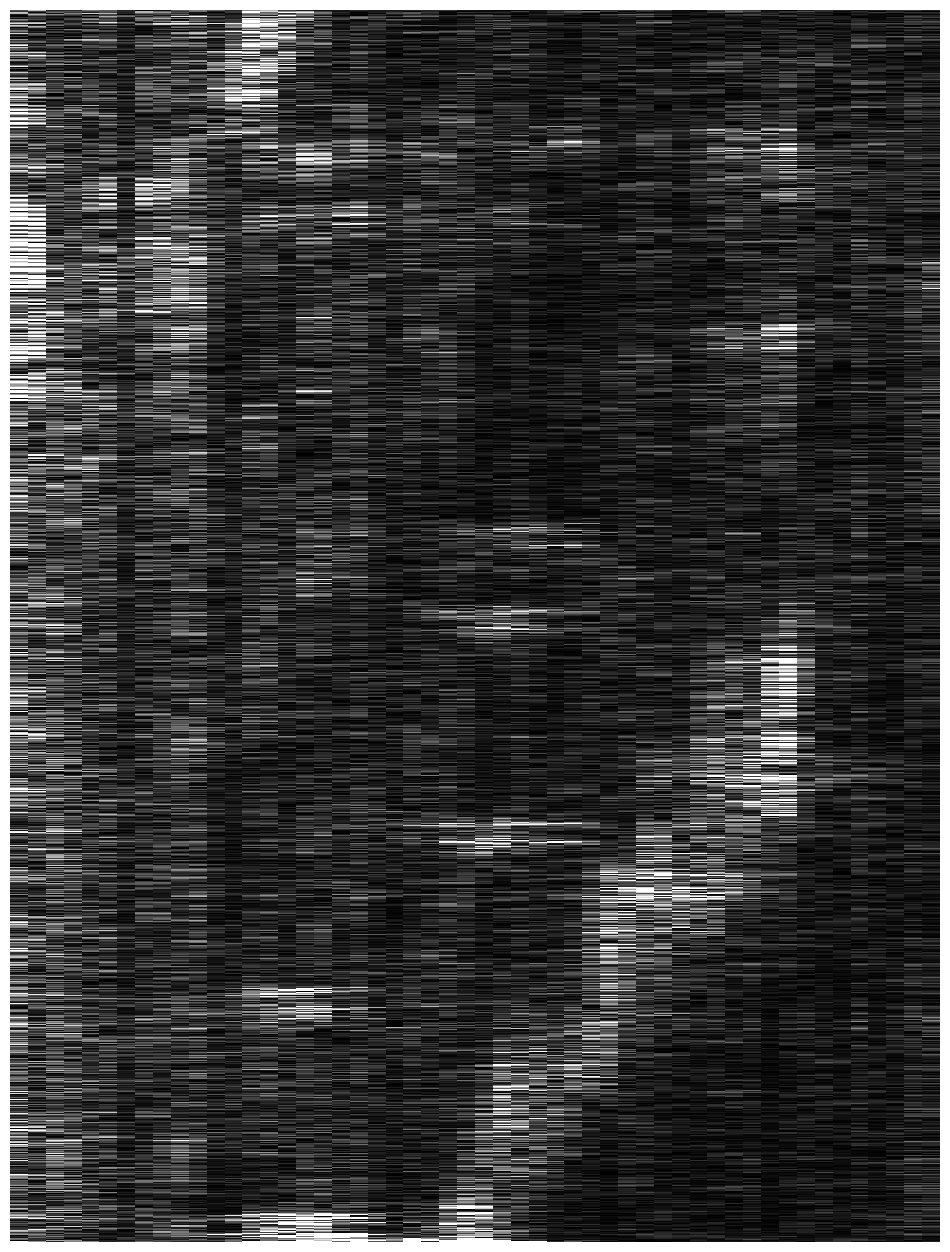

In [200]:
from visualisation import plot_timeframe
import numpy as np
from data import load_from_file, prepocess

import cv2

filename = "090352.npy"

data = load_from_file(filename)
# plot_timeframe(data)

img = data.to_numpy()

img = prepocess(img)
original_img = img.copy()

plot_numpy(img)



In [201]:
img = cv2.fastNlMeansDenoising(img, templateWindowSize=10,searchWindowSize=31, h=20)
plot_numpy(img)


In [202]:
# img2 = cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)))
# plot_numpy(img2)

In [203]:
# img = cv2.GaussianBlur(img, (5, 5), 0)
# img = cv2.fastNlMeansDenoising(img, templateWindowSize=10,searchWindowSize=31, h=20)

plot_numpy(img)



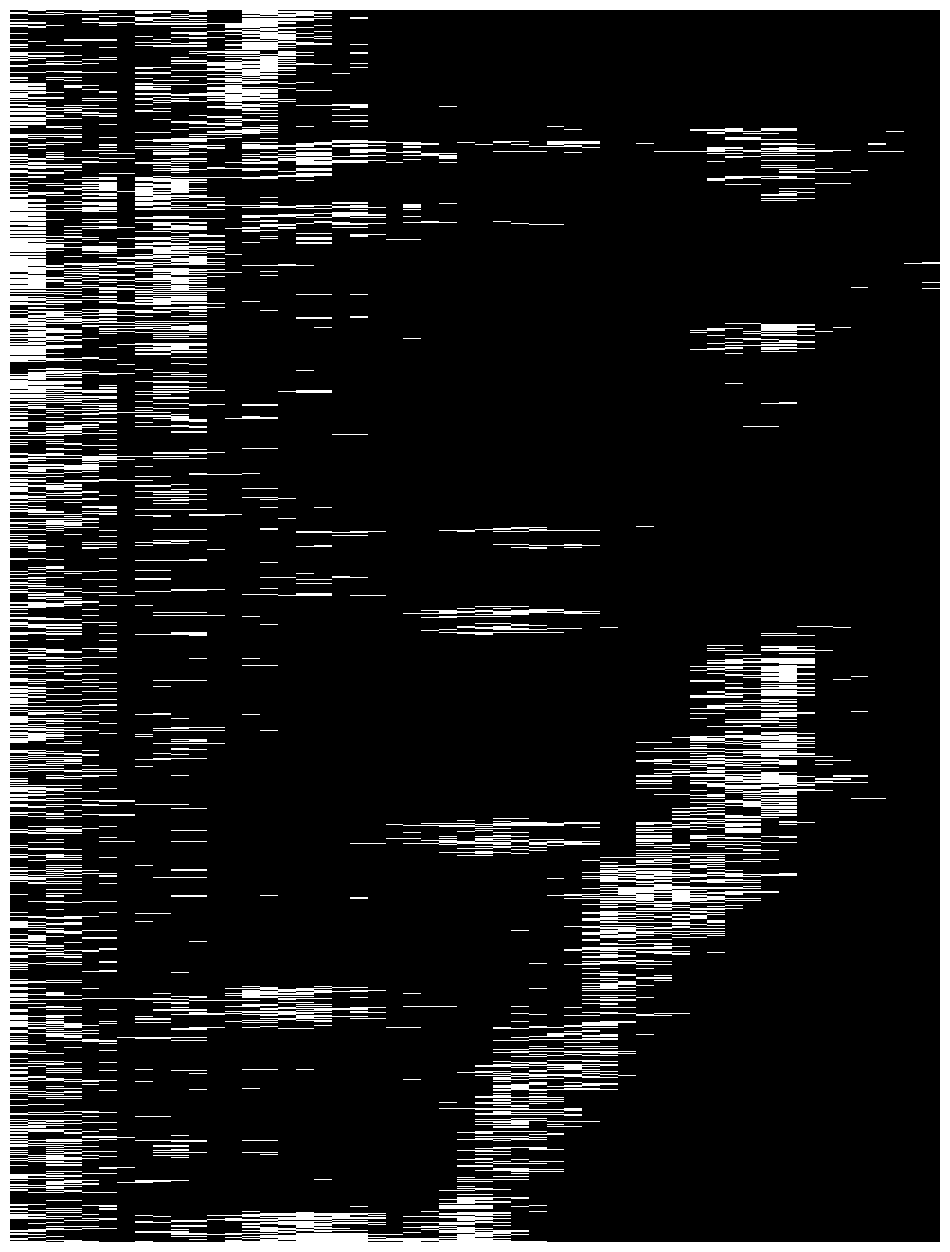

In [204]:
tr, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# tr, img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


plot_numpy(img)


In [226]:
def proper_opening(image, kernel=(3,3), iterations=1):
    close1 = cv2.morphologyEx(
        image, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, kernel), iterations=iterations
    )
    
    open1 = cv2.morphologyEx(
        close1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, kernel), iterations=iterations
    )
    
    close2 = cv2.morphologyEx(
        open1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, kernel), iterations=iterations
    )

    return np.minimum(image, close2)

def proper_closing(image, kernel=(3,3), iterations = 1):
       
    open1 = cv2.morphologyEx(
        image, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, kernel), iterations=iterations
    )
    close1 = cv2.morphologyEx(
        open1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, kernel), iterations=iterations
    )
    open2 = cv2.morphologyEx(
        close1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, kernel), iterations=iterations
    )

    return np.maximum(image, open2)

def automedian_filter(image, kernel=(3,3), iterations = 1):
       
    open1 = cv2.morphologyEx(
        image, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, kernel), iterations=iterations
    )
    
    close1 = cv2.morphologyEx(
        open1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, kernel), iterations=iterations
    )

    open2 = cv2.morphologyEx(
        close1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, kernel), iterations=iterations
    )
    return np.maximum(open2, proper_opening(image, kernel, iterations))

# img2 = proper_opening(img, kernel=(3,3), iterations=3)
# img2 = img.copy()
# for i in range(3):
#     img2 = cv2.morphologyEx(
#             img2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)), iterations=1
#         )
#     img2 = cv2.morphologyEx(
#             img2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)), iterations=1
#        . )
img2 = automedian_filter(img, kernel=(5,5))
(img2 != img).sum()
# plot_numpy(img)
# plot_numpy(img2)


5979

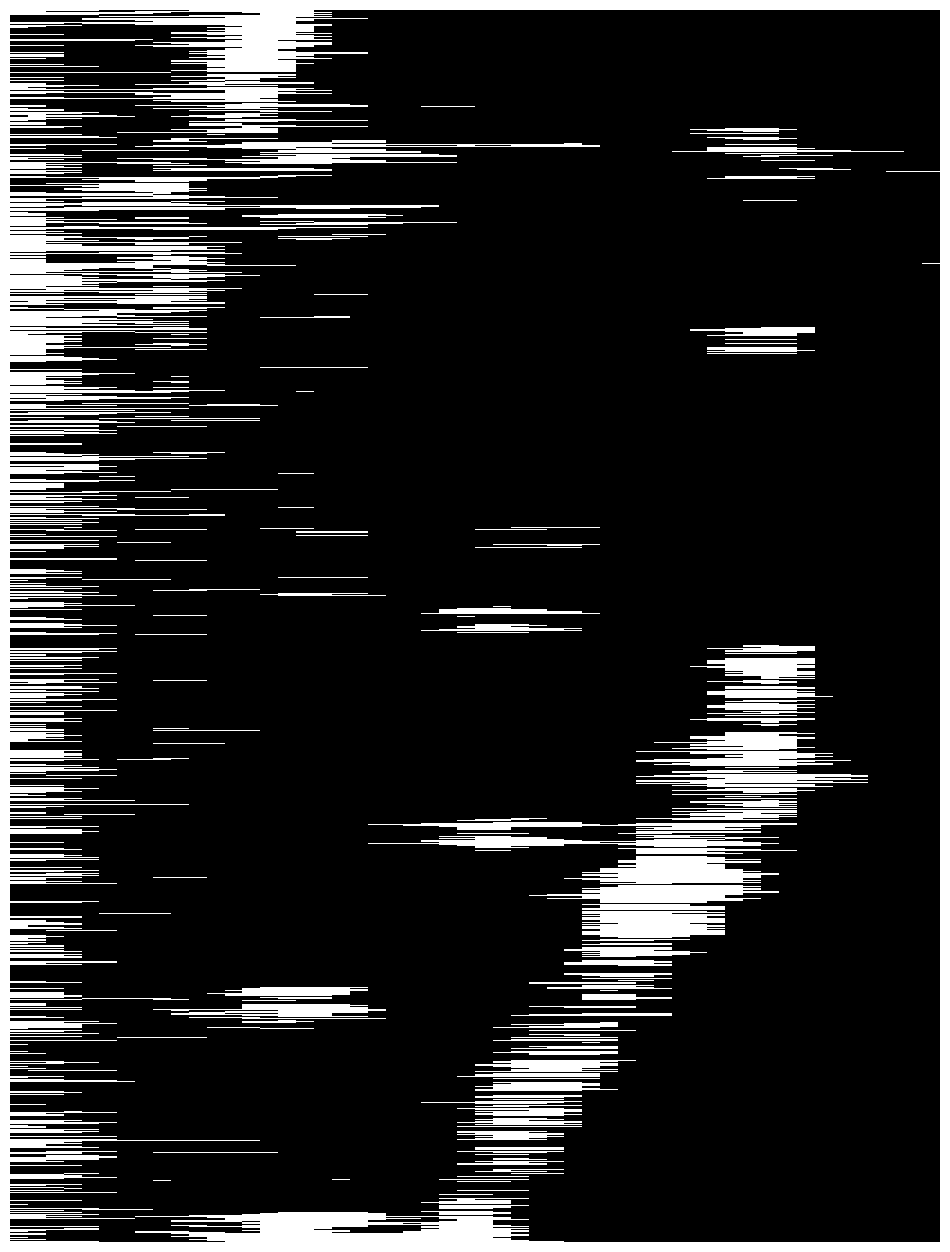

In [154]:
plot_numpy(median)

In [9]:
img.shape

(6250, 52)

In [10]:
def generate_colors(num_colors):
    hsv_colors = [(i / num_colors, 1.0, 1.0) for i in range(num_colors)]
    rgb_colors = [plt.cm.hsv(h)[:3] for h, _, _ in hsv_colors]
    rgb_colors = (np.array(rgb_colors) * 255).astype(np.uint8)
    np.random.shuffle(rgb_colors)
    return rgb_colors

In [66]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

X = np.nonzero(img)
X = np.vstack(X).T

X.shape
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
clustering = DBSCAN(eps=0.08, min_samples=500).fit(X_scaled)

no_of_clusters = np.max(clustering.labels_)+1
print(no_of_clusters)


1


Number of clusters:  1


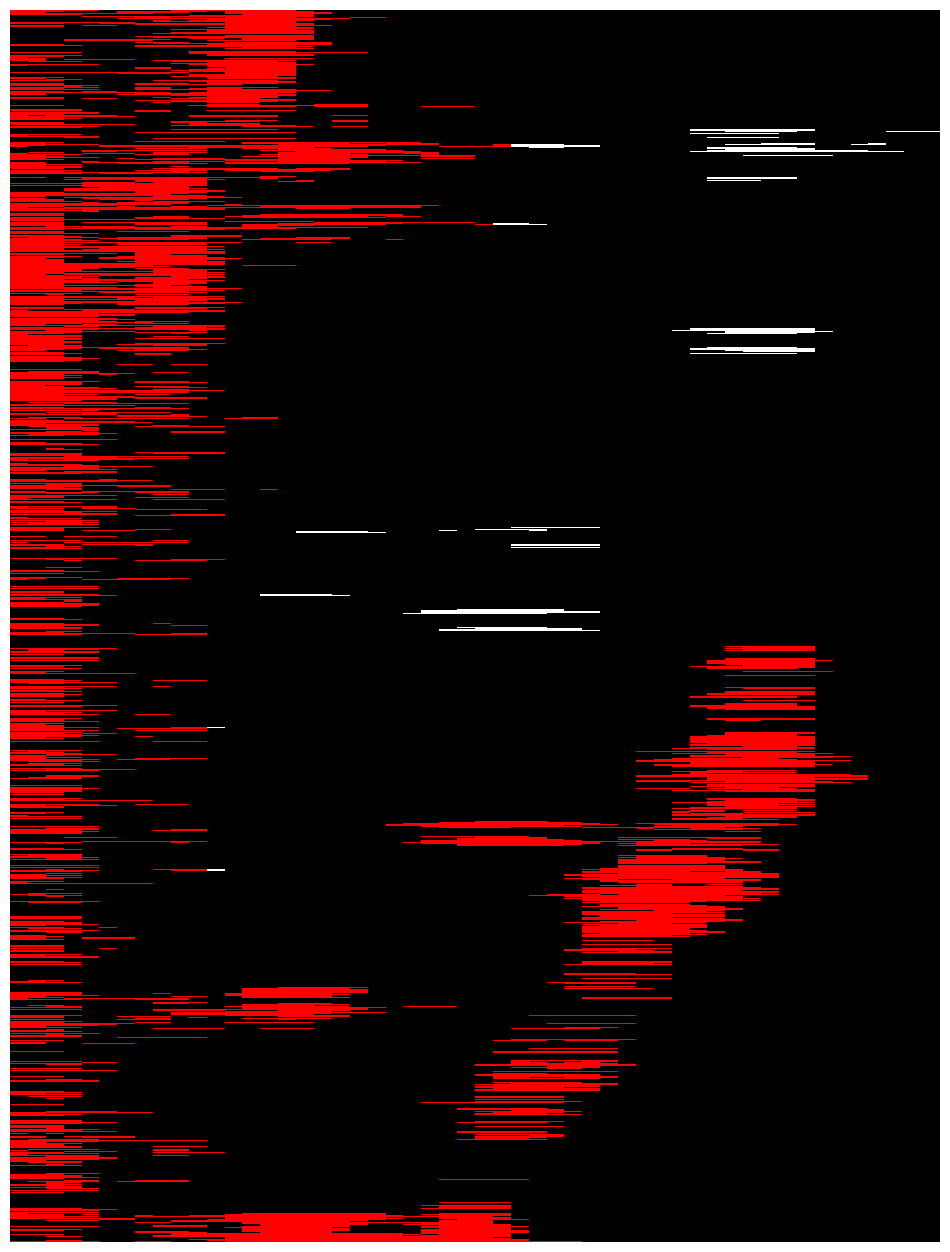

In [67]:
colors = generate_colors(no_of_clusters) 
img_clusters = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

print("Number of clusters: ", no_of_clusters)
for cluster_id in range(no_of_clusters):
    idx = X[clustering.labels_ == cluster_id, :]
    # print(idx)
    # print(f"Cluster{cluster_id}: {np.sum(idx)} members")
    img_clusters[idx.T[0], idx.T[1],:] = colors[cluster_id]

plot_numpy(img_clusters)

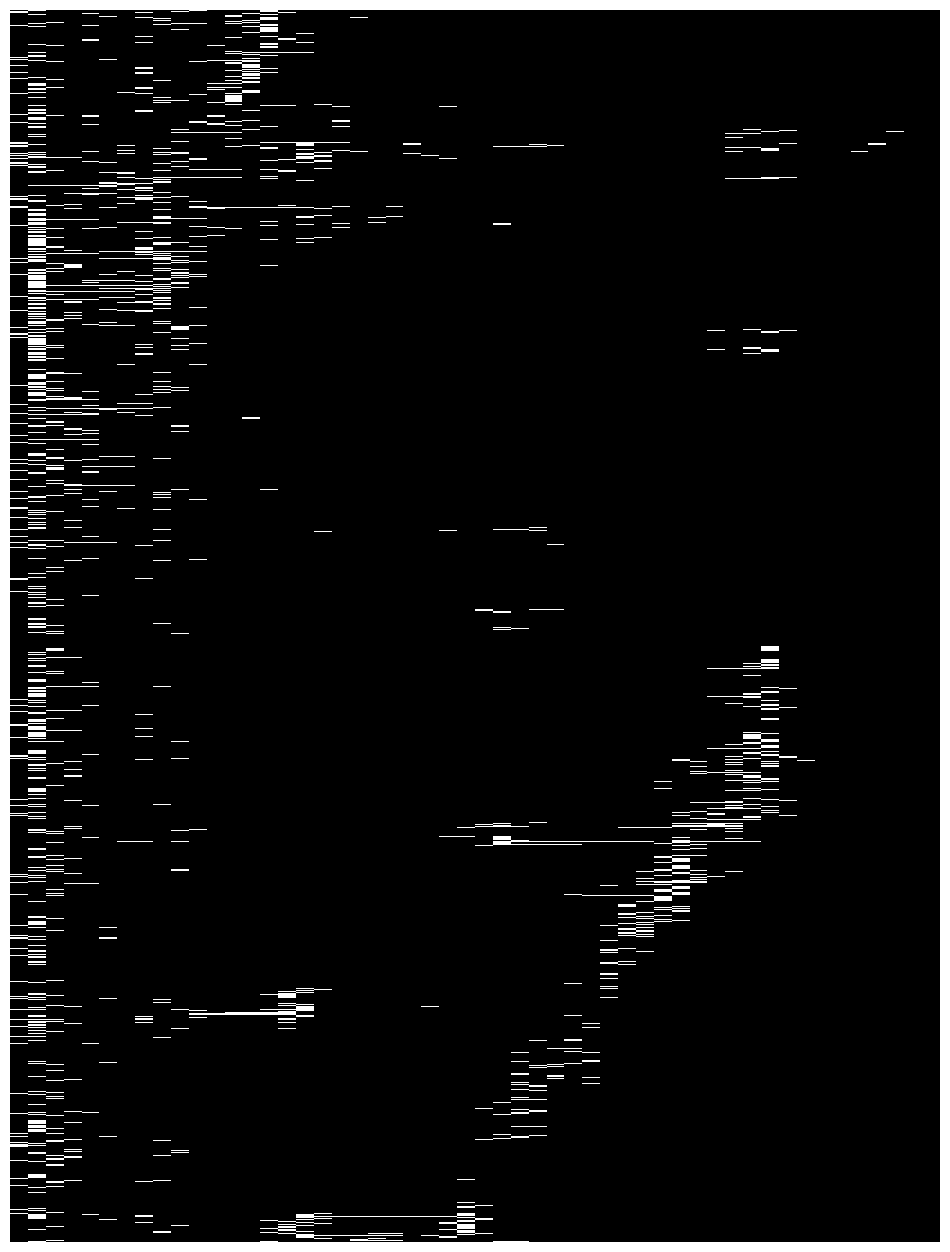

In [68]:
from skimage.morphology import skeletonize
skeleton = skeletonize(img)
plot_numpy(255 * skeleton.astype(np.uint8))

R2 of cluster 0: 0.6416429876852258
Discarded cluster 0 with R2=0.6416429876852258
R2 of cluster 1: 0.002226358915014548
Discarded cluster 1 with R2=0.002226358915014548
R2 of cluster 2: 0.016530346257022765
Discarded cluster 2 with R2=0.016530346257022765


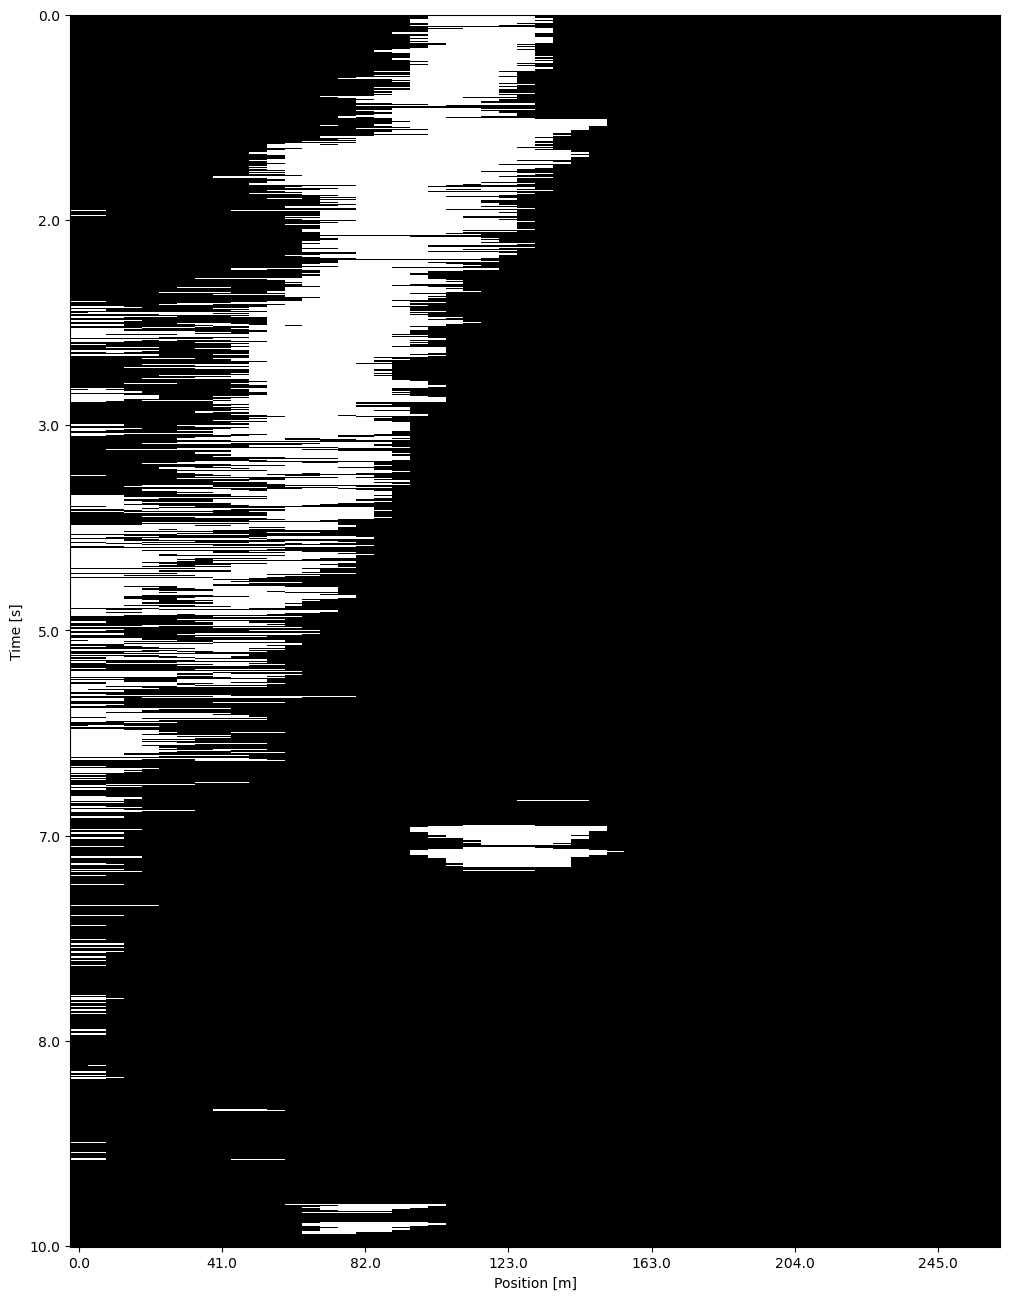

In [26]:
from sklearn.linear_model import LinearRegression

lines = []

for cluster_id in range(no_of_clusters):
    idx = X[clustering.labels_ == cluster_id, :]
    x_coords = idx[:, 1].reshape(-1,1)
    y_coords = idx[:, 0]
    
    model = LinearRegression()
    model.fit(x_coords, y_coords)

    slope = model.coef_[0]
    intercept = model.intercept_

    x_start = np.min(x_coords)
    x_end = np.max(x_coords)
    
    # y_start = model.predict([[x_start]])
    # y_end = model.predict([[x_end]])
    r2 = model.score(x_coords, y_coords)
    print(f"R2 of cluster {cluster_id}: {r2}")

    #DISCARDING R2 < 0.5
    if r2 < 0.5:
        print(f"Discarded cluster {cluster_id} with R2={r2}")
        continue
    velocity = velocity_from_slope(slope)
    print(f"Detected velocity: {velocity} m/s ({ mps_to_kmph(velocity) } km/h)")
    print()
    lines.append((slope,intercept, x_start, x_end))
    

plot_numpy_with_lines(img, lines)



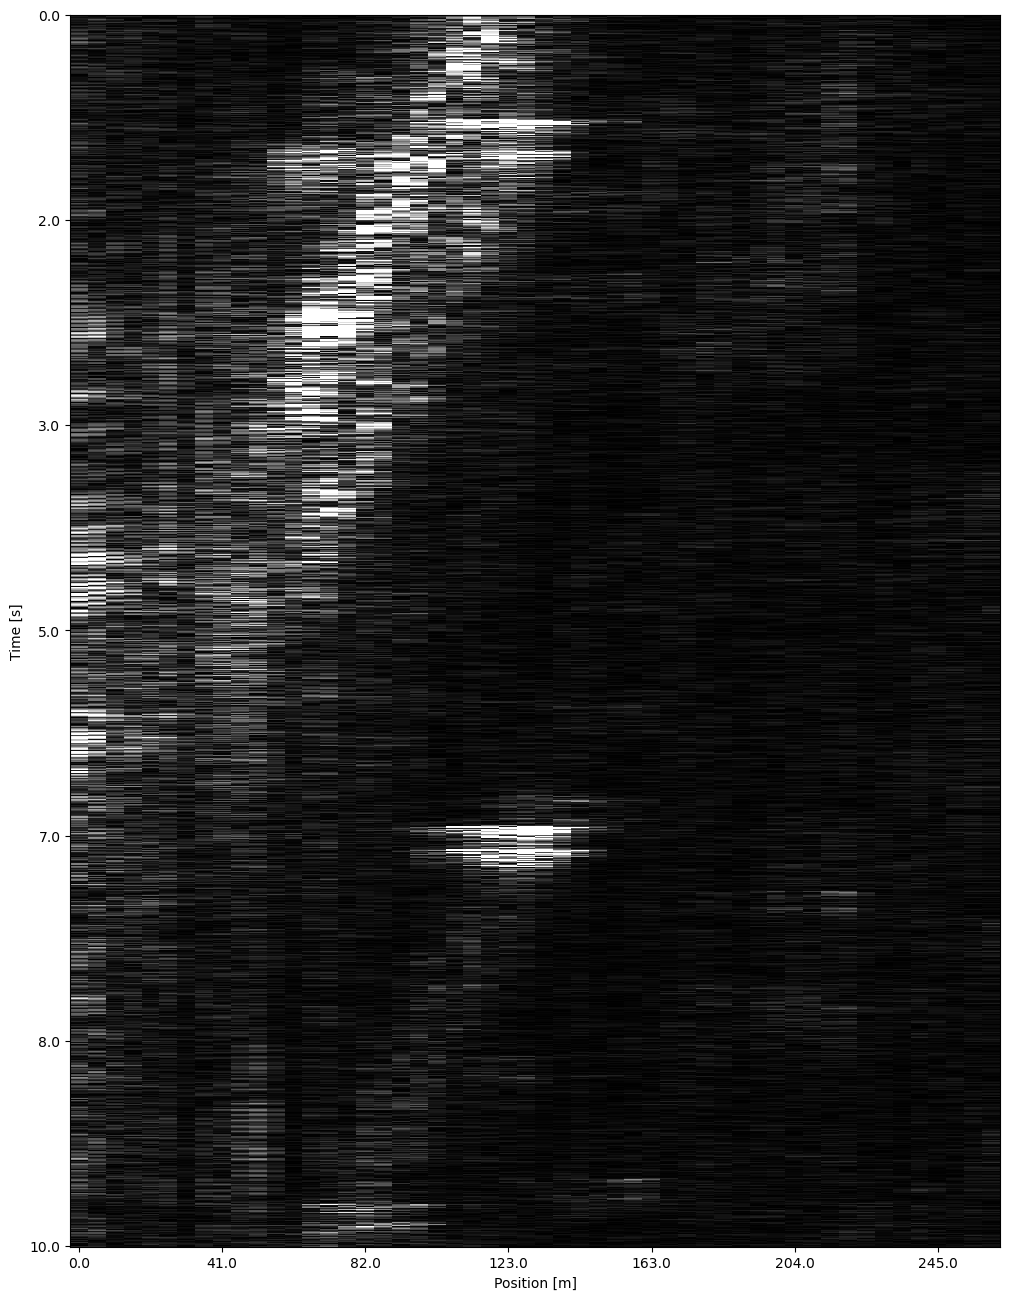

In [27]:
plot_numpy_with_lines(original_img, lines)

In [15]:
from regression_pipeline import detect_velocities

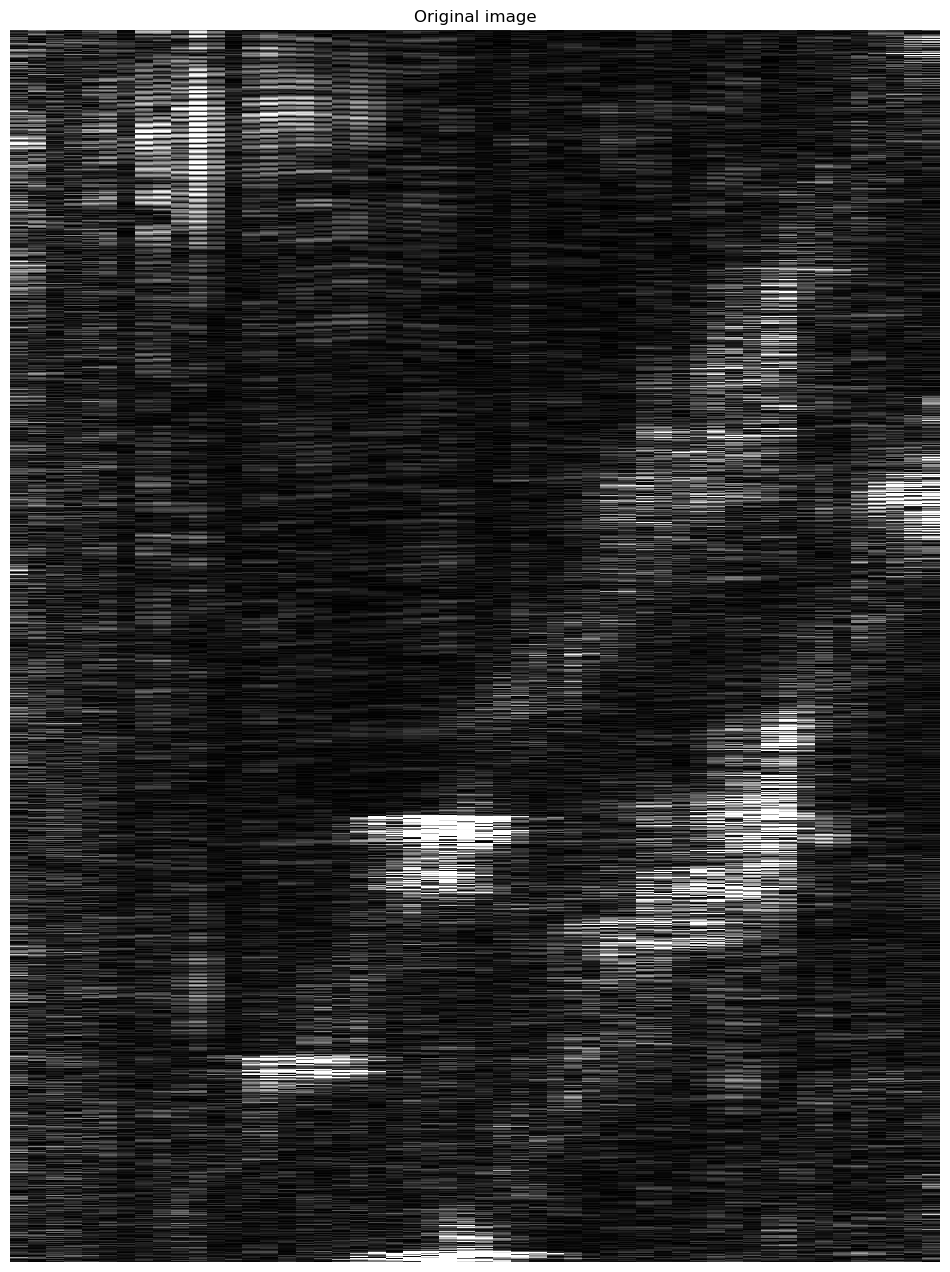

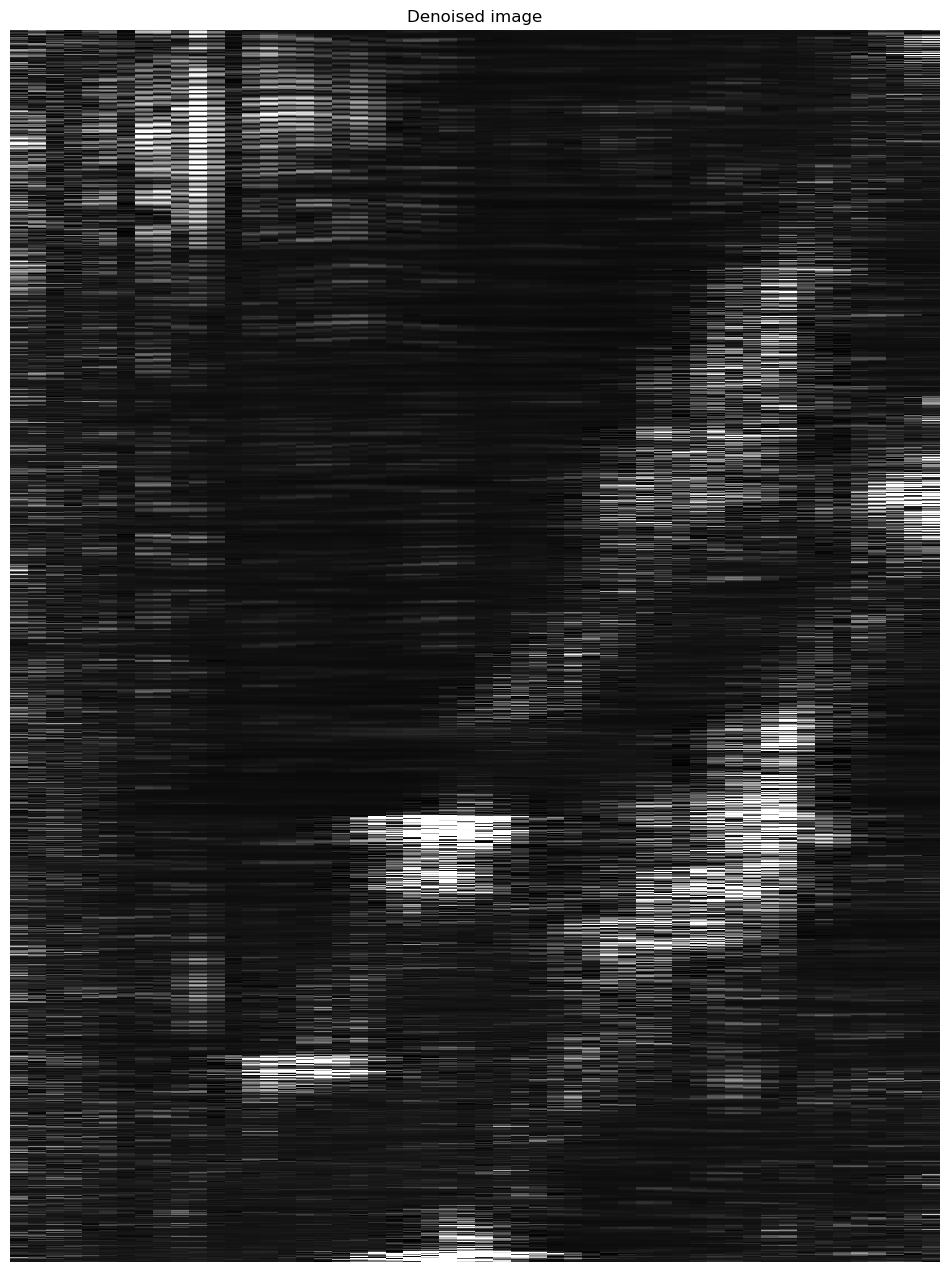

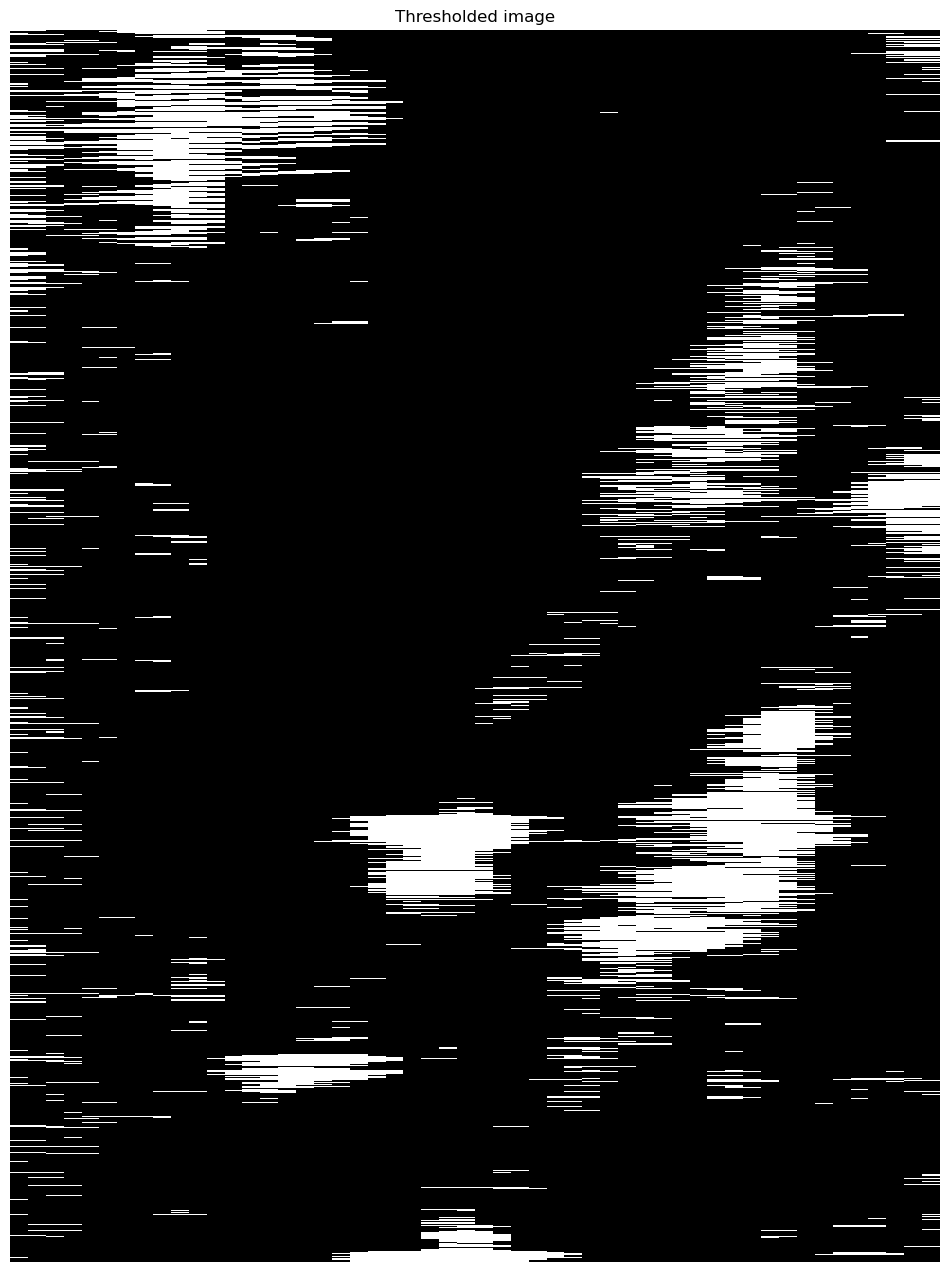

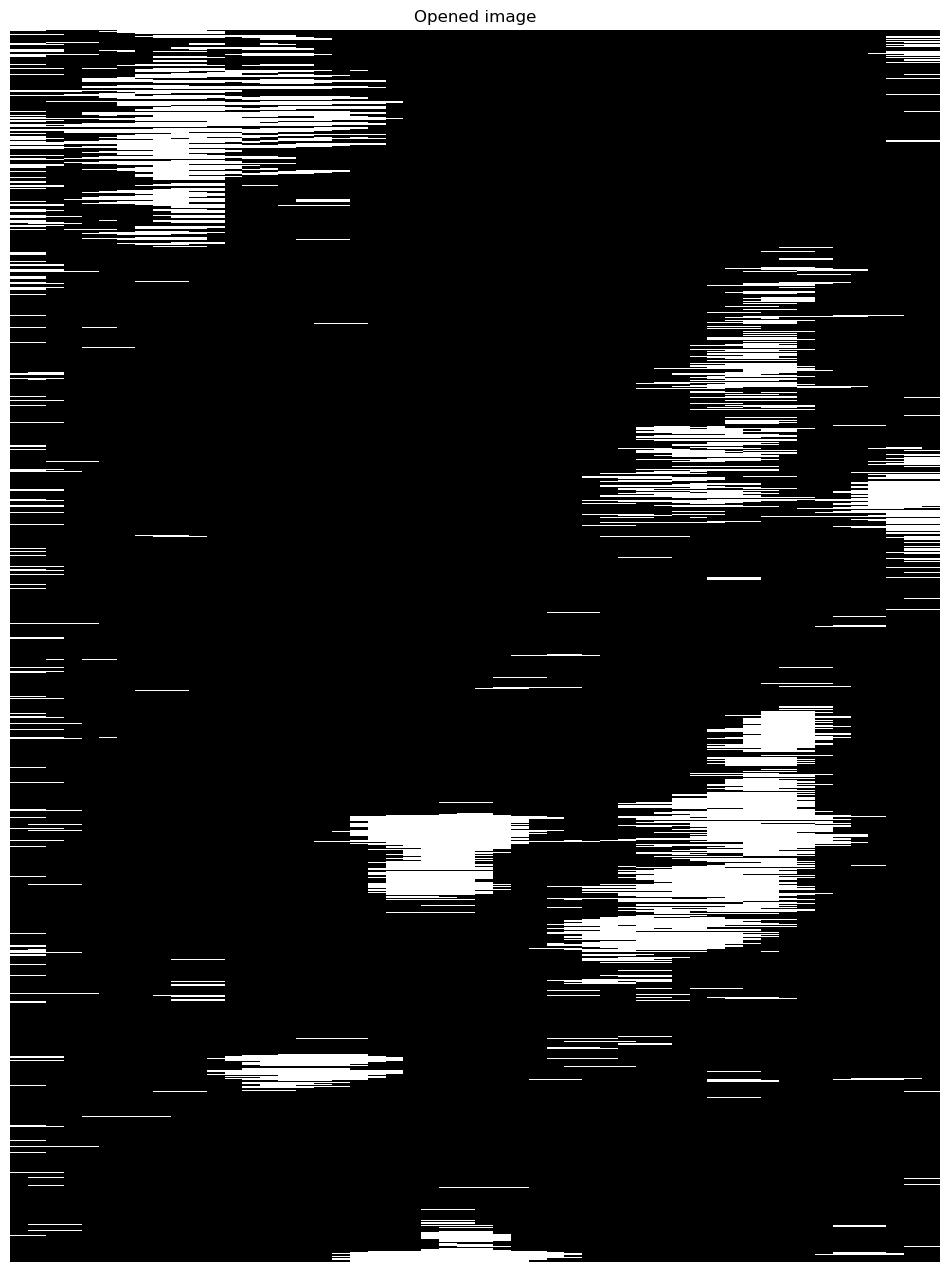

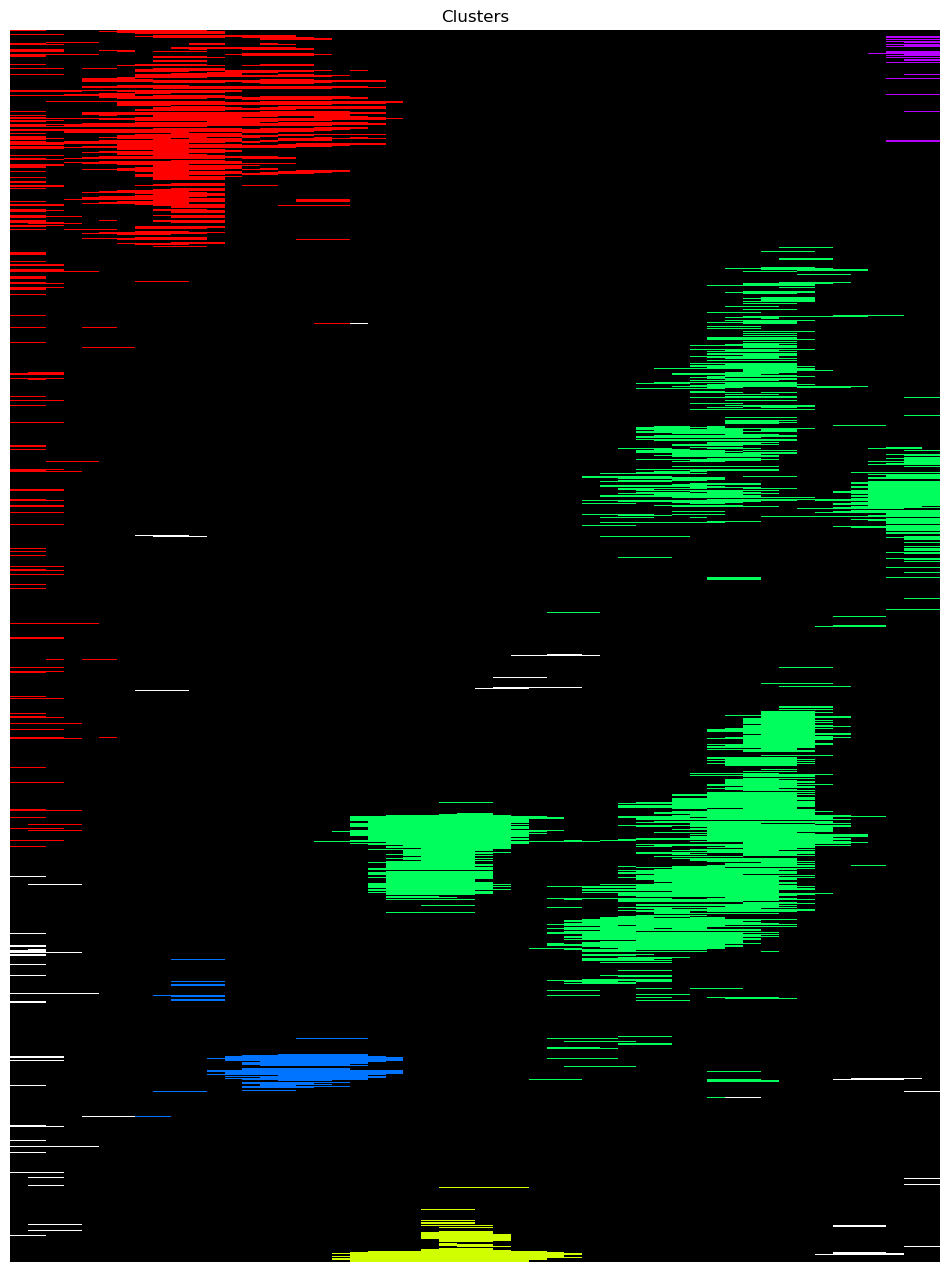

Discarded cluster 0 with R2=0.22681882691527933 (<0.6)
Discarded cluster 1 with R2=0.00011228107444249957 (<0.6)
Discarded cluster 2 with R2=0.2063138688986823 (<0.6)
Discarded cluster 3 with R2=0.23162945885921893 (<0.6)
Discarded cluster 4 with R2=0.01764204674315384 (<0.6)


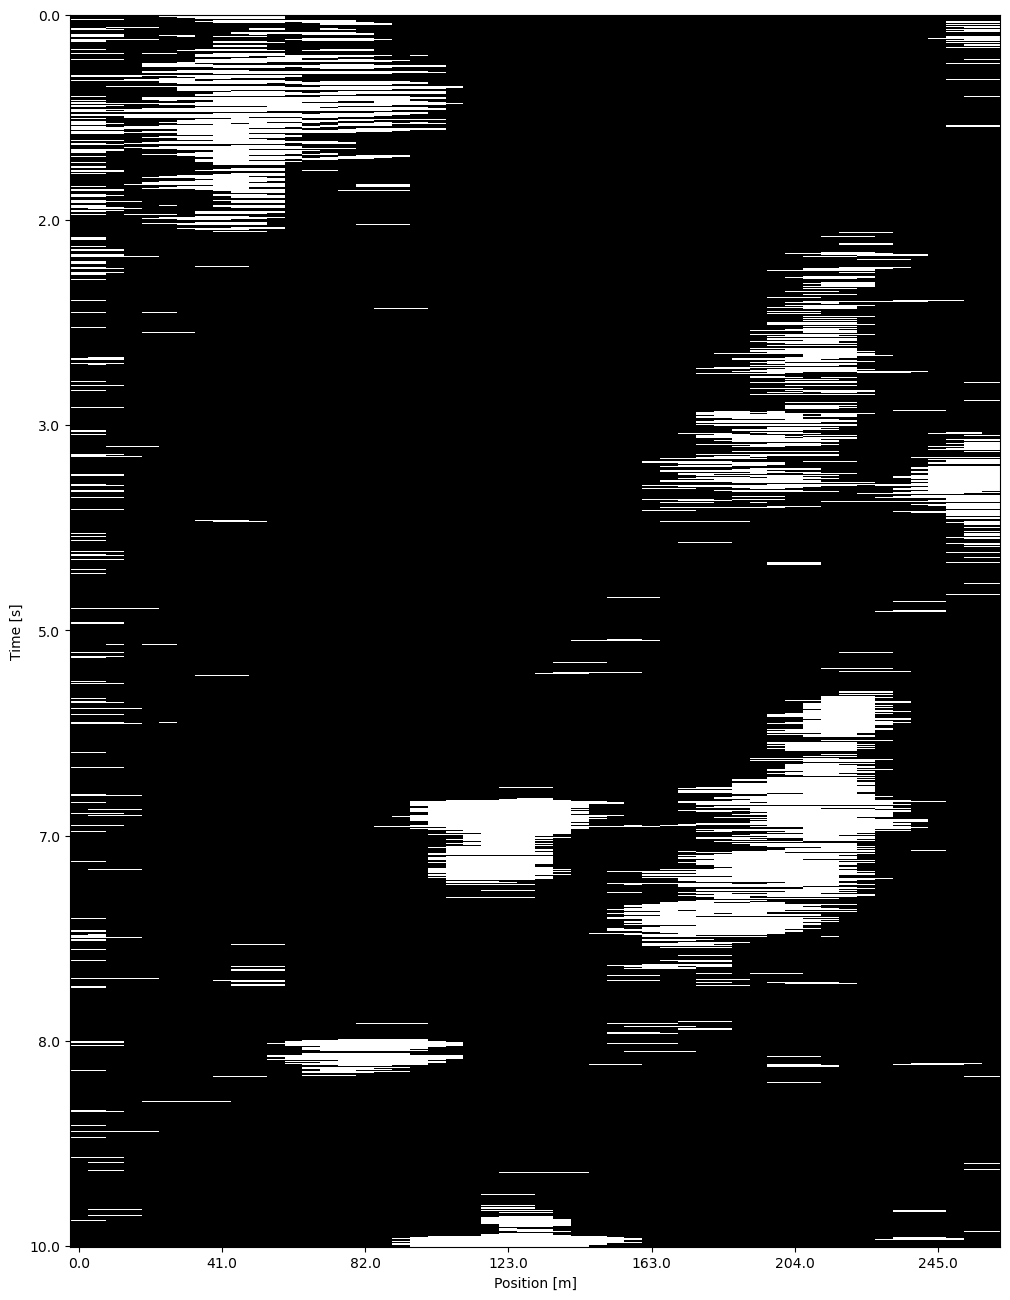

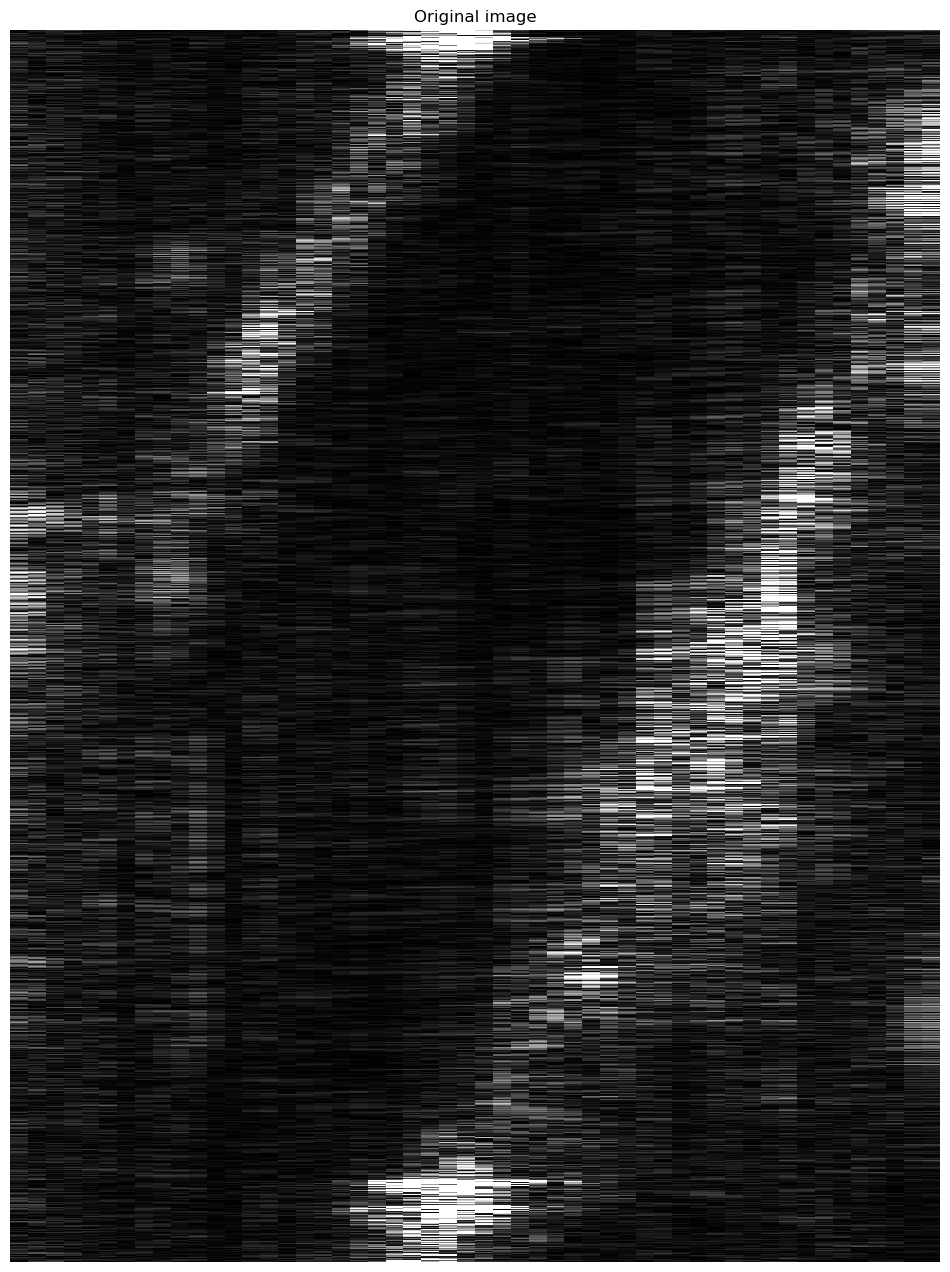

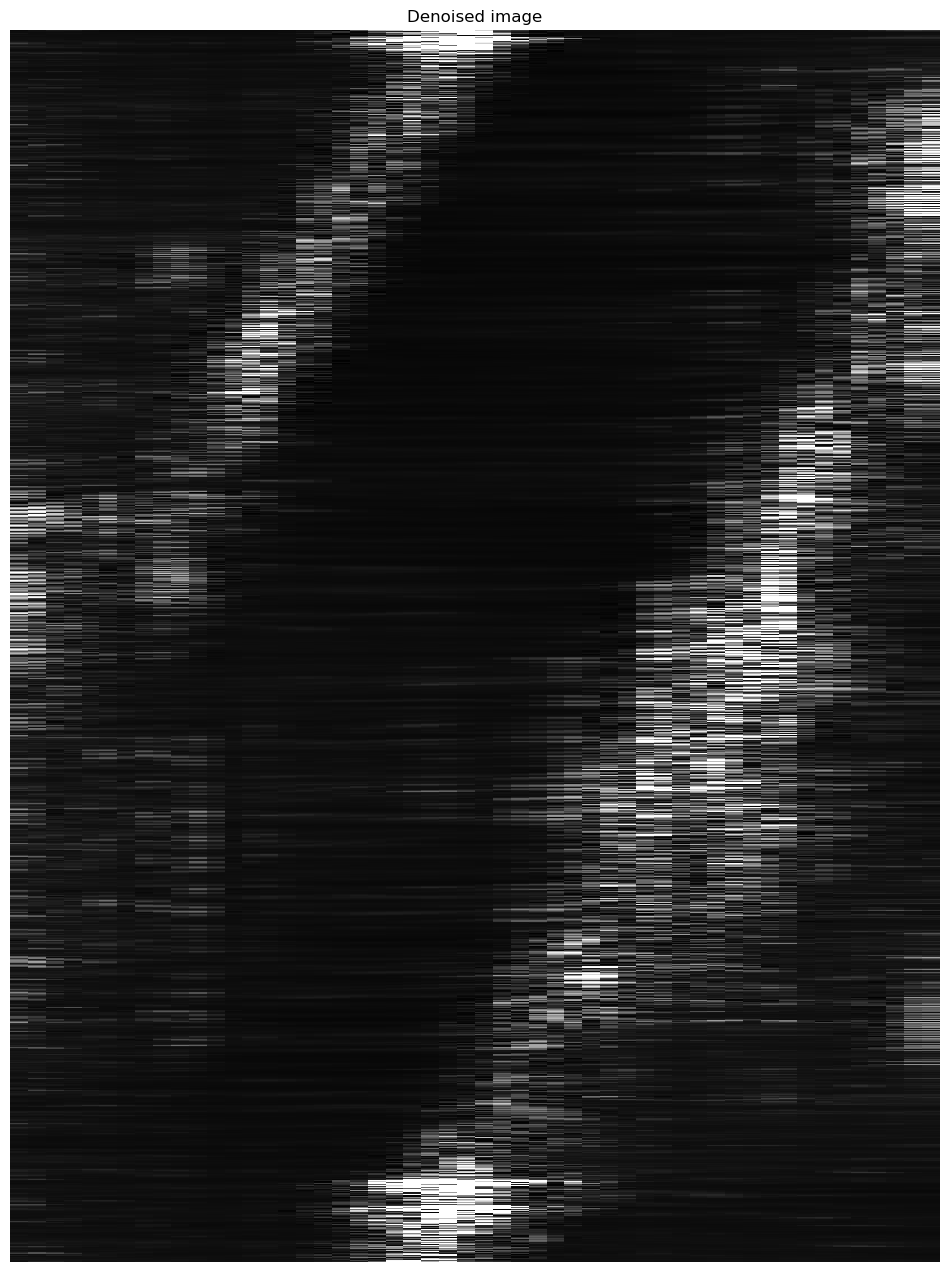

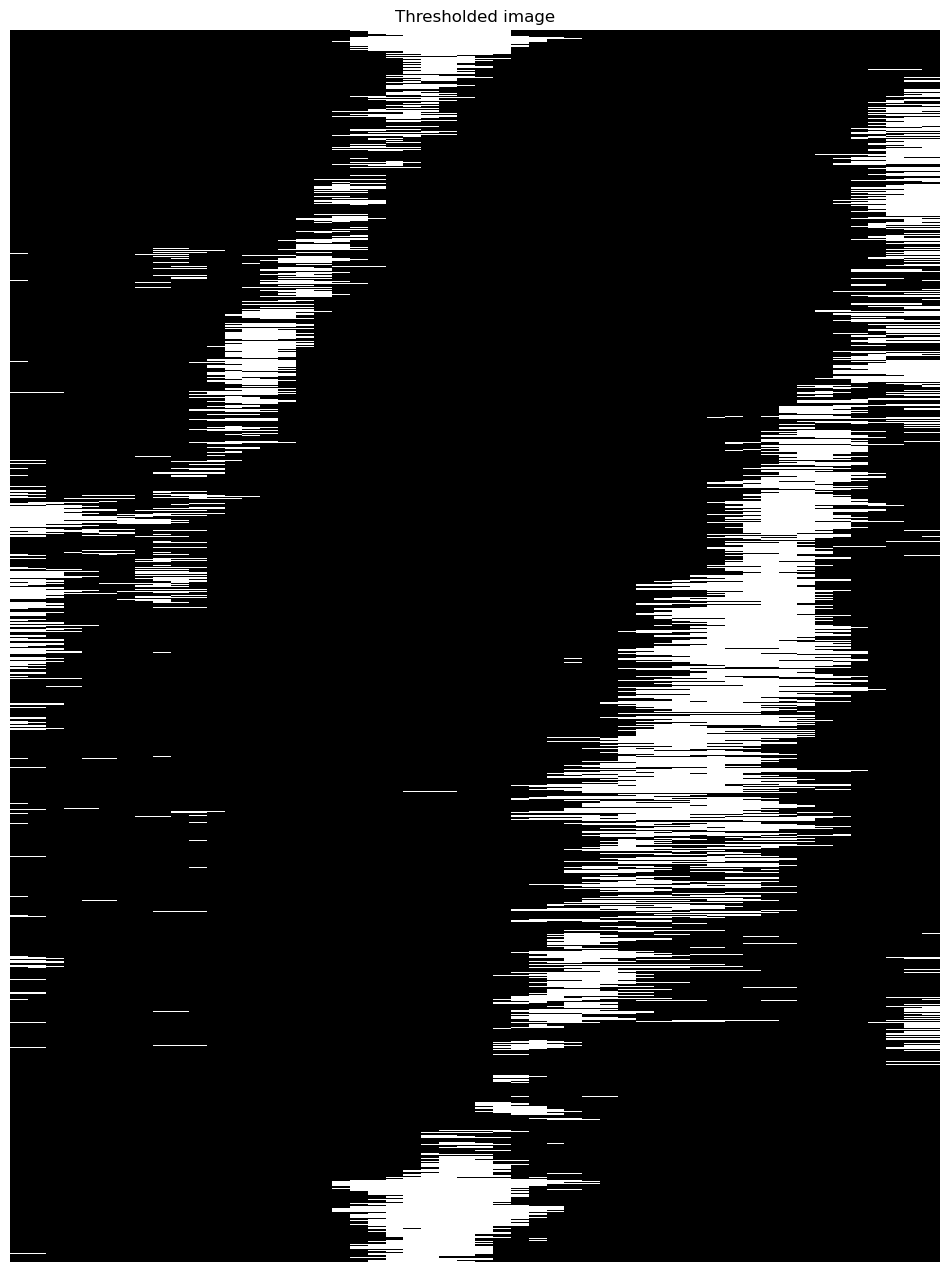

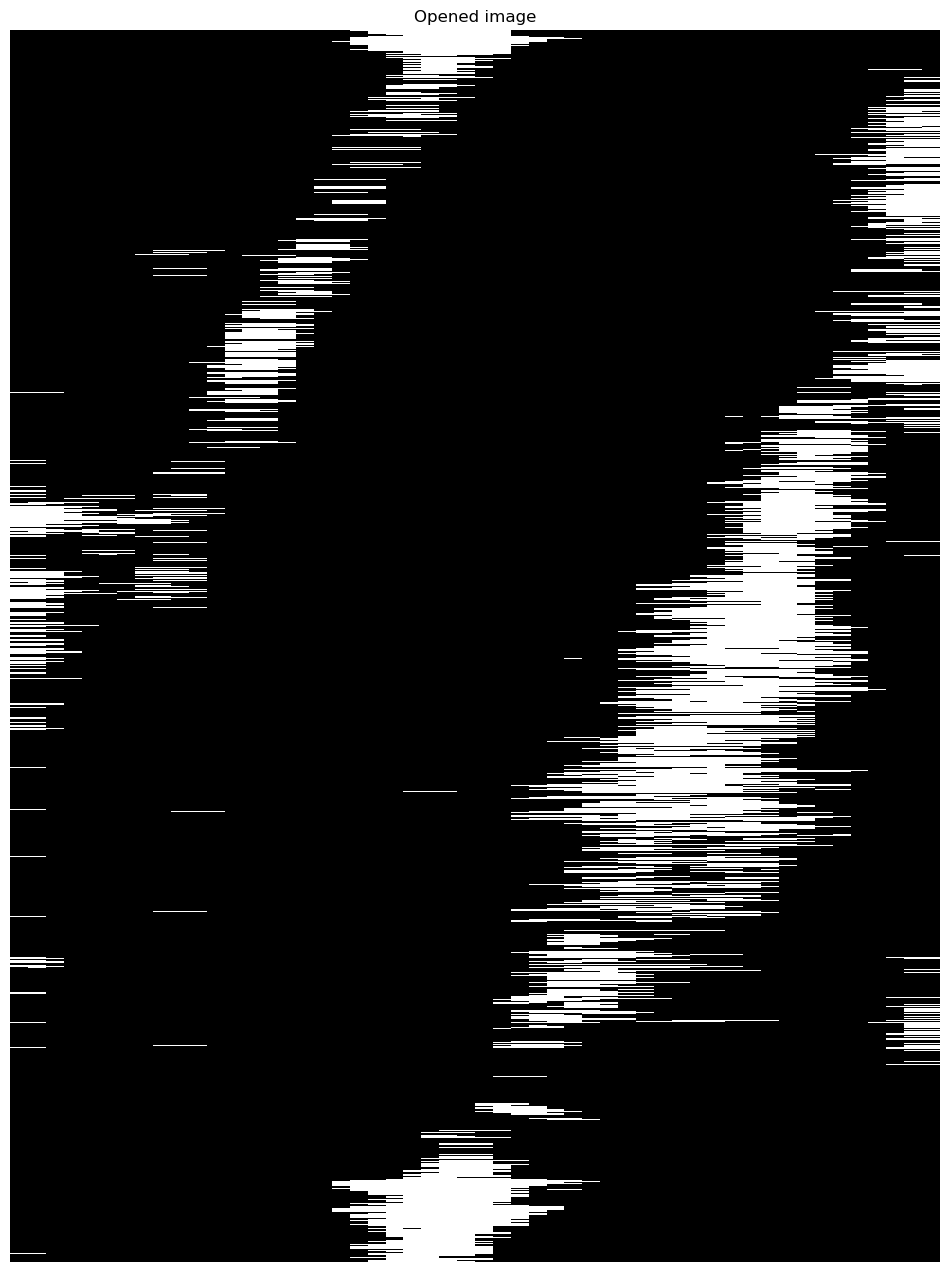

Detected velocity: 27.01 m/s (97.24 km/h)

Detected velocity: 18.79 m/s (67.64 km/h)

Discarded cluster 2 with R2=0.00025092101598955807 (<0.6)


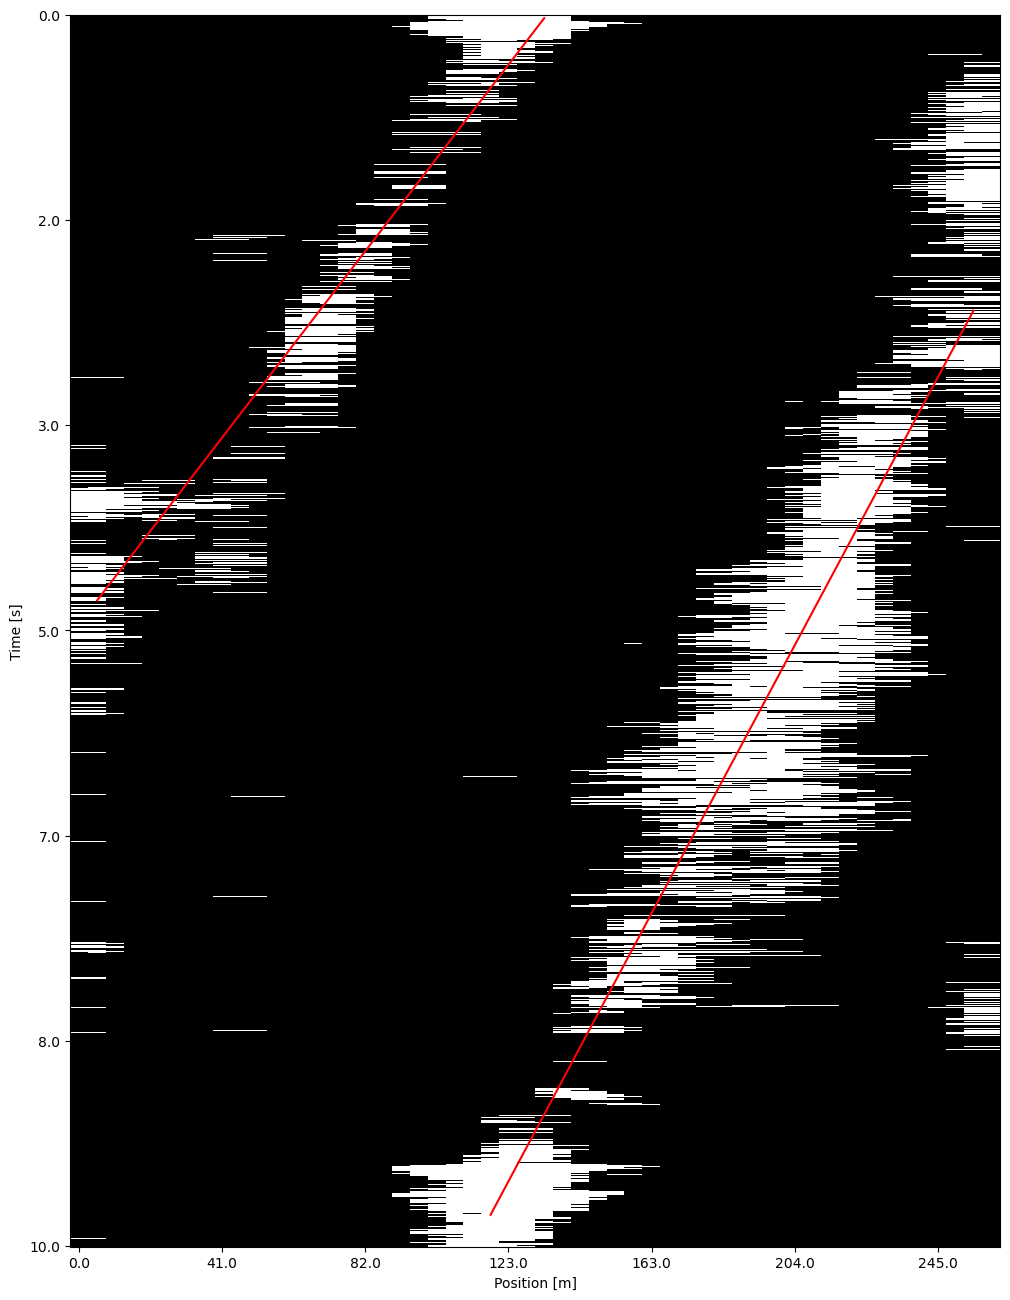

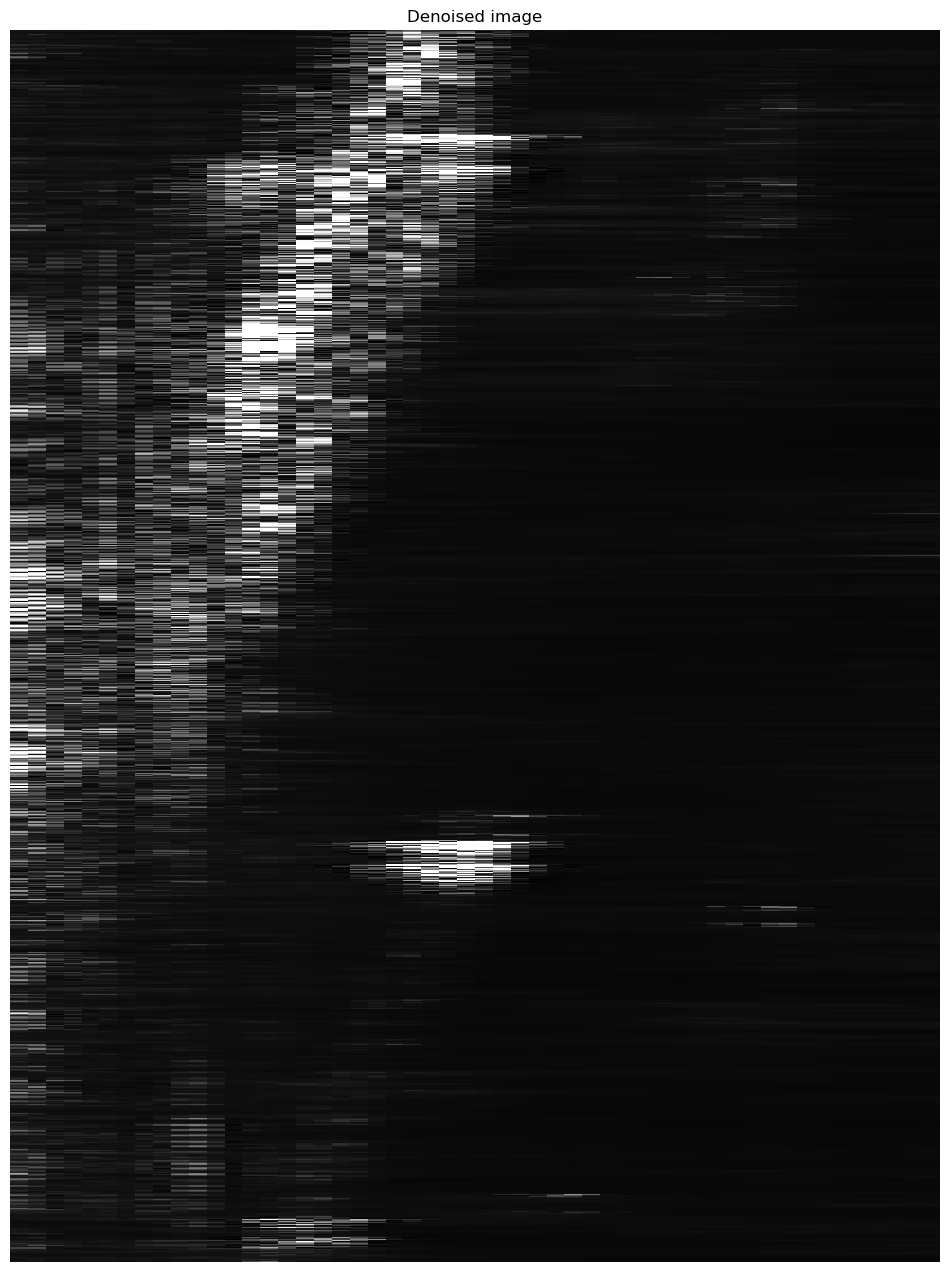

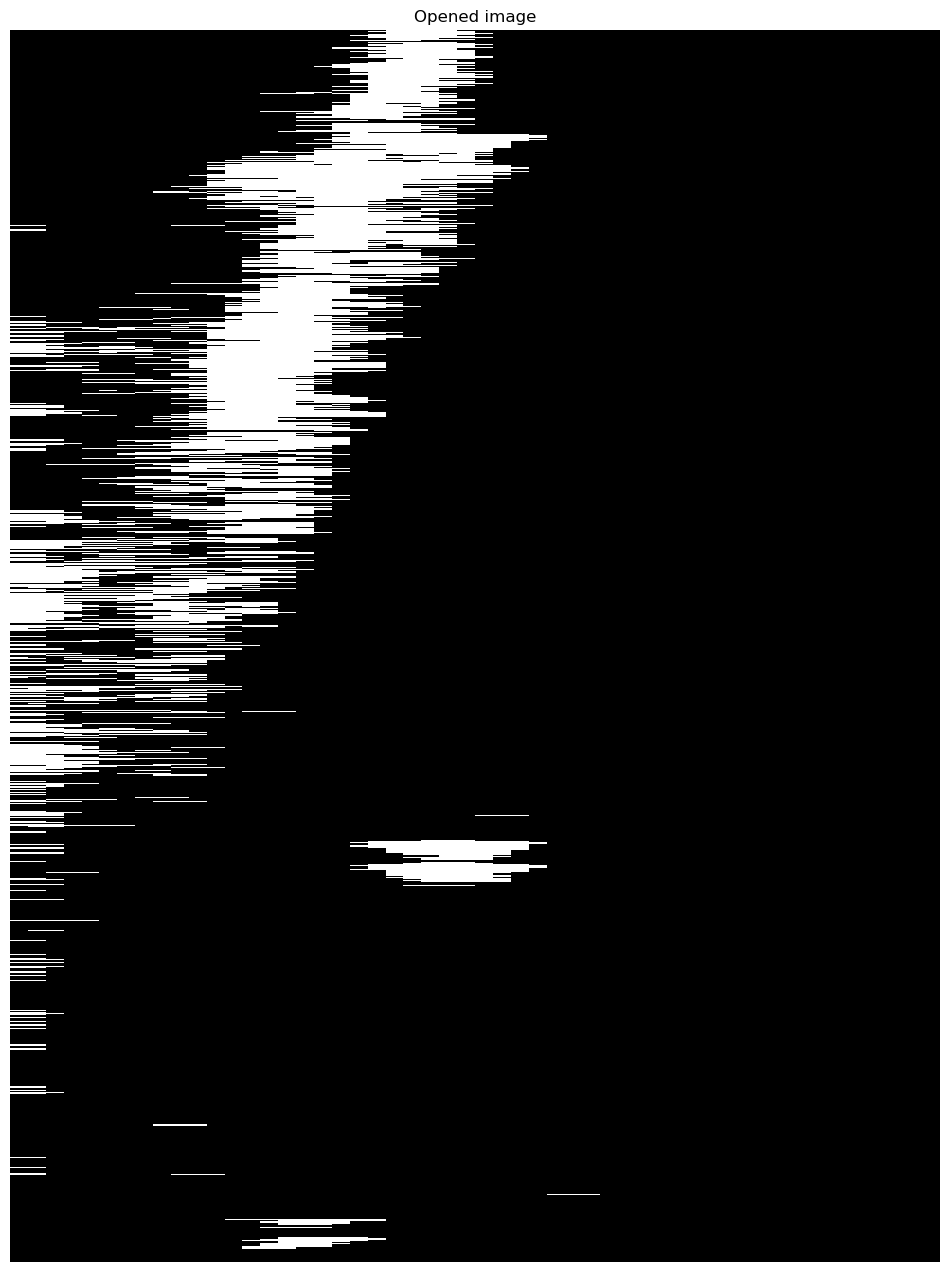

Detected velocity: 26.46 m/s (95.26 km/h)

Discarded cluster 1 with R2=0.0013239823996237243 (<0.6)
Discarded cluster 2 with R2=0.02908448918272266 (<0.6)


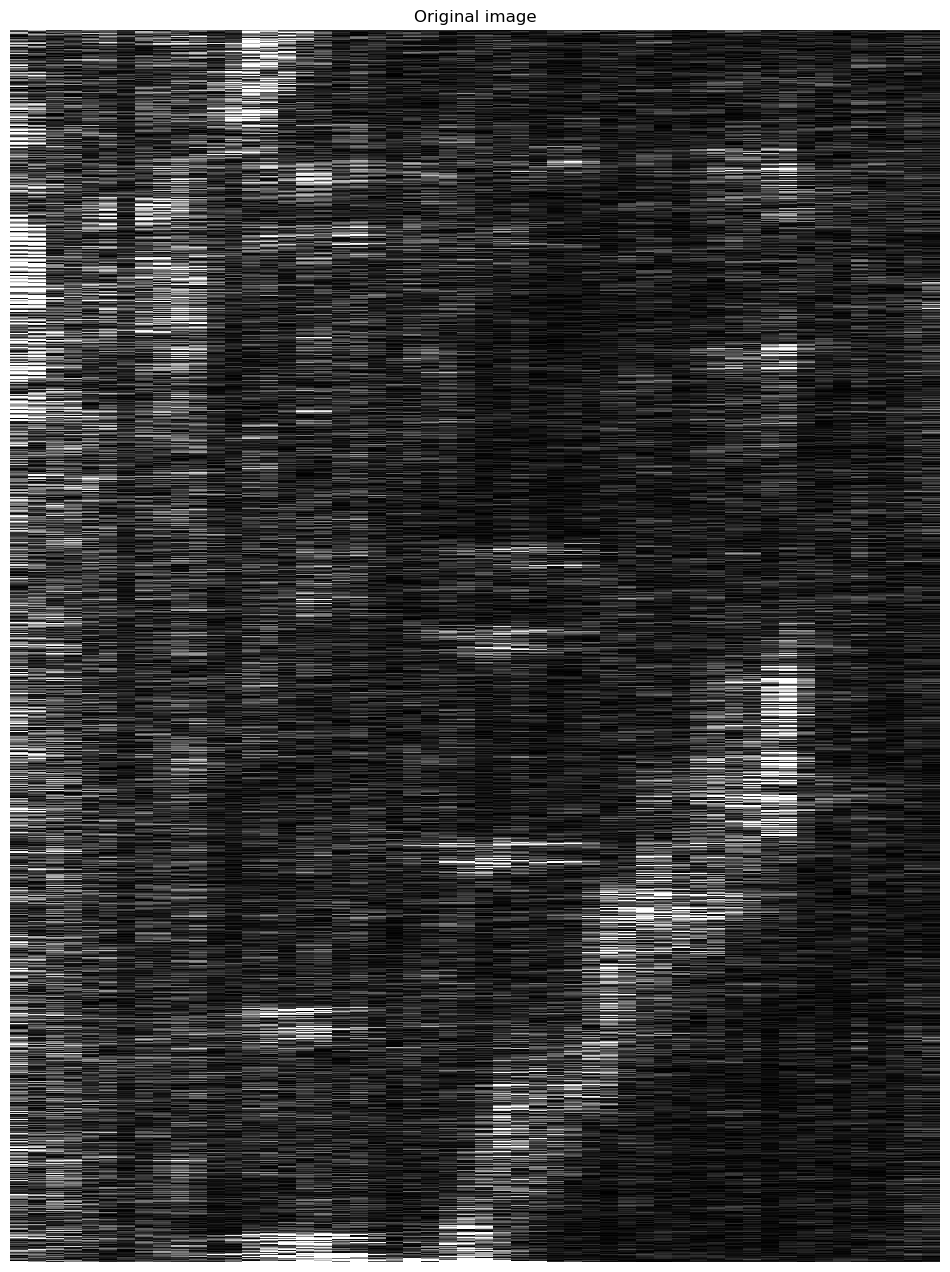

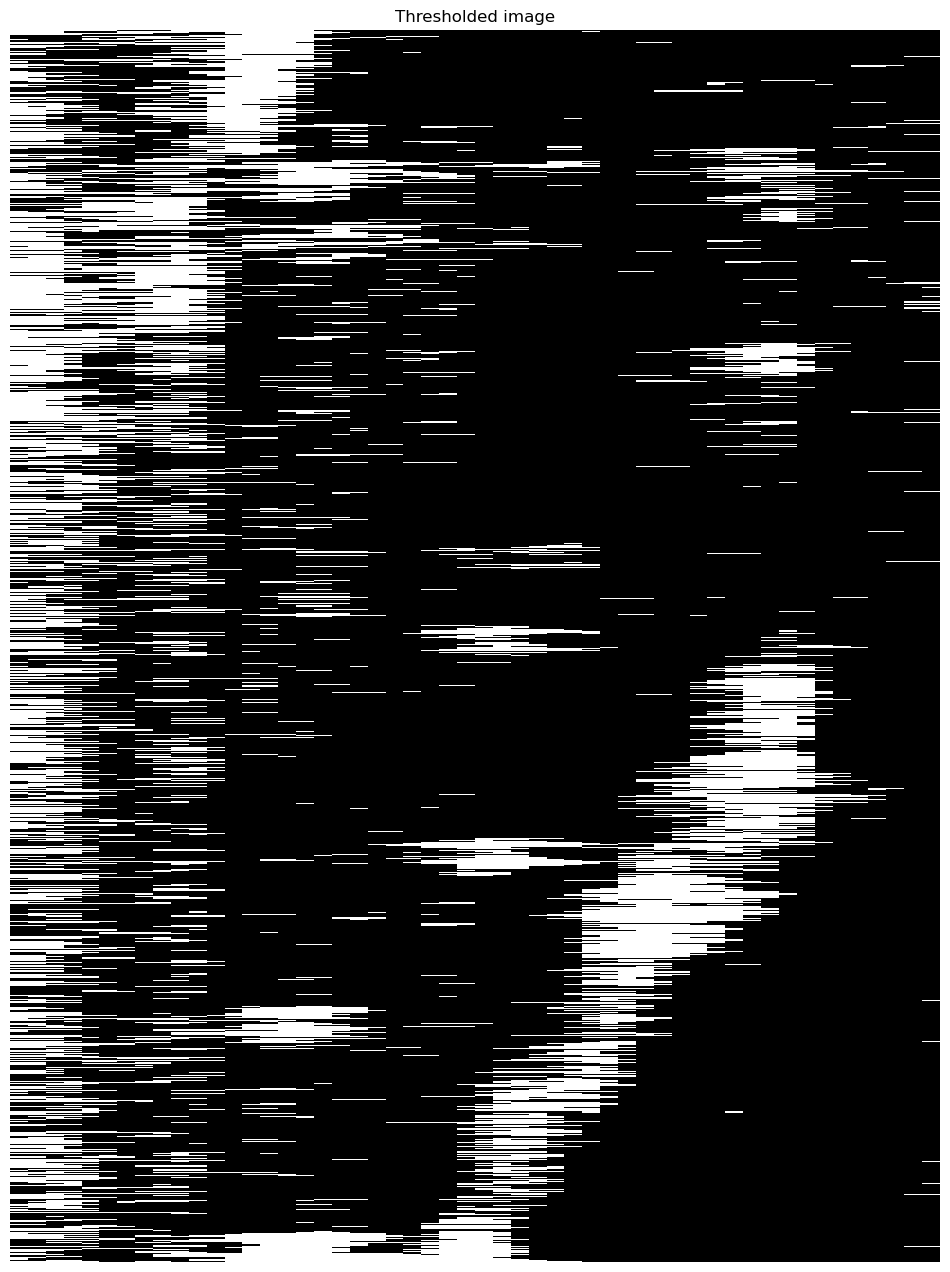

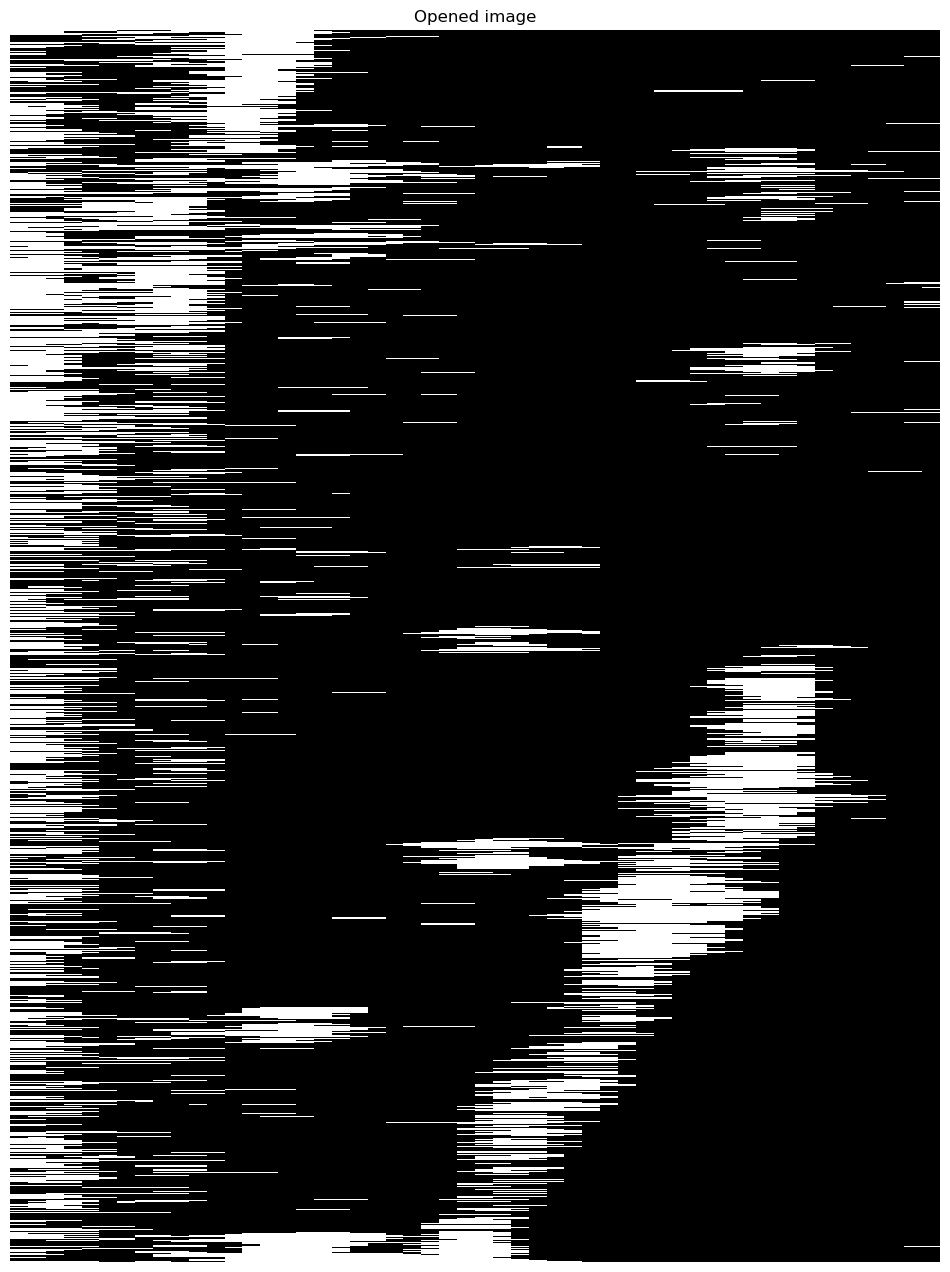

Discarded cluster 0 with R2=0.11228742422519233 (<0.6)
Discarded cluster 1 with R2=0.003135341005288561 (<0.6)
Discarded cluster 2 with R2=0.09062397852941129 (<0.6)


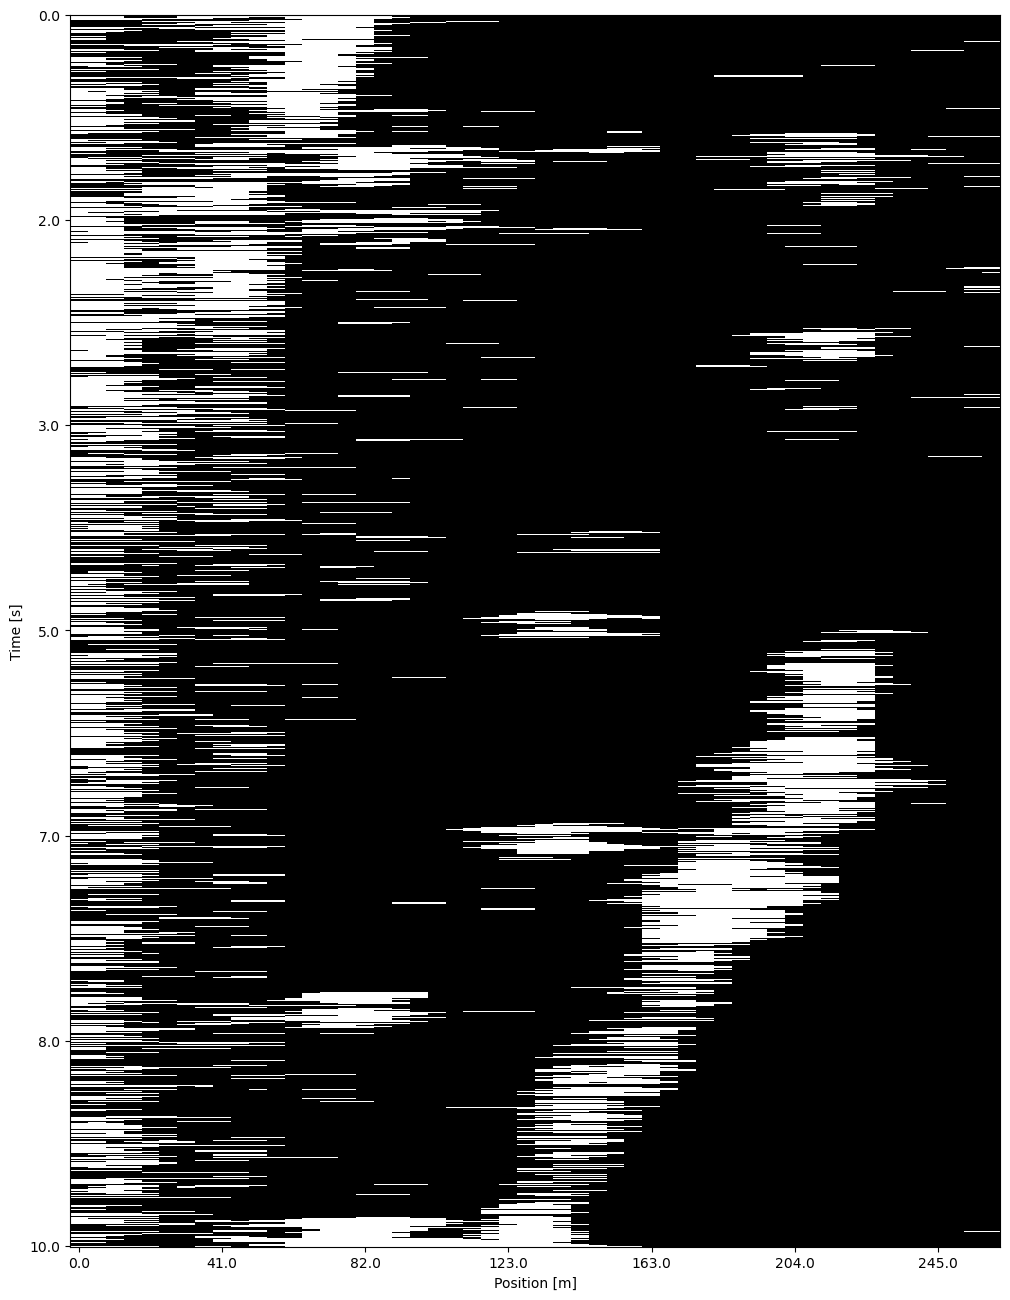

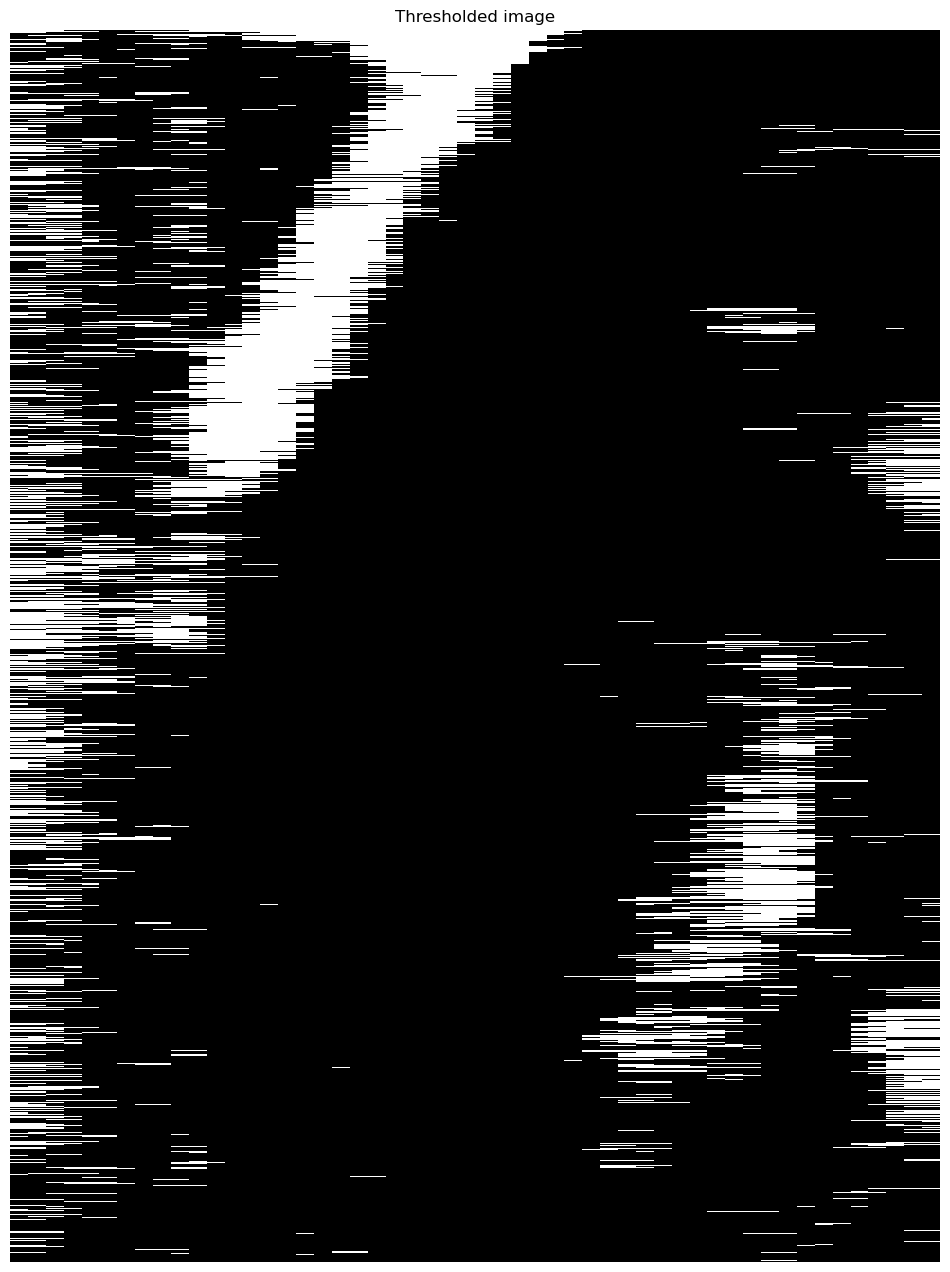

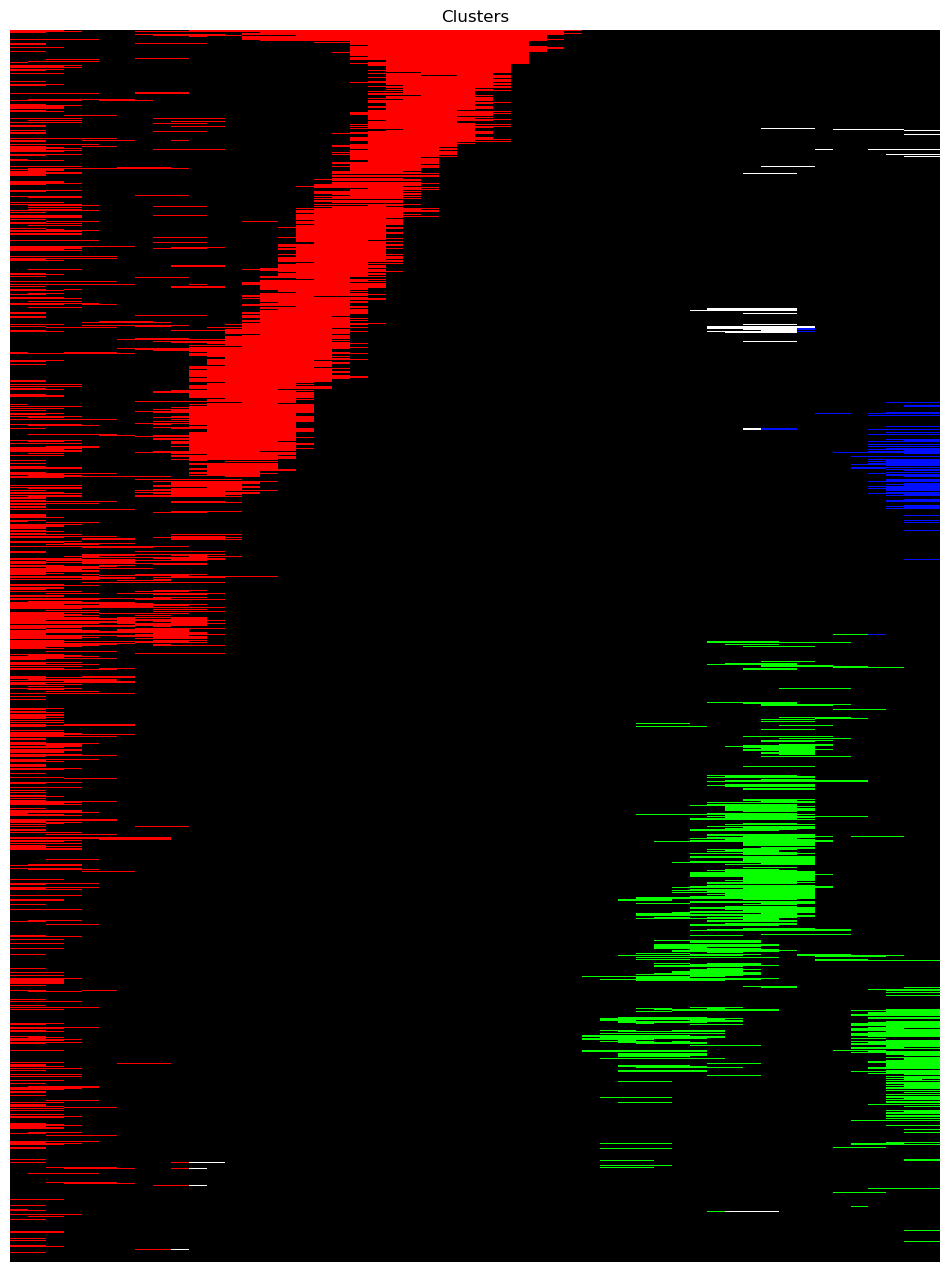

Discarded cluster 0 with R2=0.47910567511914404 (<0.6)
Discarded cluster 1 with R2=0.06692183249096717 (<0.6)
Discarded cluster 2 with R2=0.03118303249641996 (<0.6)


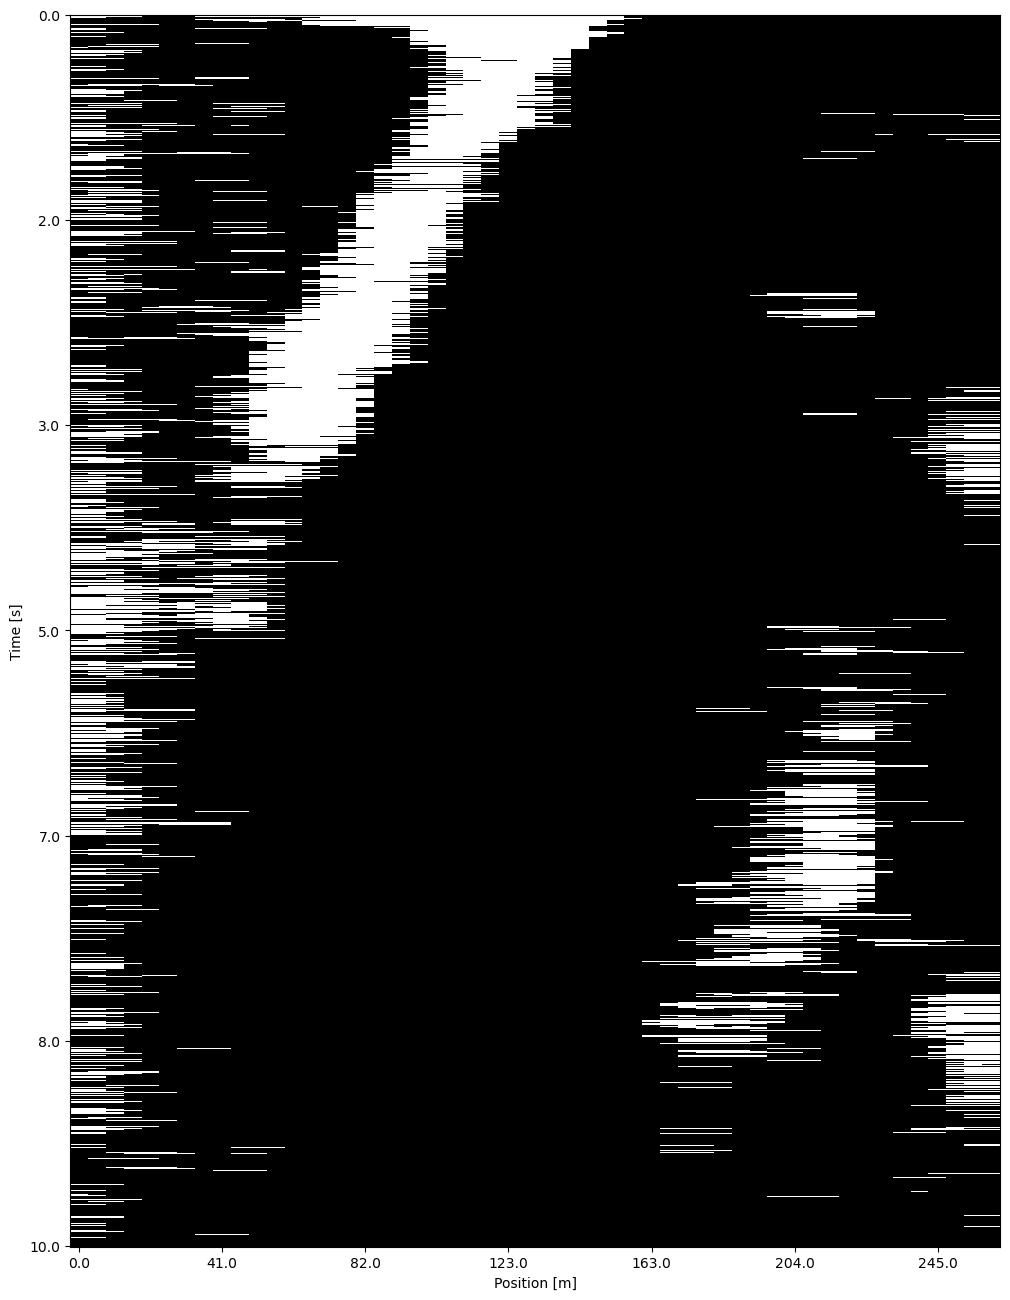

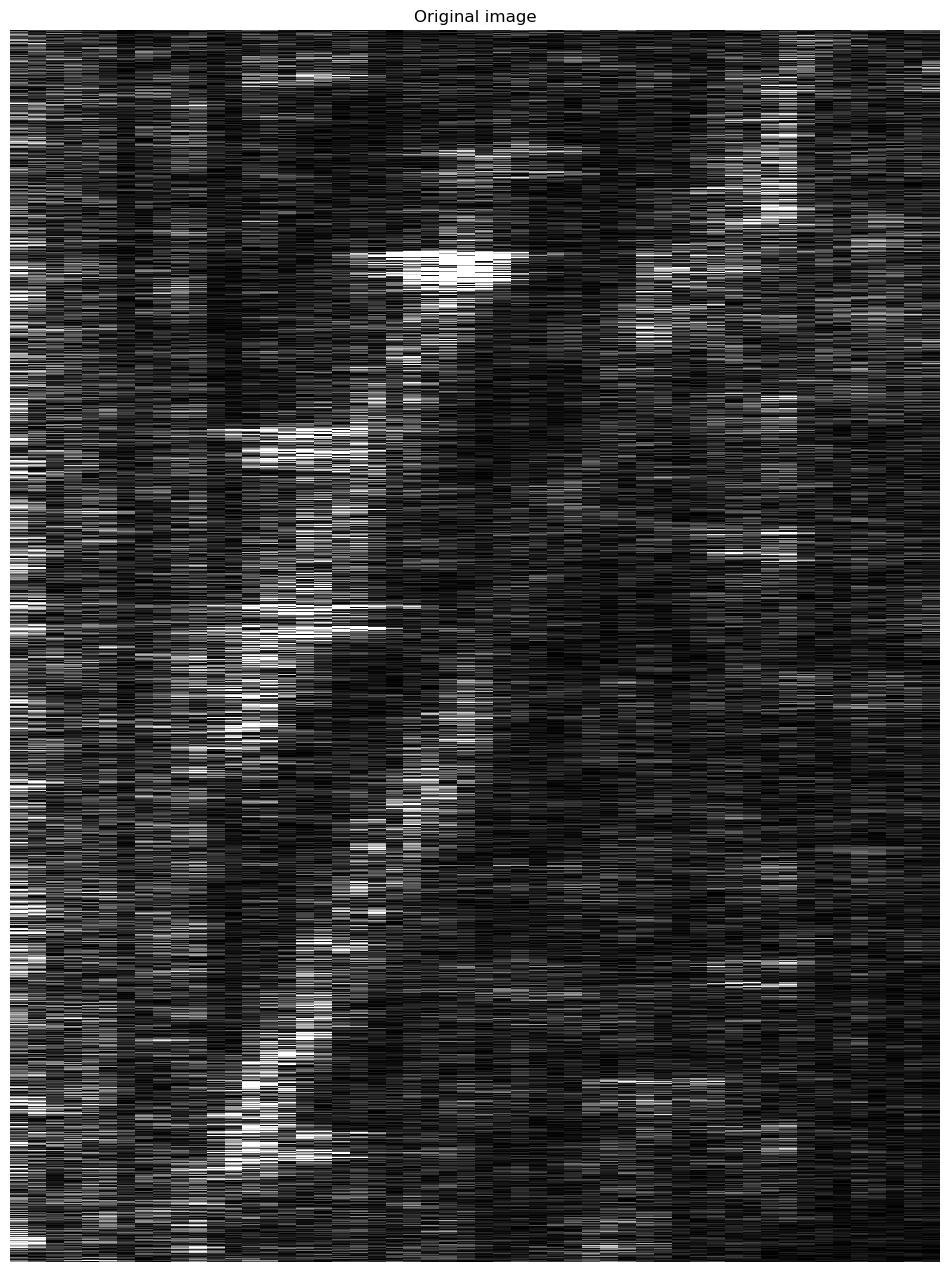

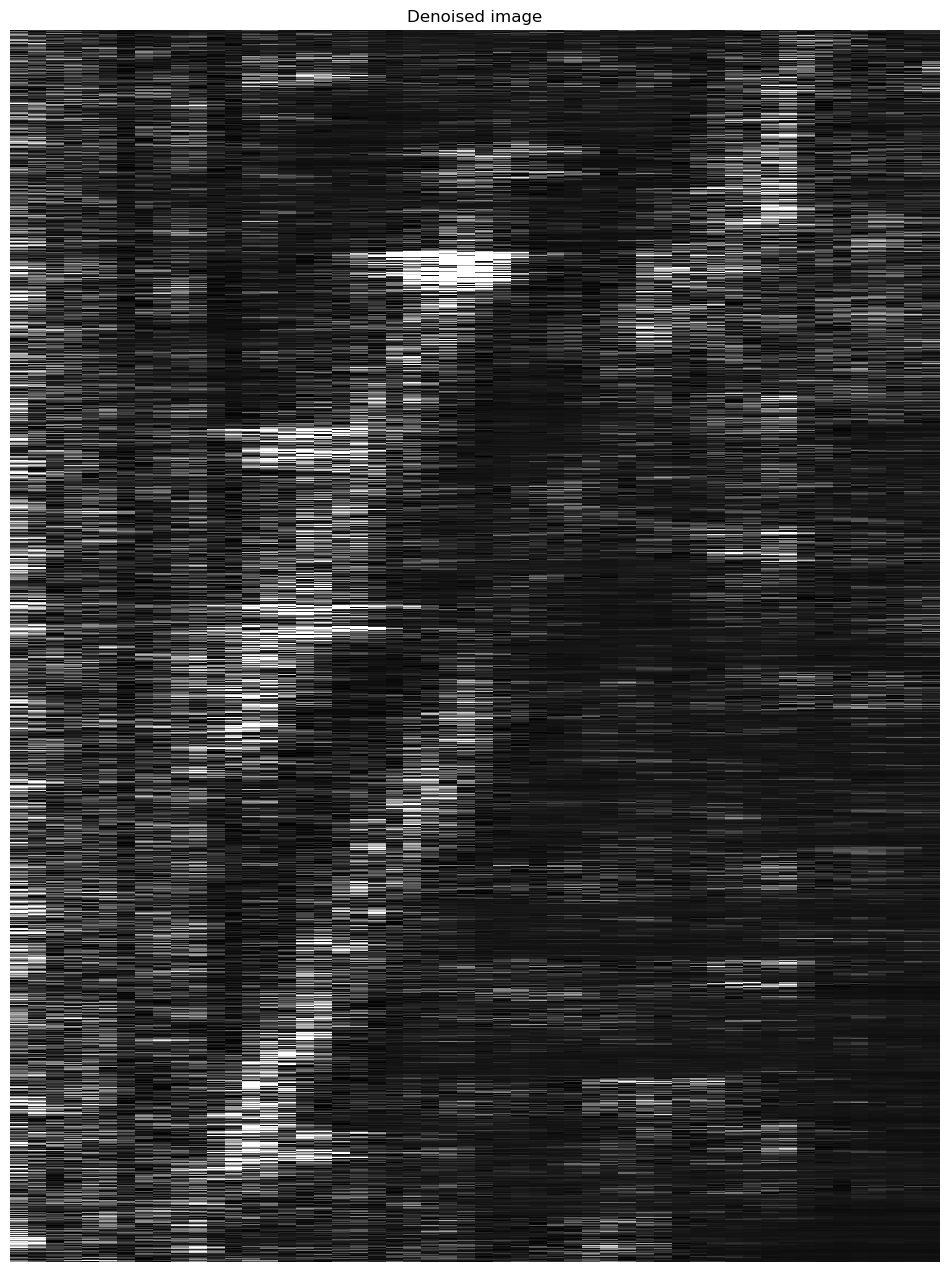

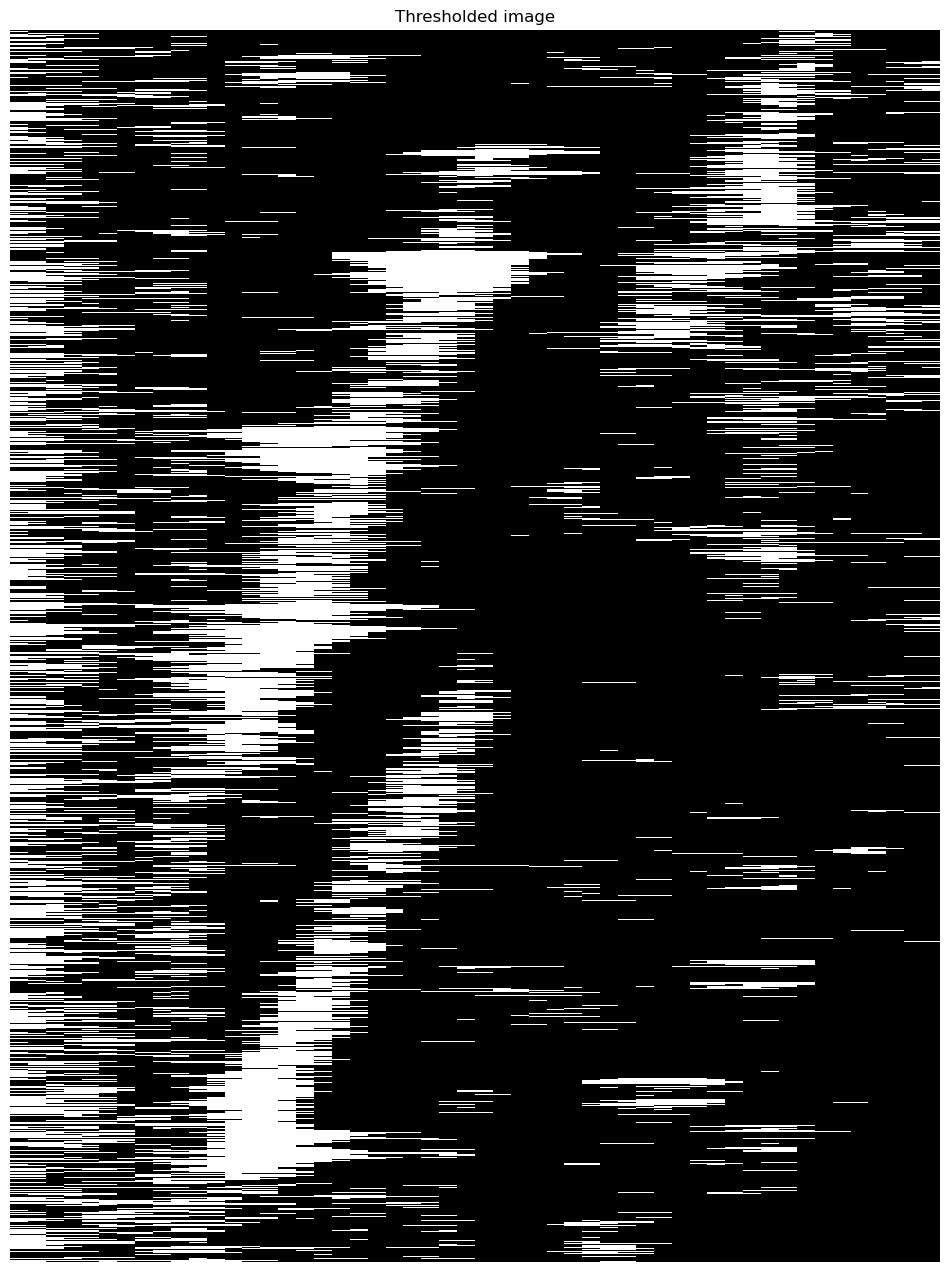

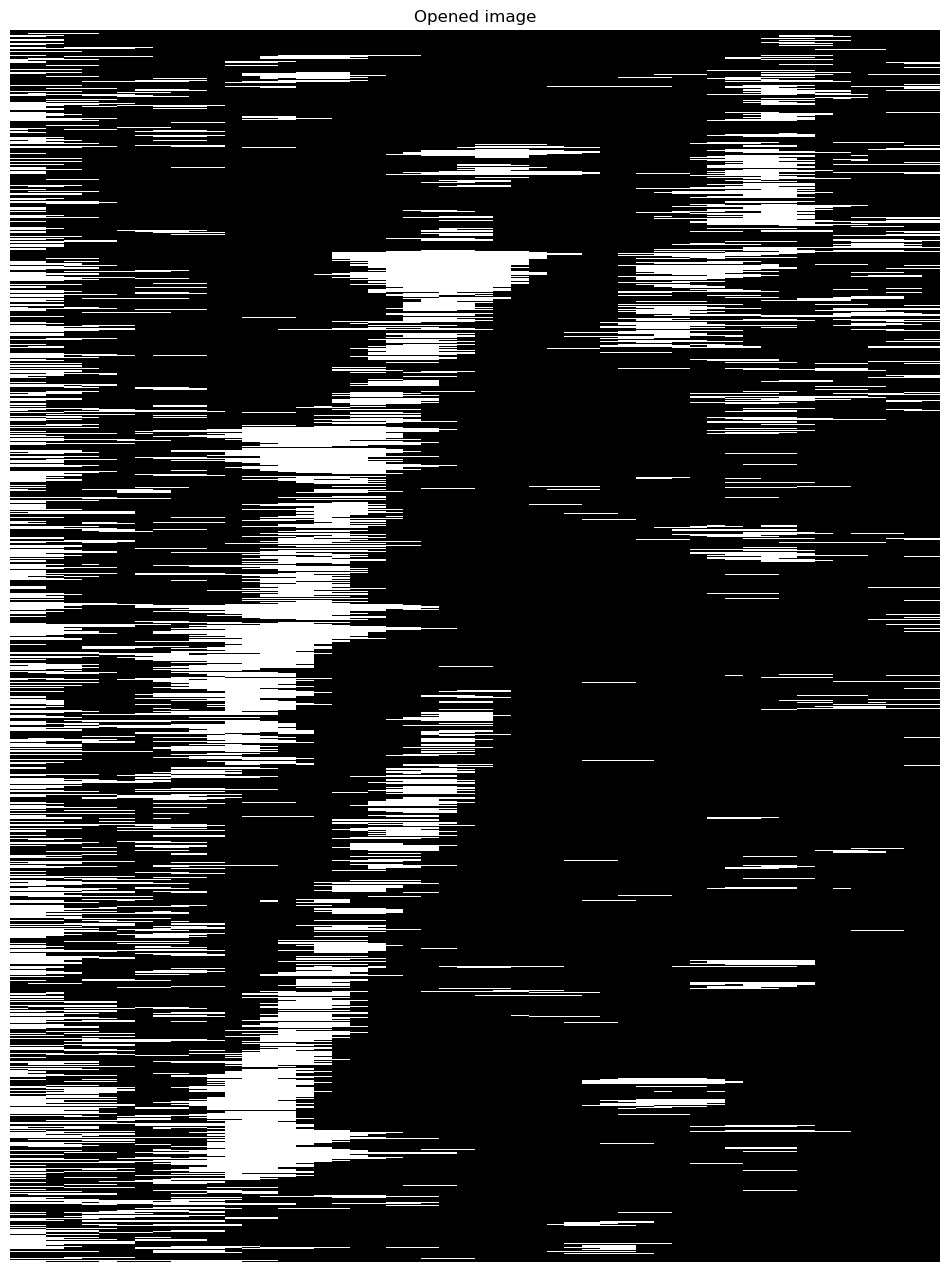

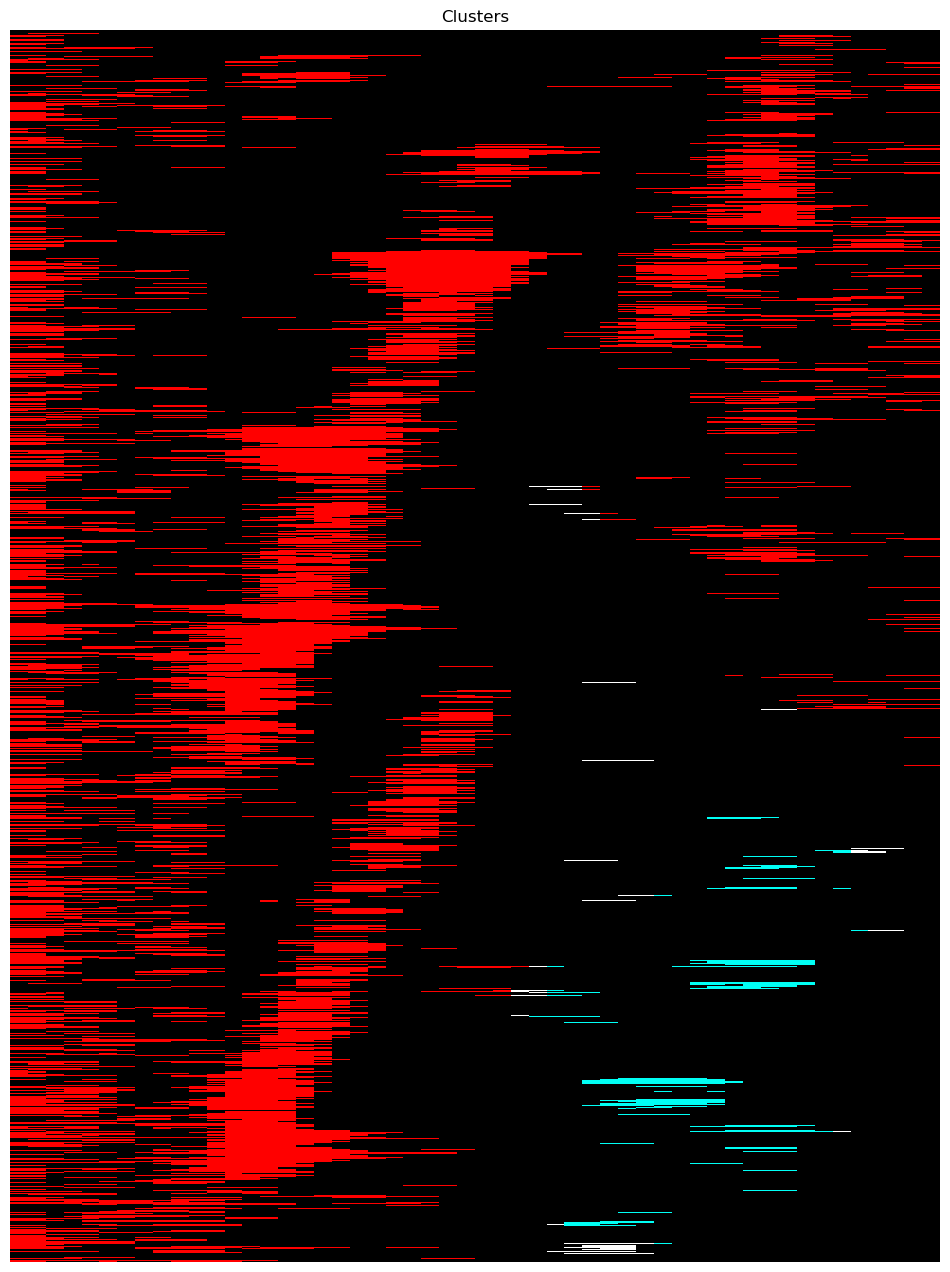

Discarded cluster 0 with R2=0.2165590342659962 (<0.6)
Discarded cluster 1 with R2=0.23816037797382472 (<0.6)


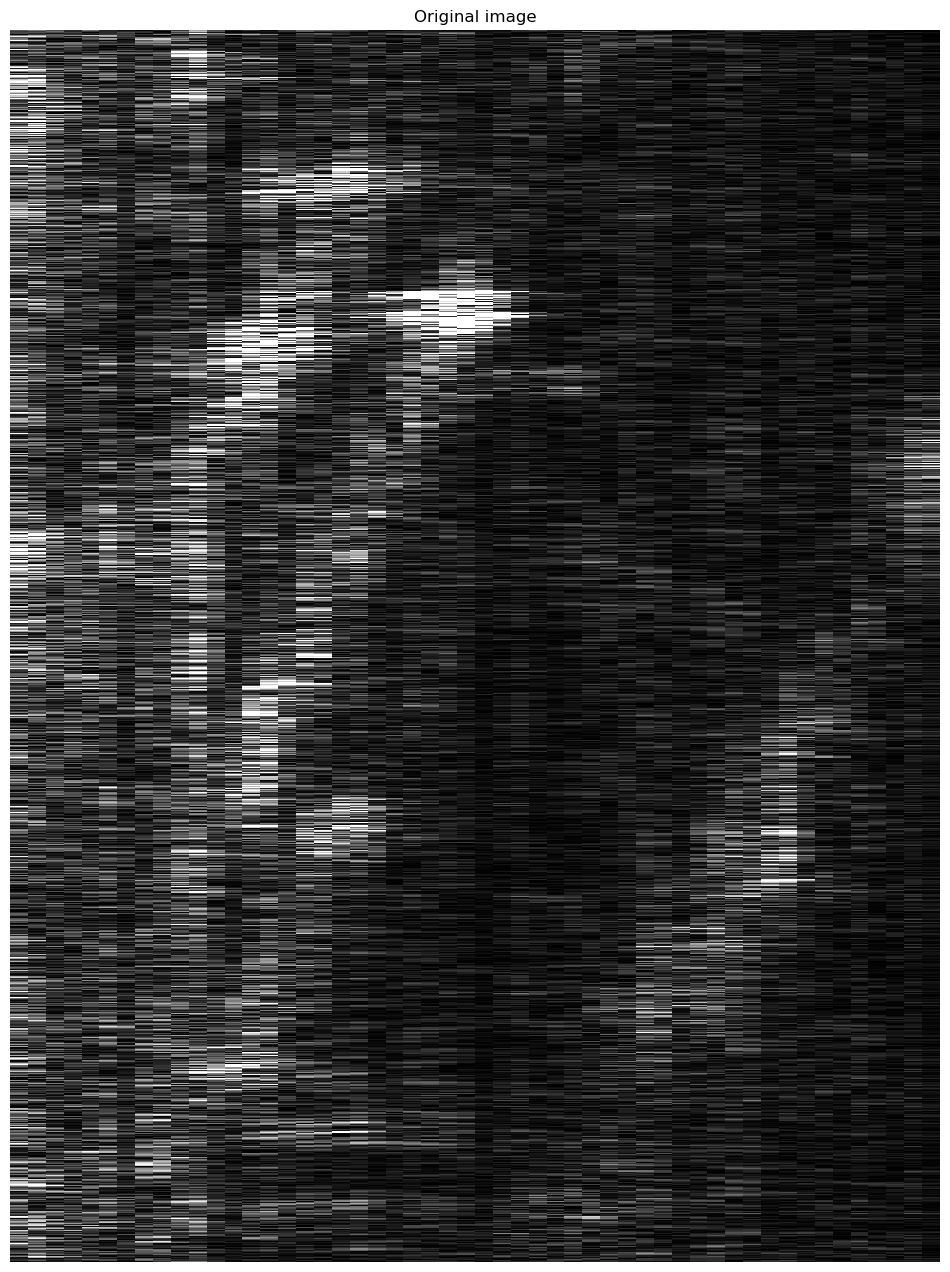

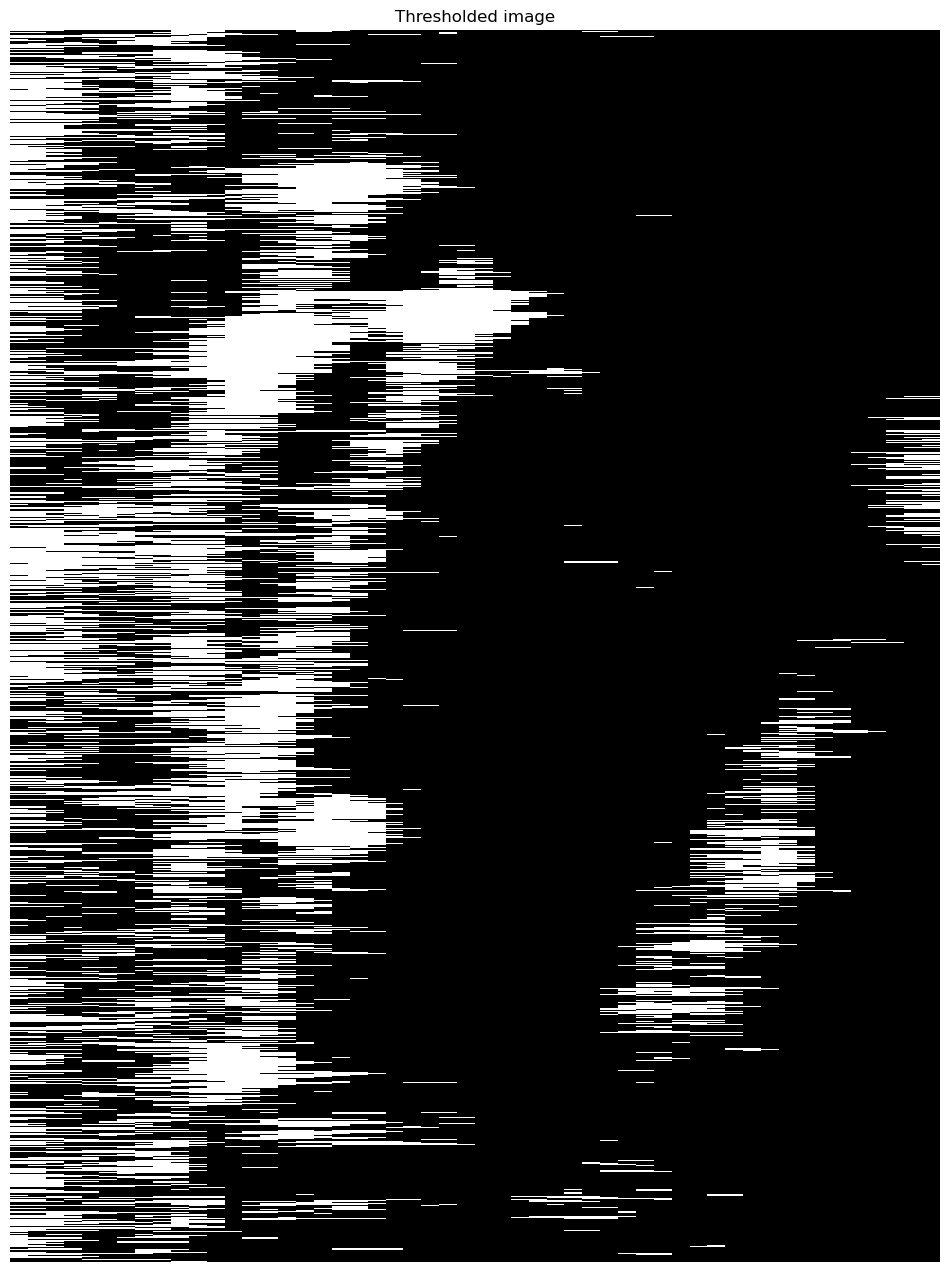

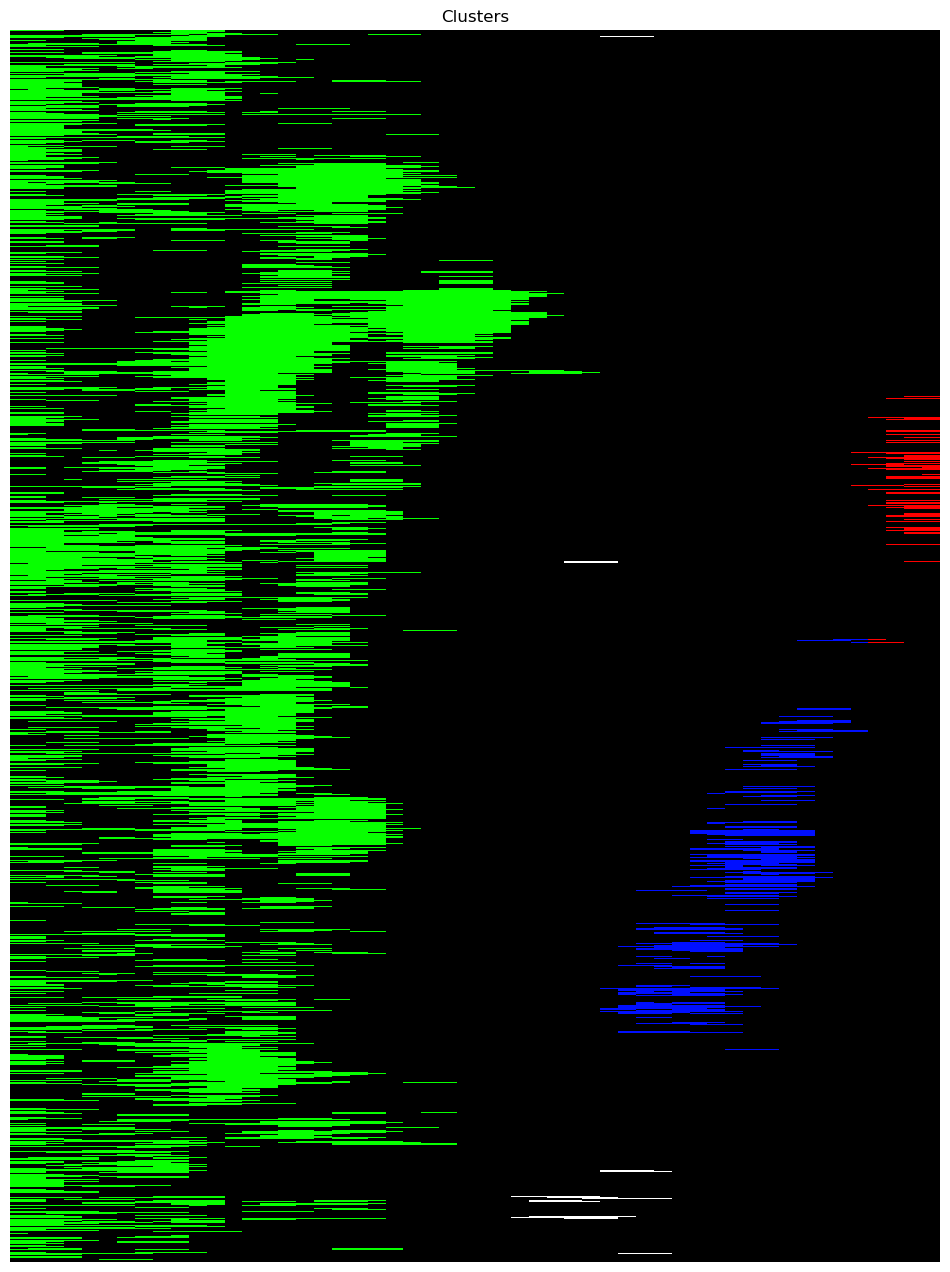

Discarded cluster 0 with R2=0.022879131779311 (<0.6)
Discarded cluster 1 with R2=0.004153899490082602 (<0.6)
Discarded cluster 2 with R2=0.5846740136348918 (<0.6)


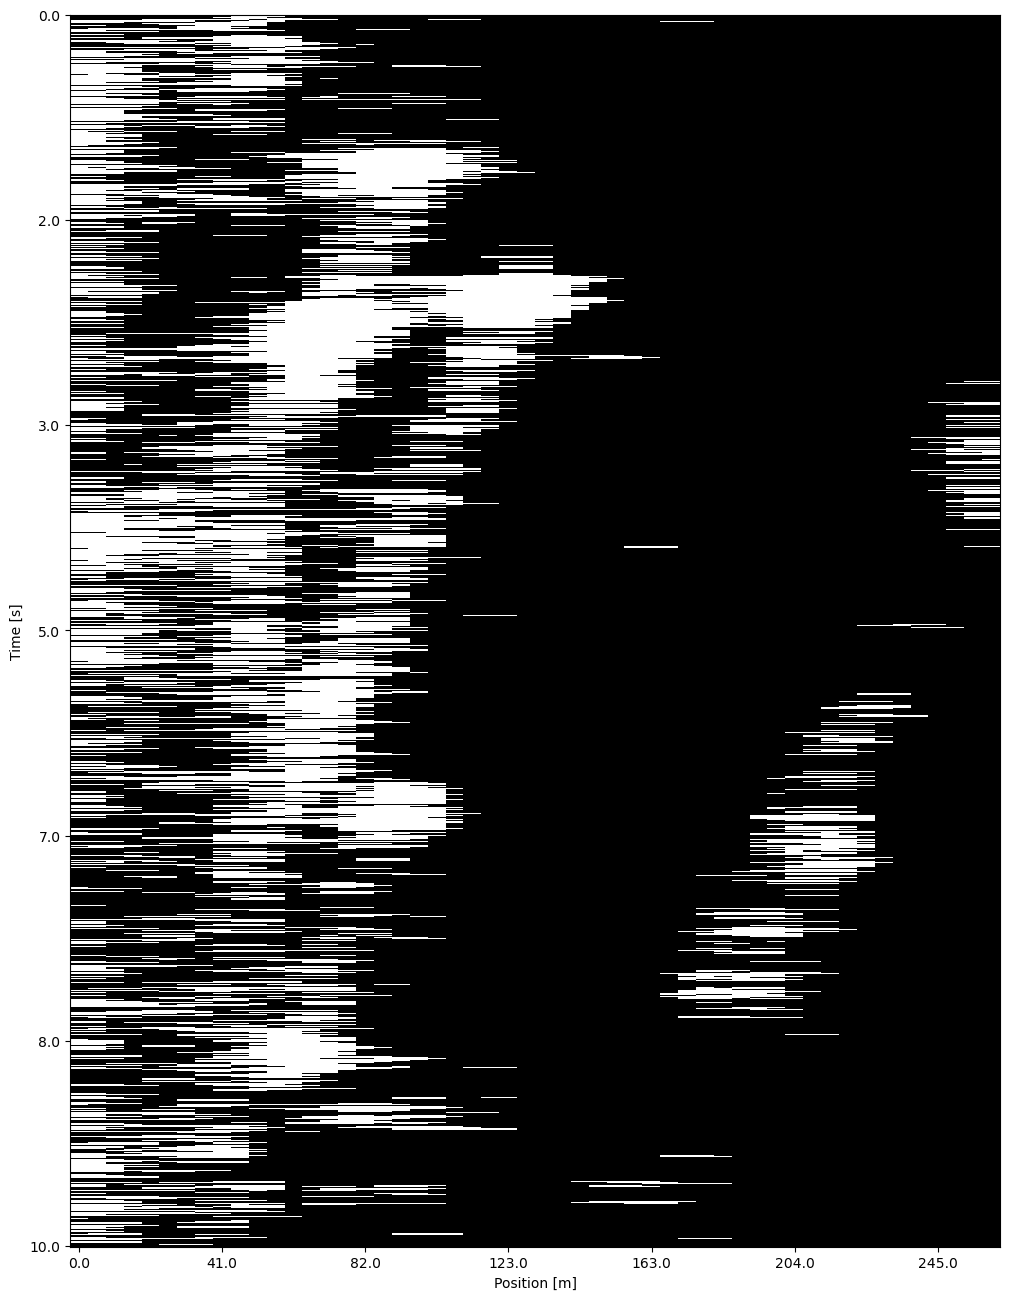

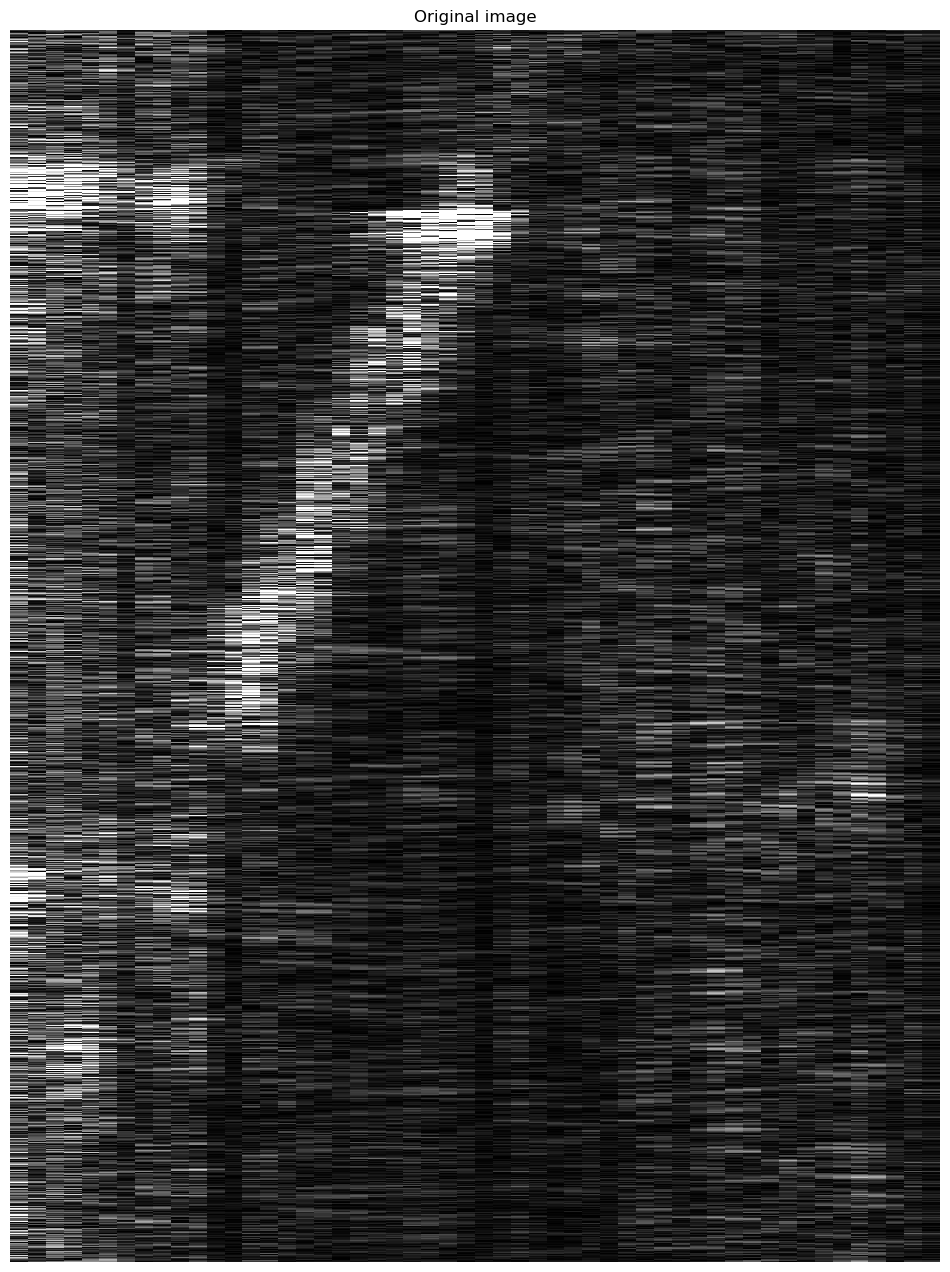

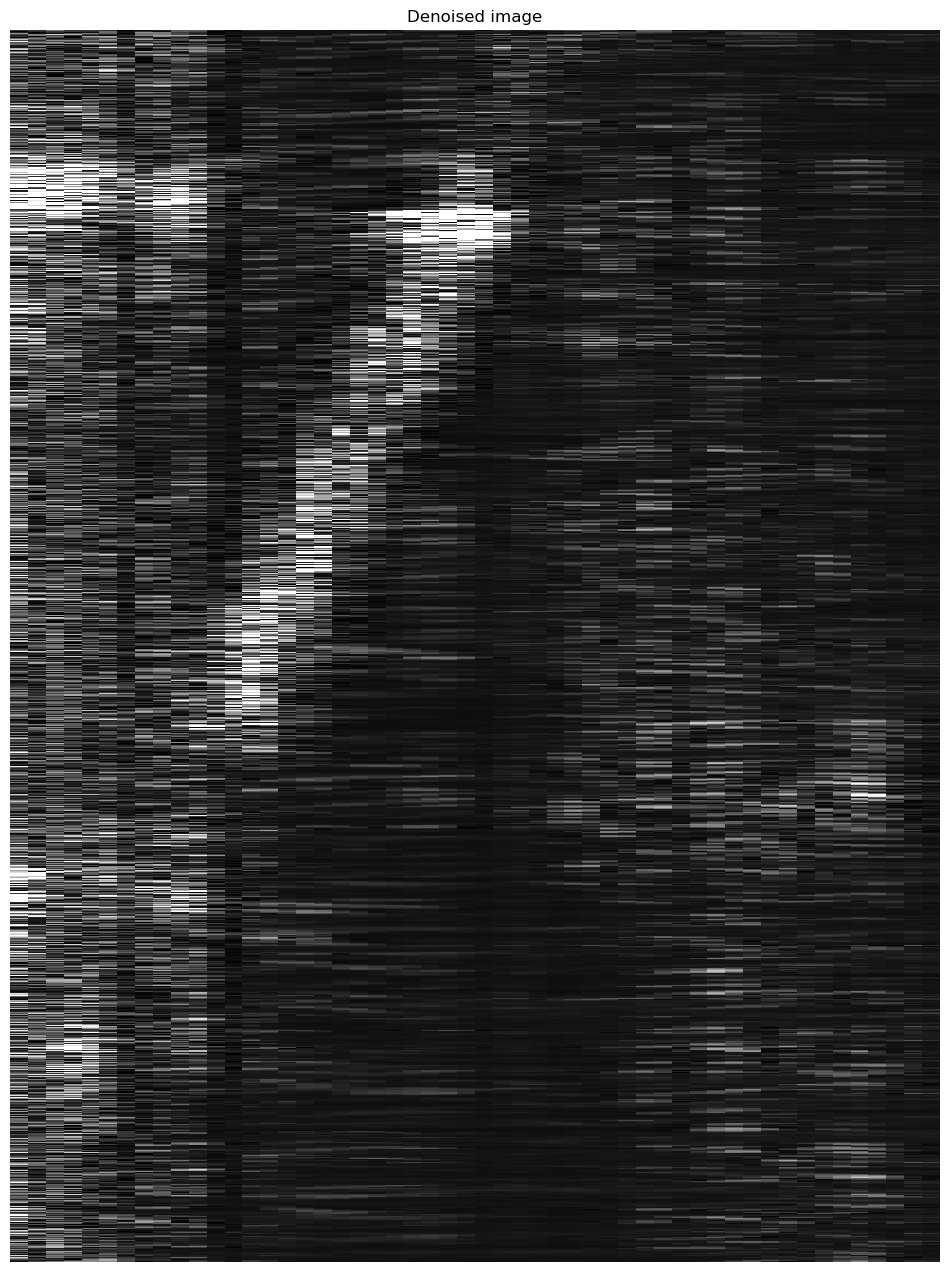

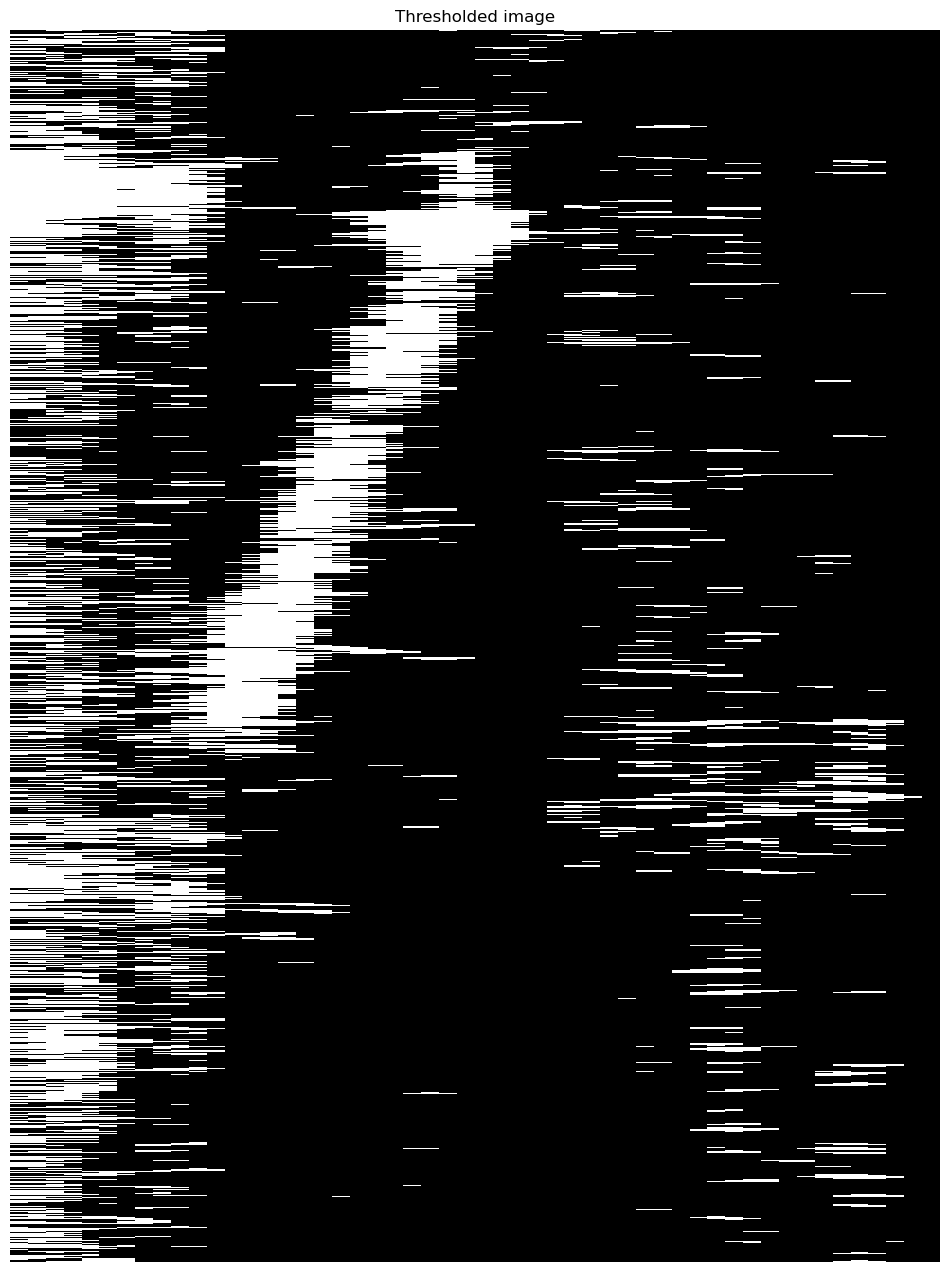

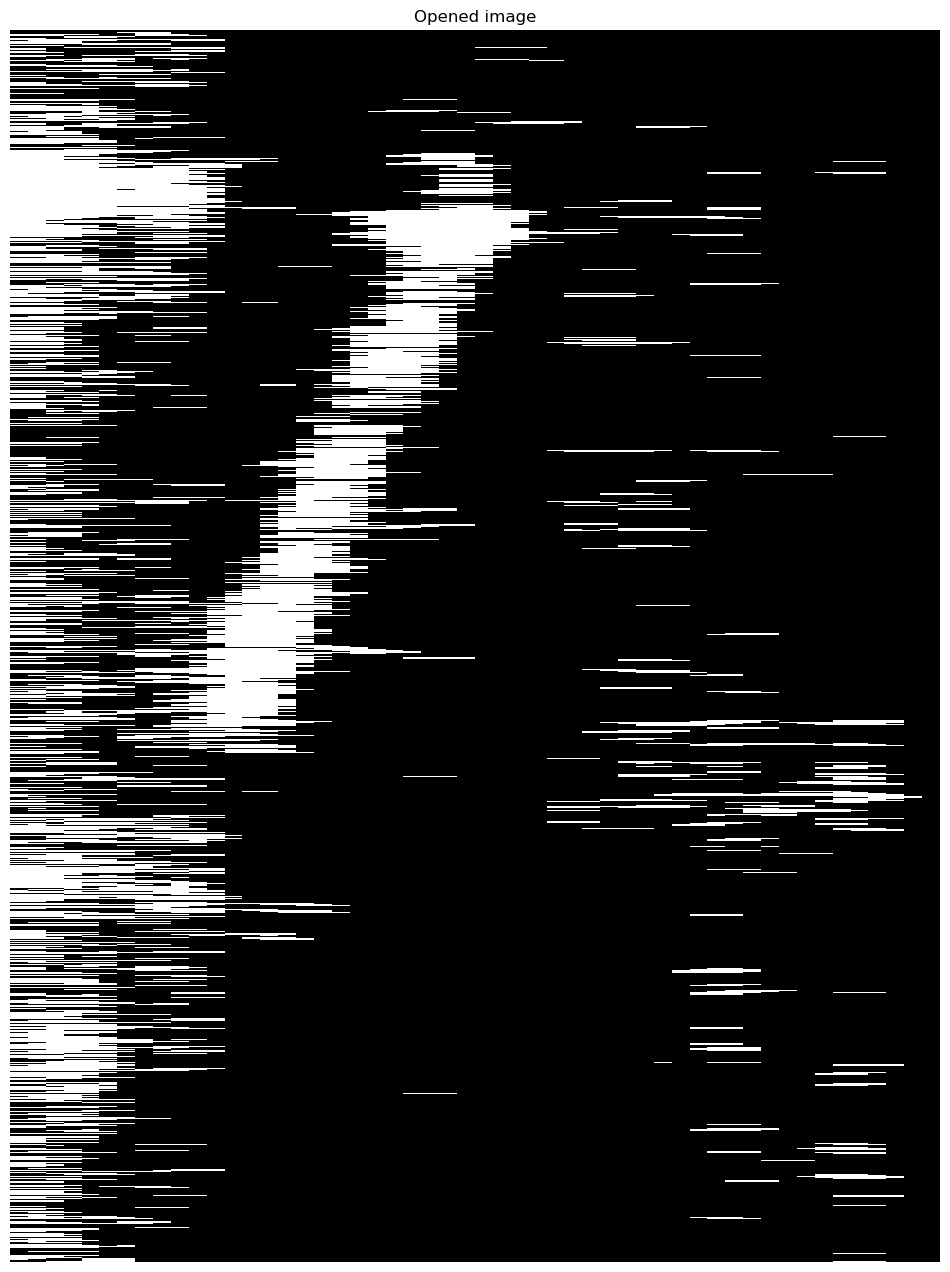

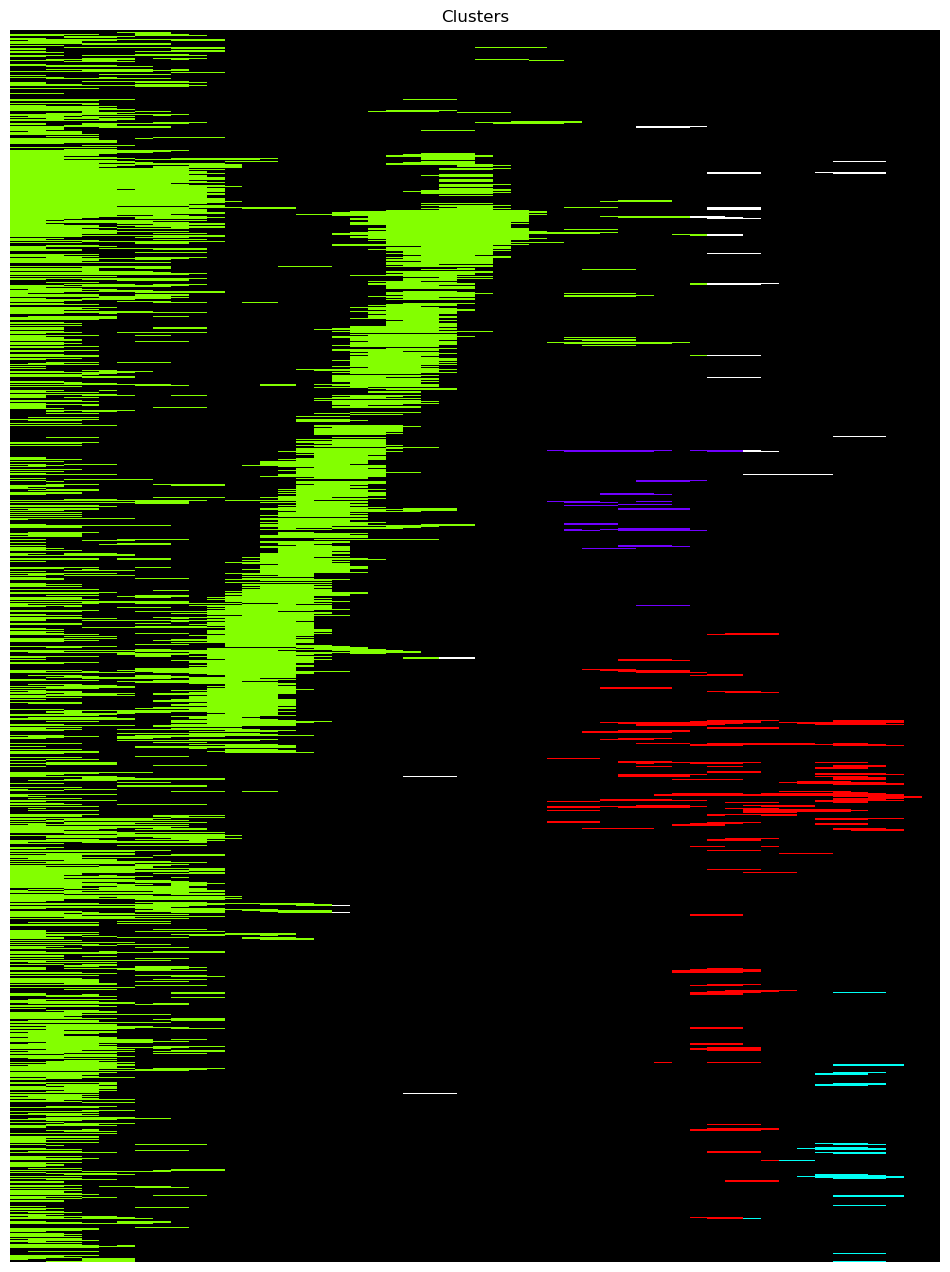

Discarded cluster 0 with R2=0.1199636851615754 (<0.6)
Discarded cluster 1 with R2=0.0073037398394210085 (<0.6)
Discarded cluster 2 with R2=0.0004038726677219051 (<0.6)
Discarded cluster 3 with R2=0.004044469484640212 (<0.6)


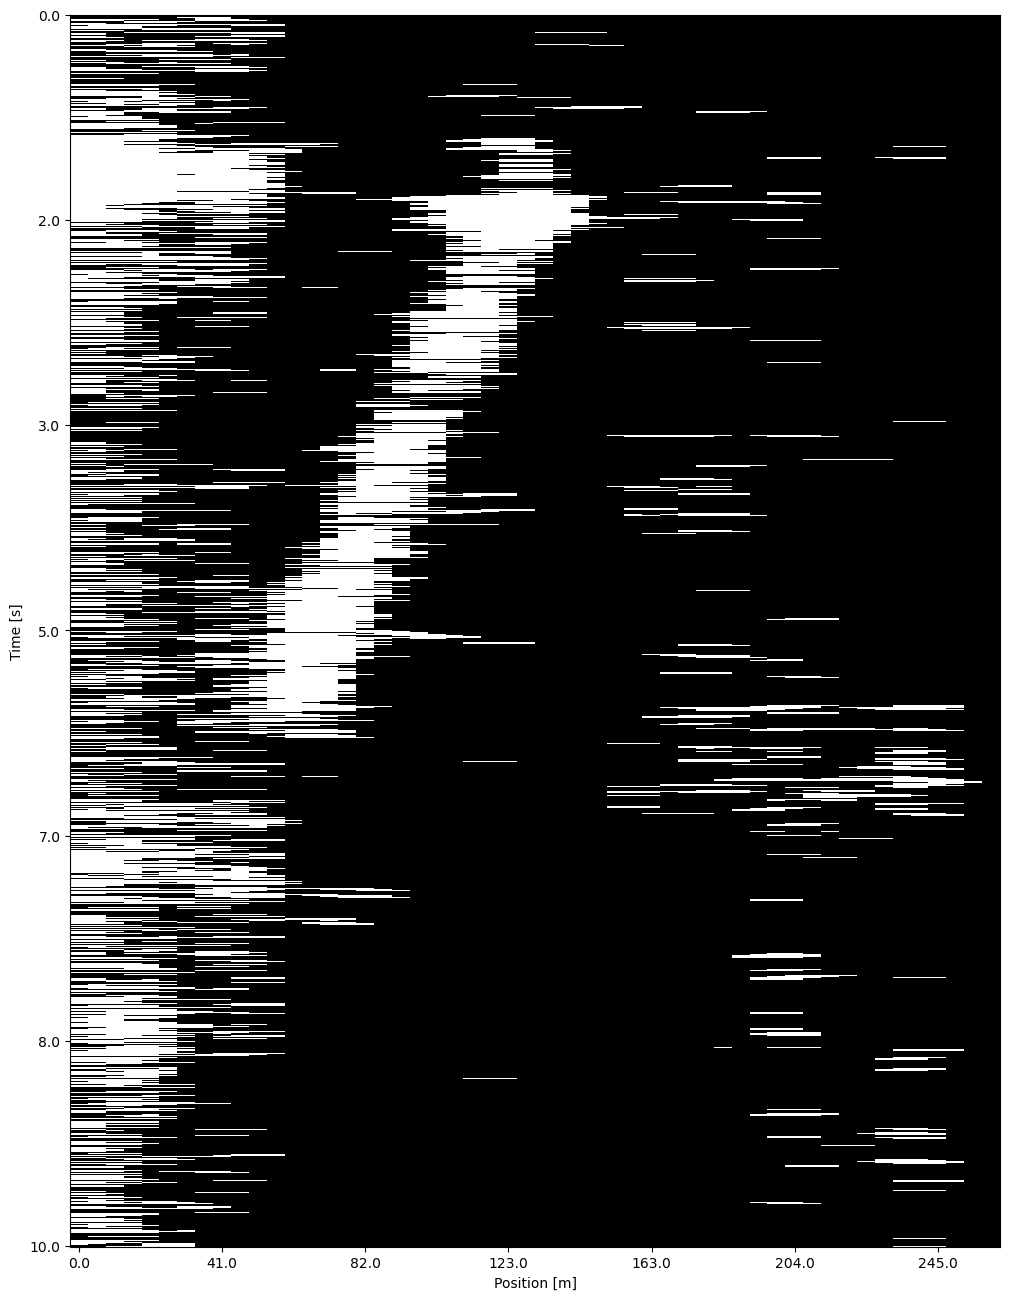

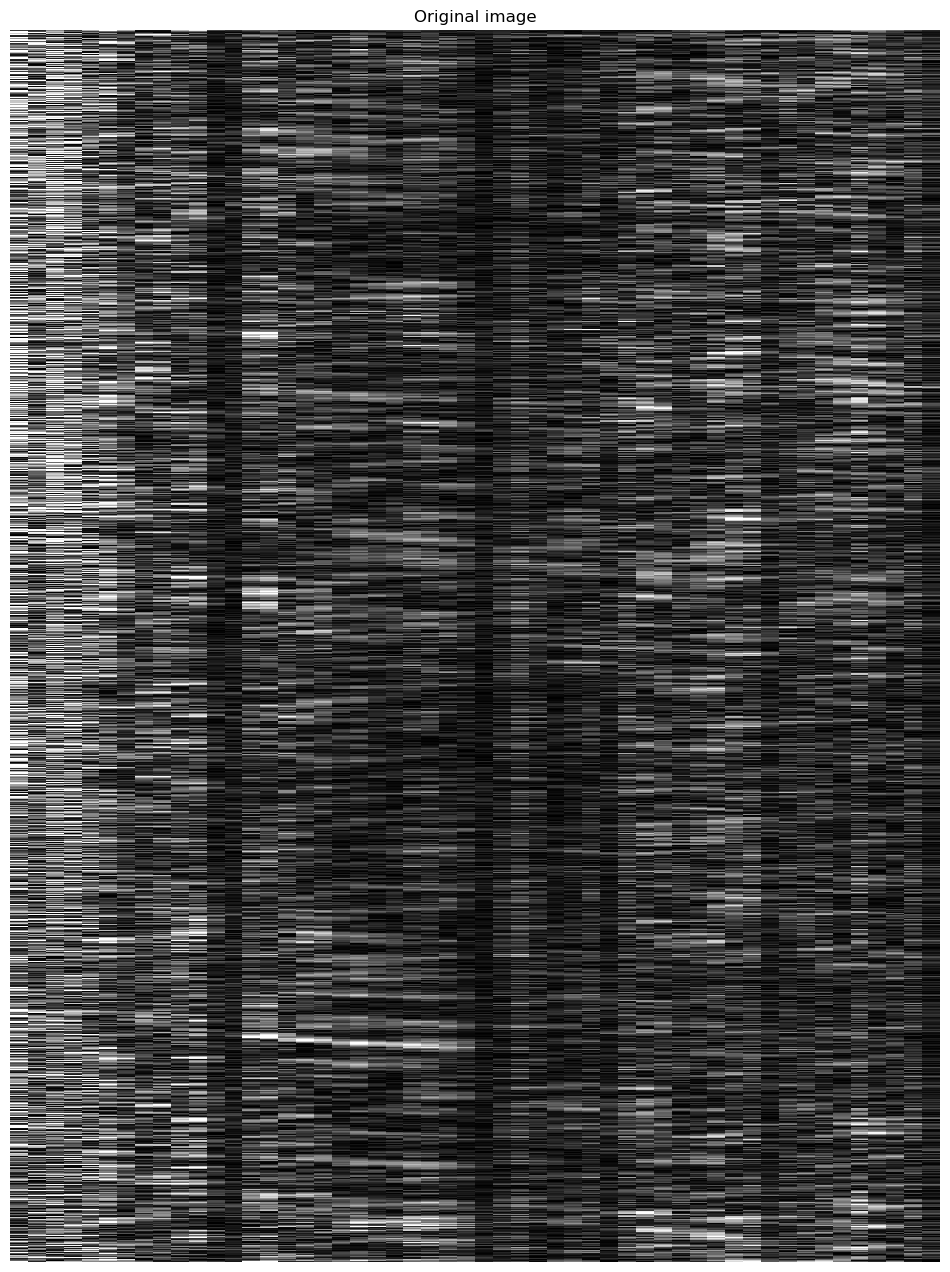

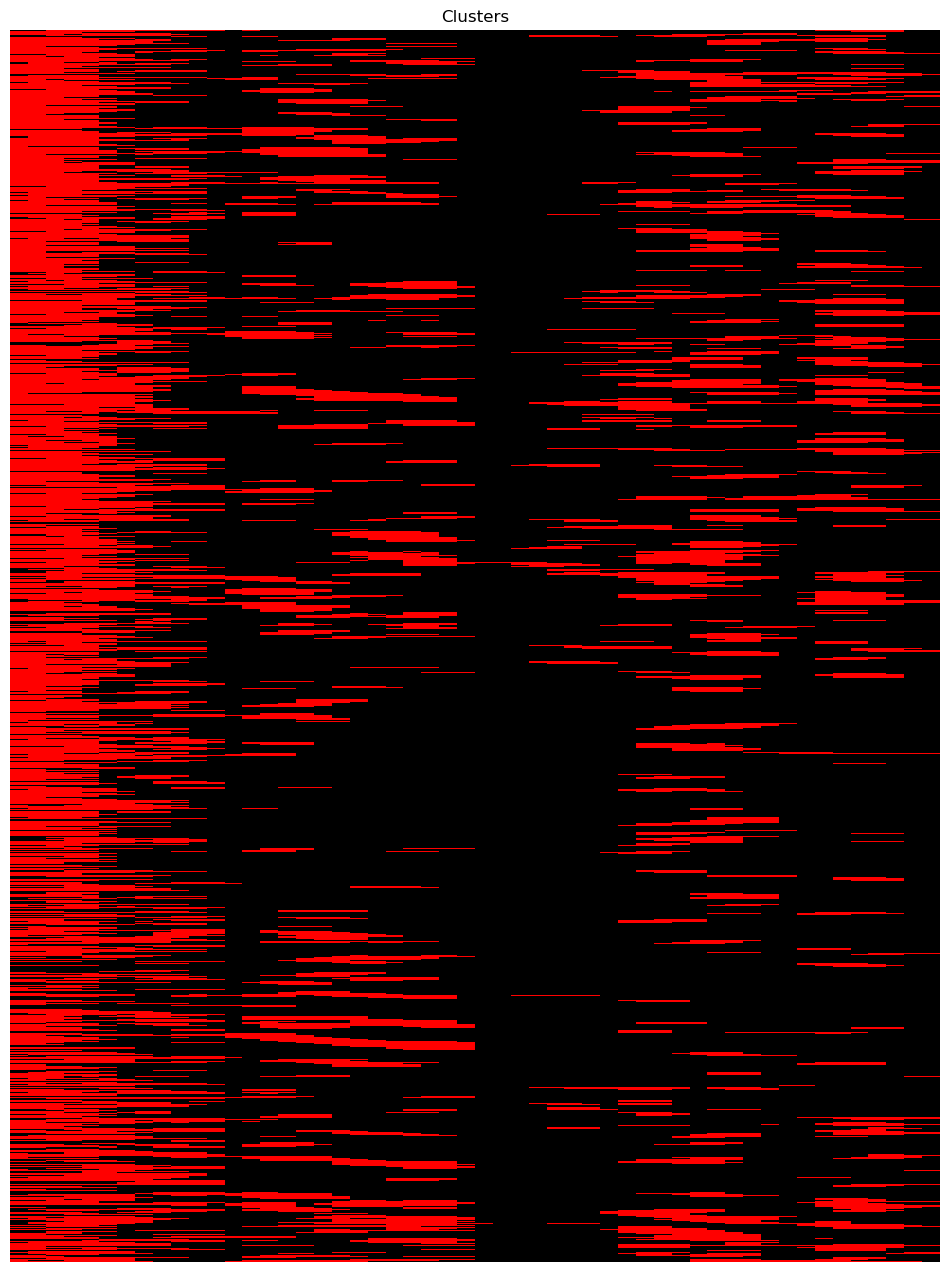

Discarded cluster 0 with R2=0.0019423155883638854 (<0.6)


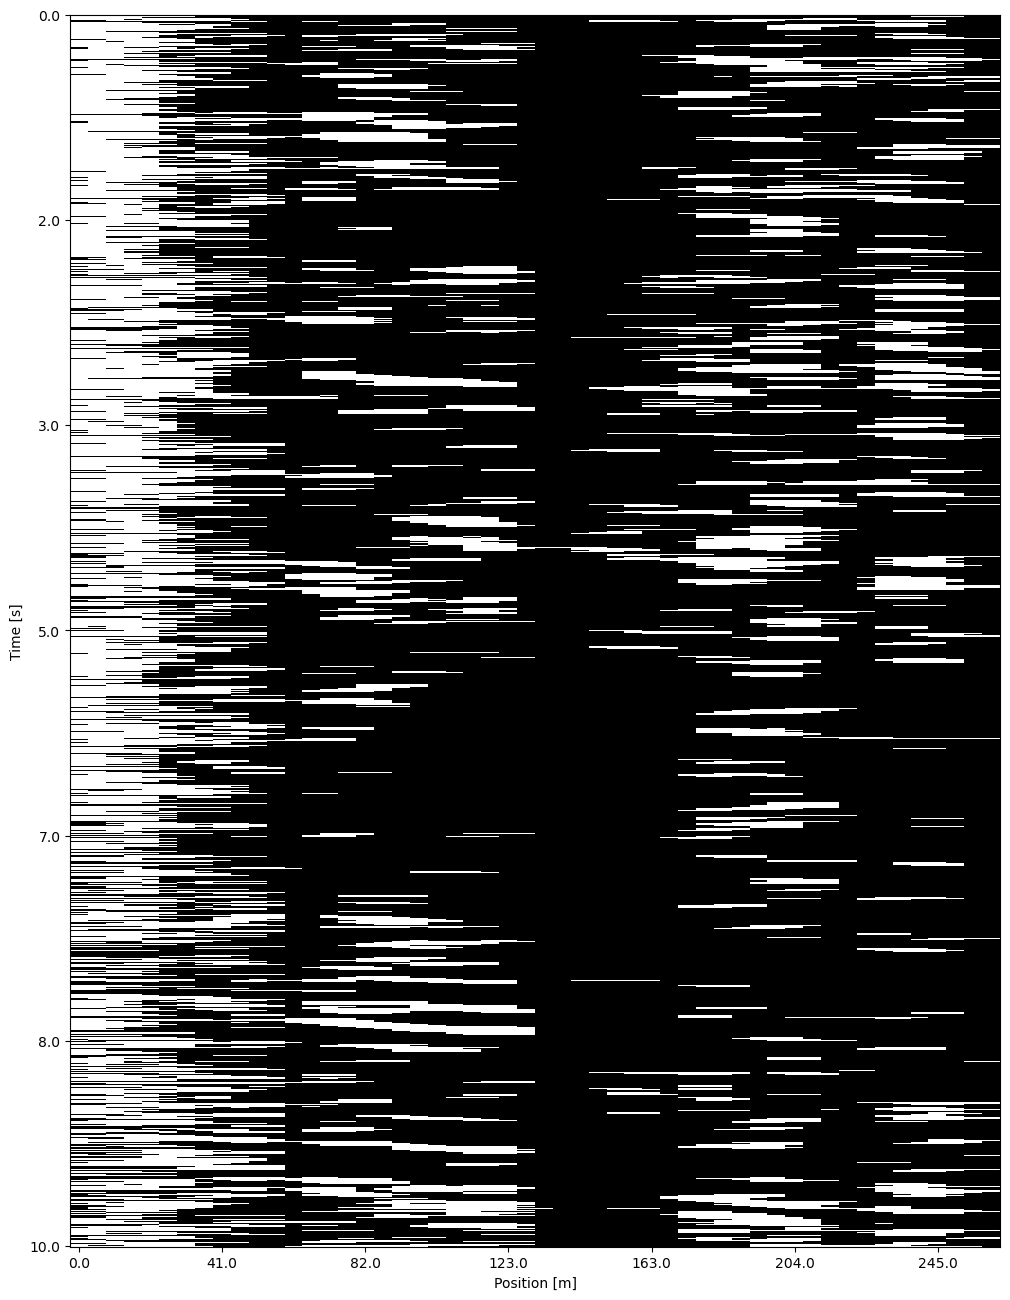

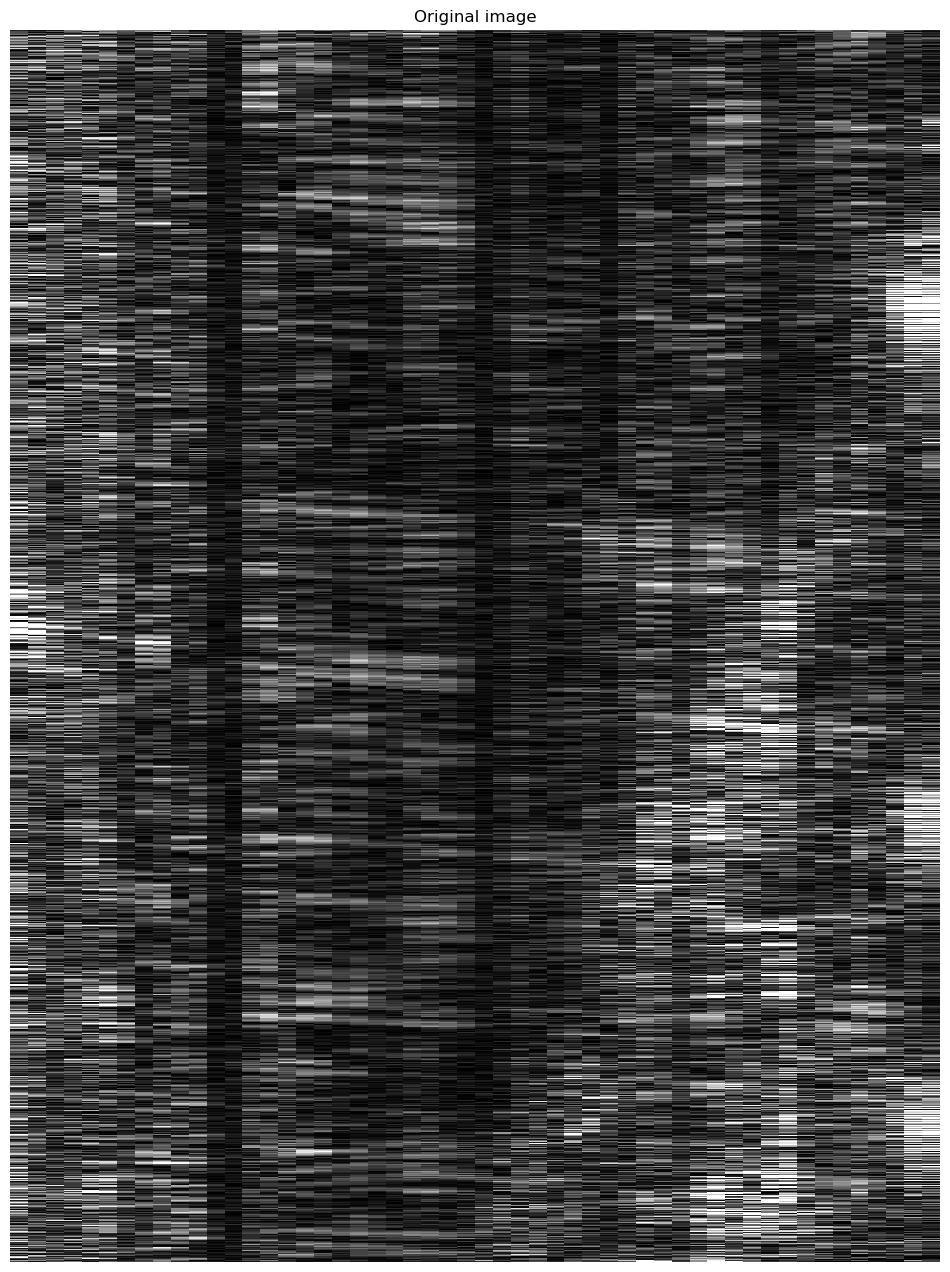

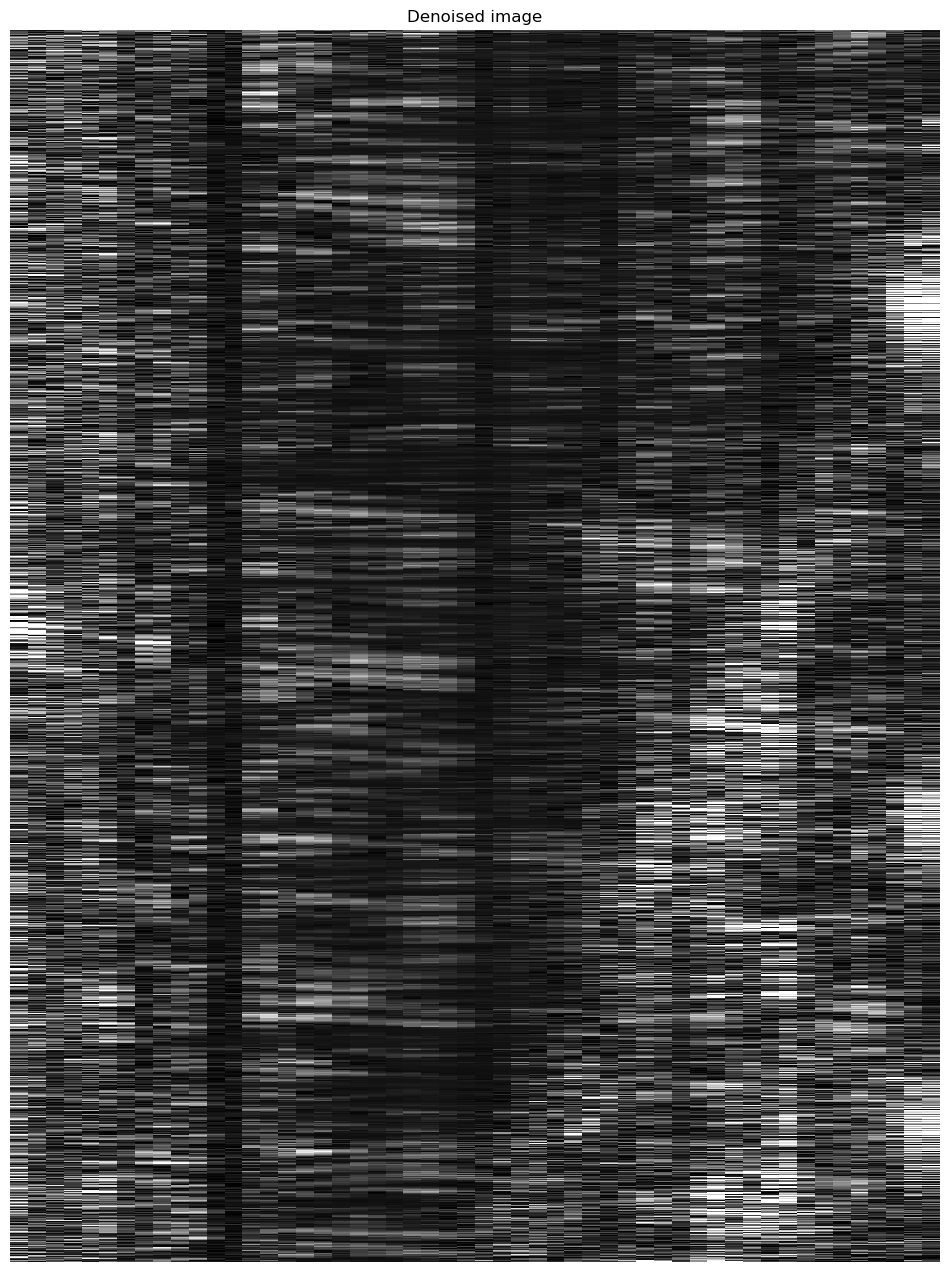

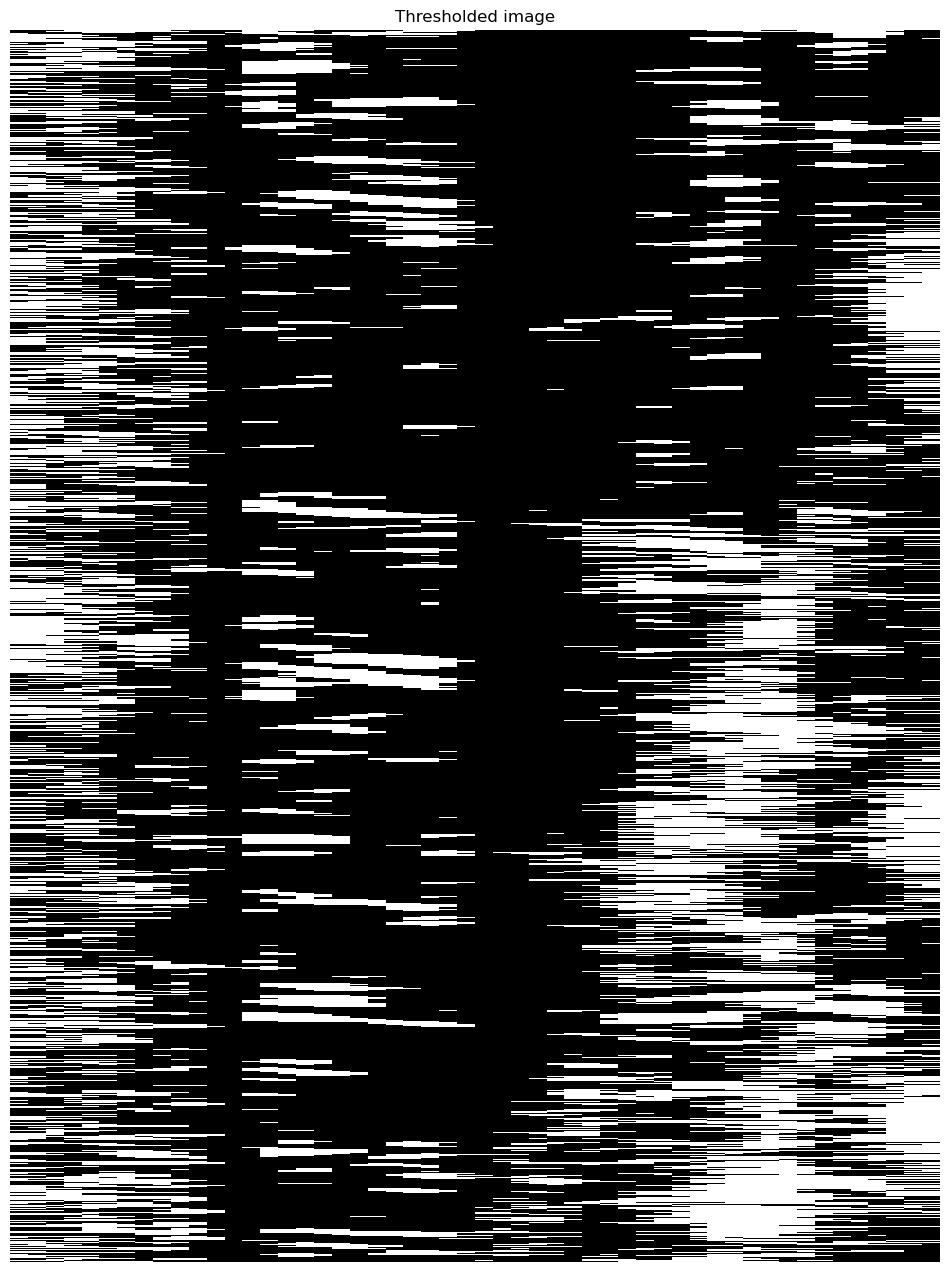

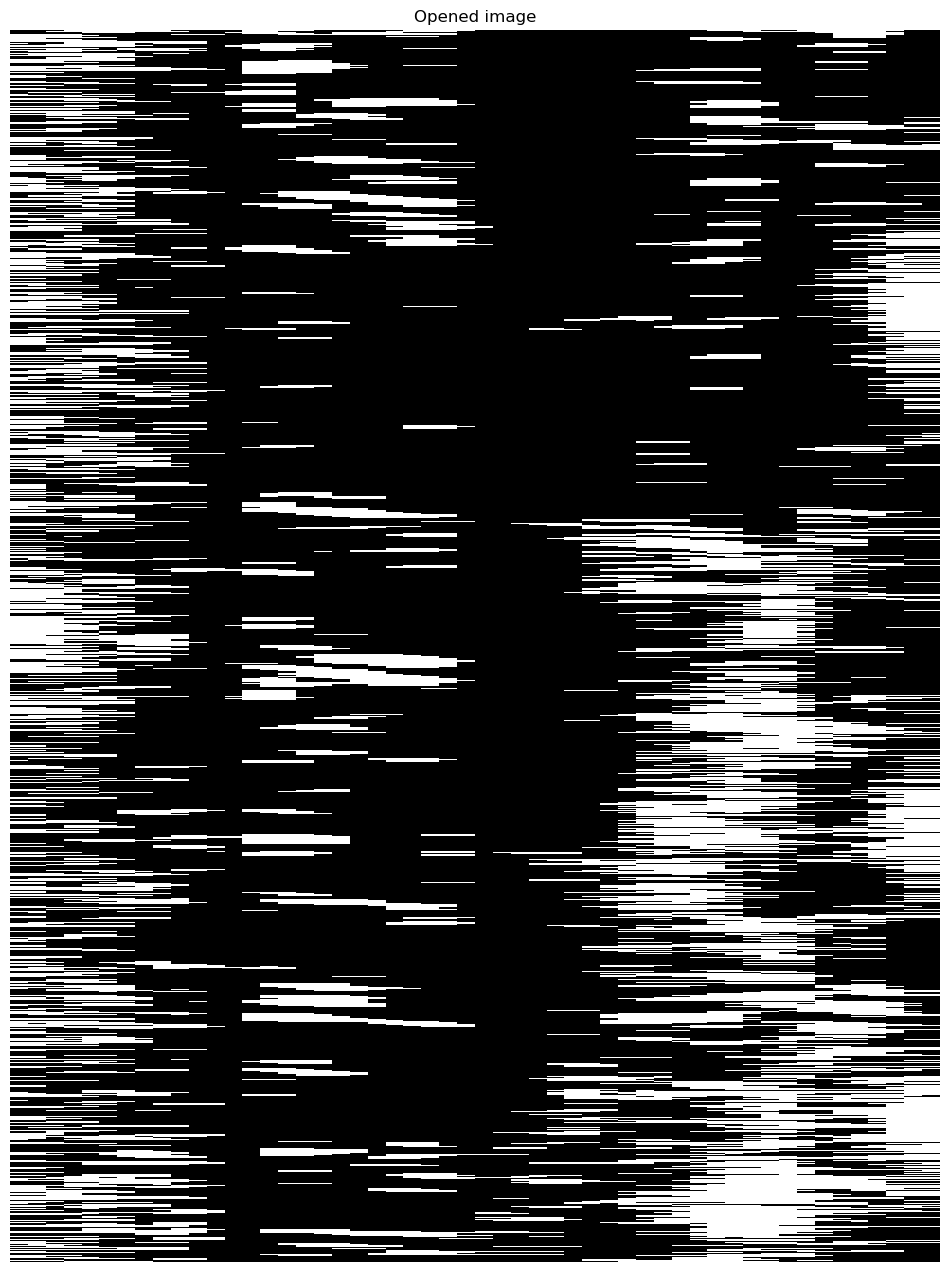

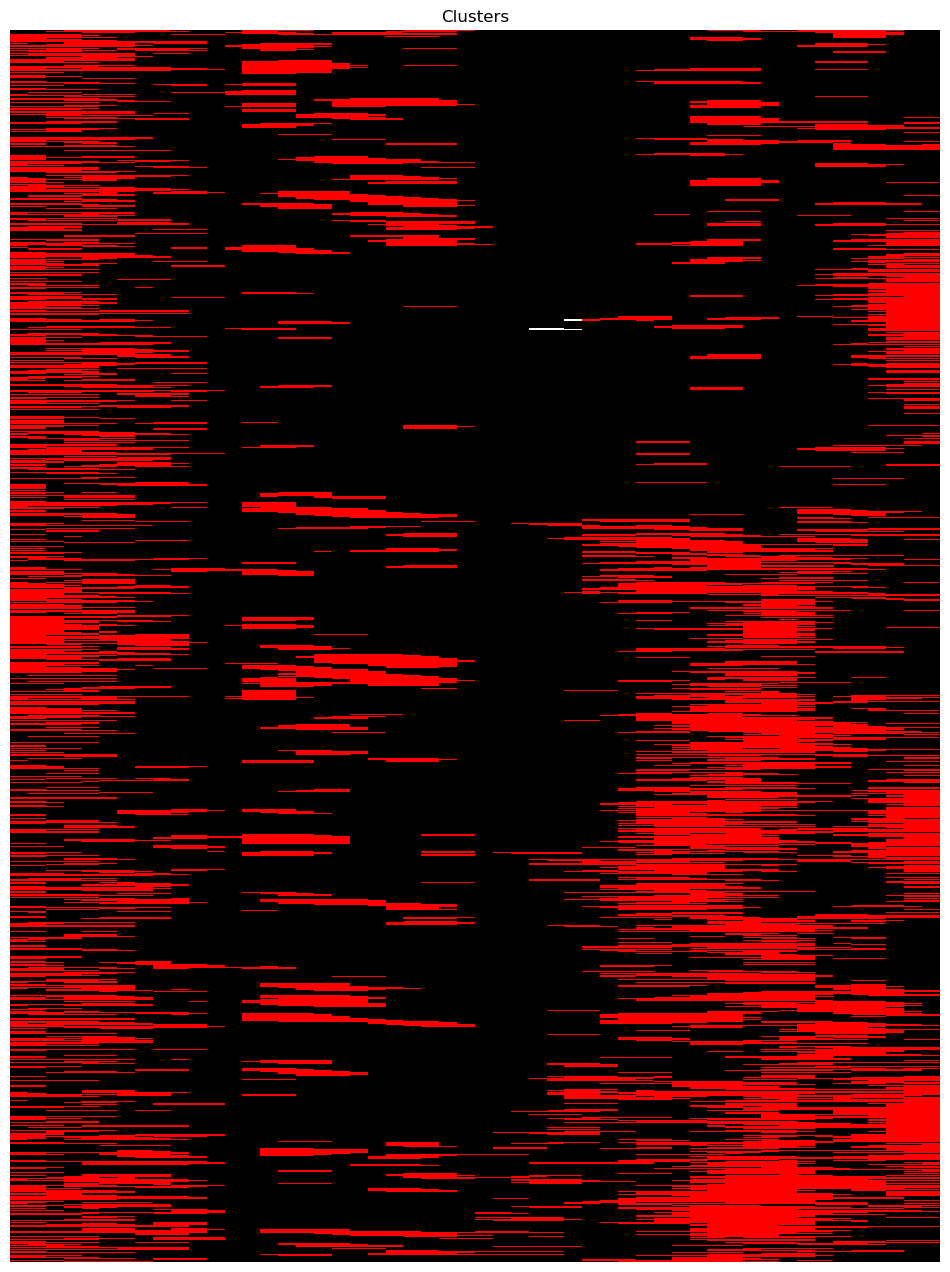

Discarded cluster 0 with R2=0.043159917102280065 (<0.6)


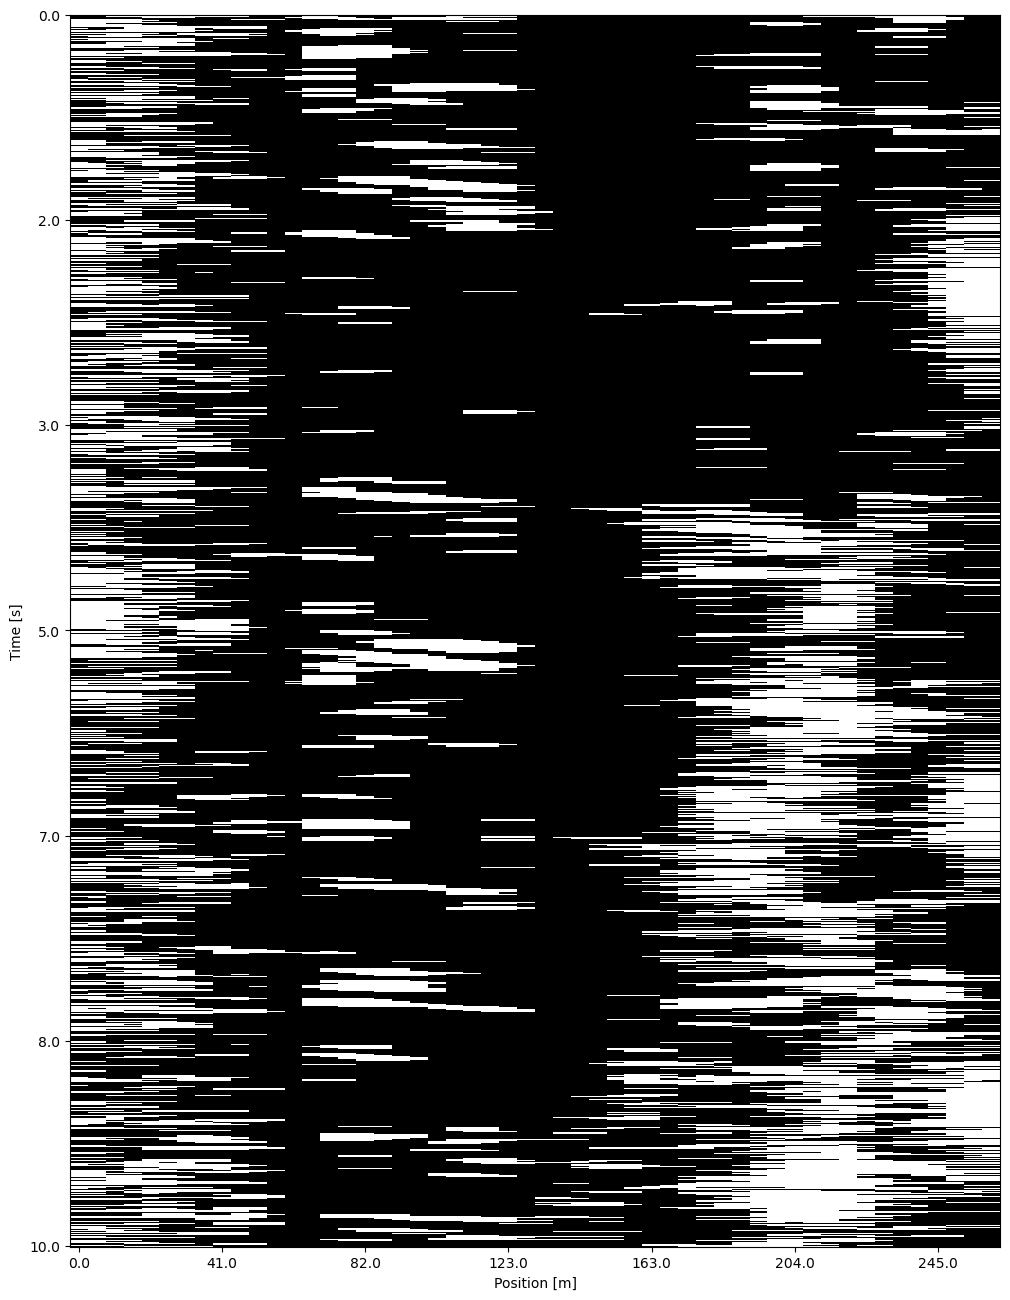

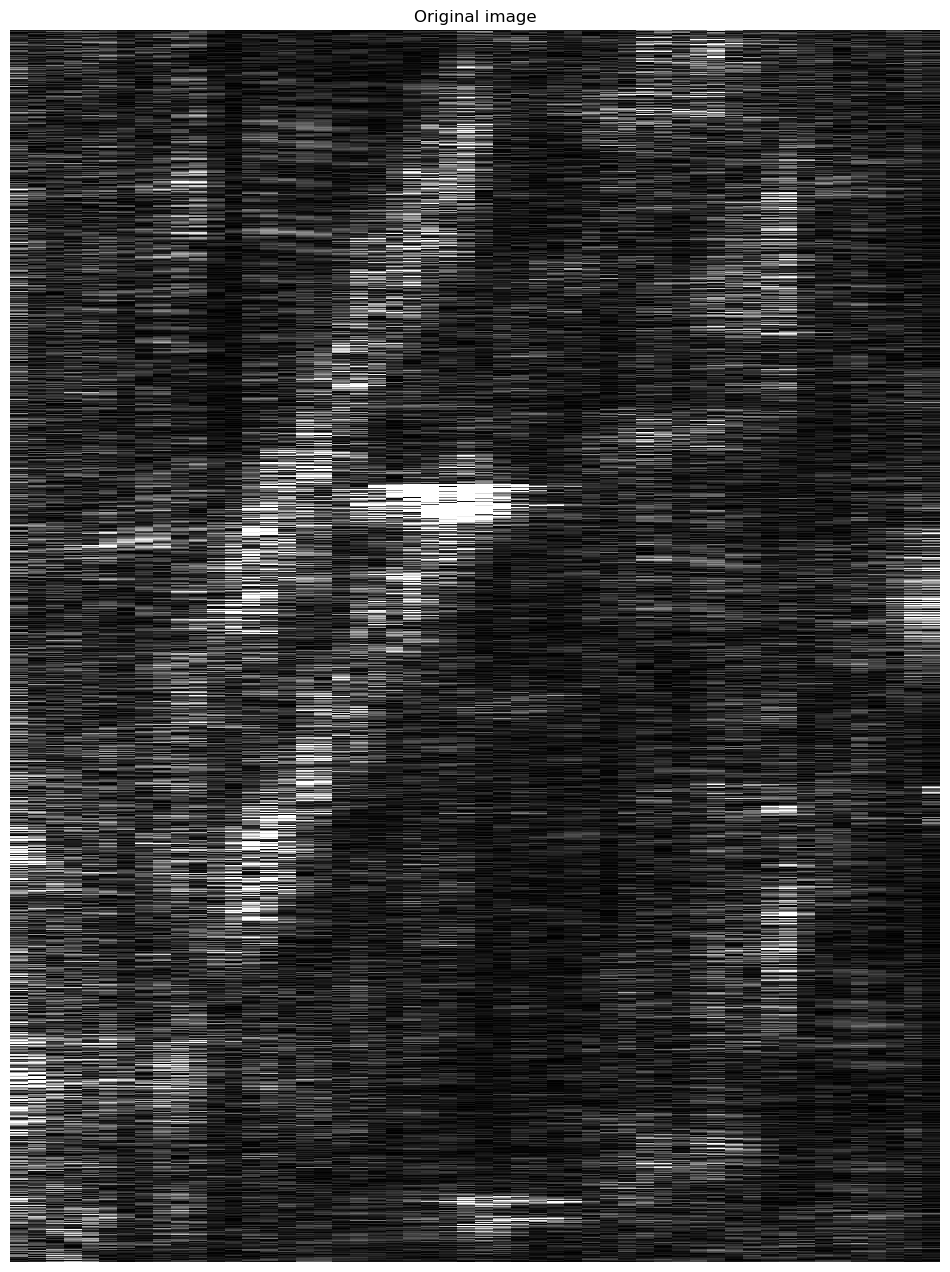

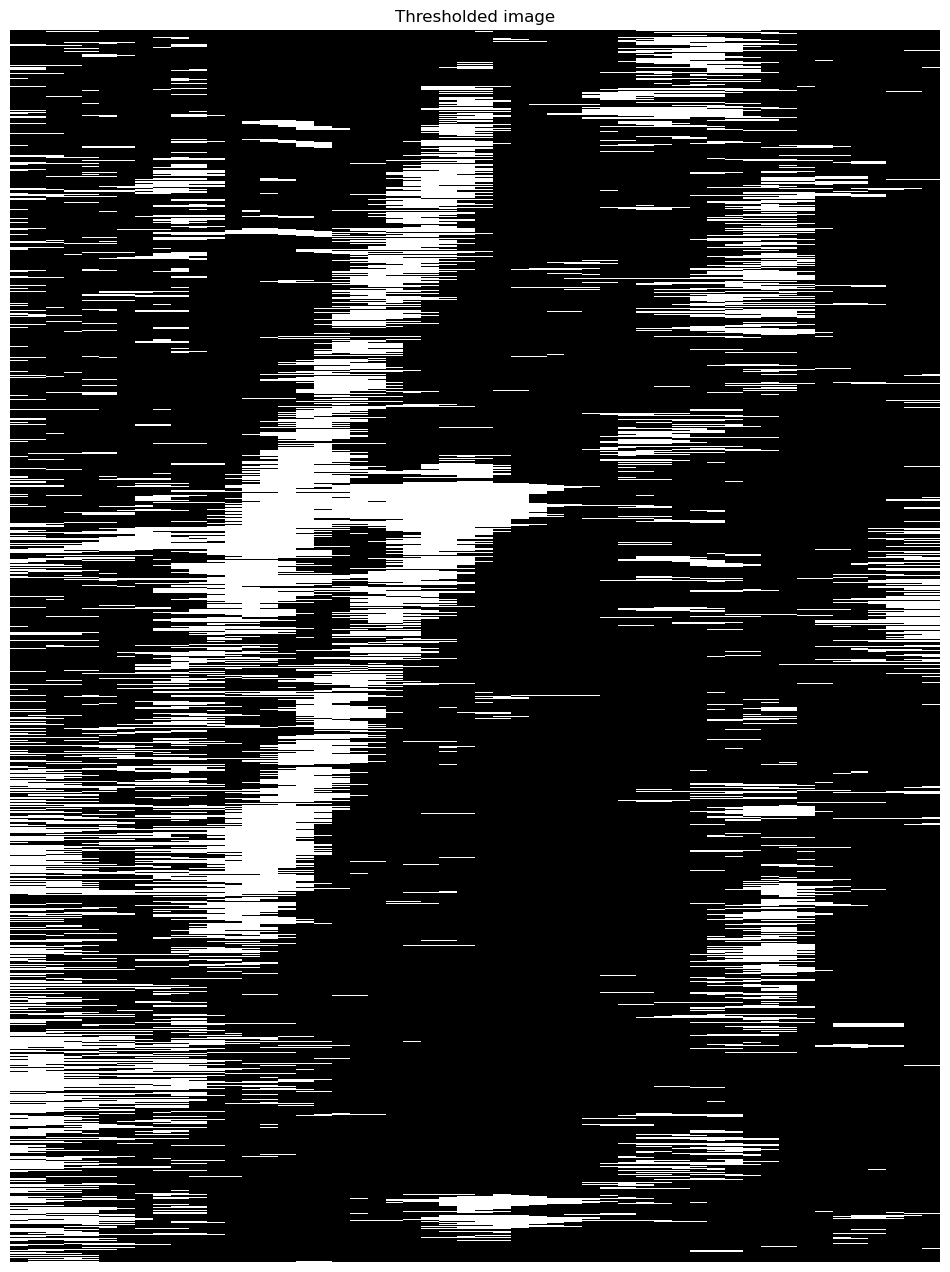

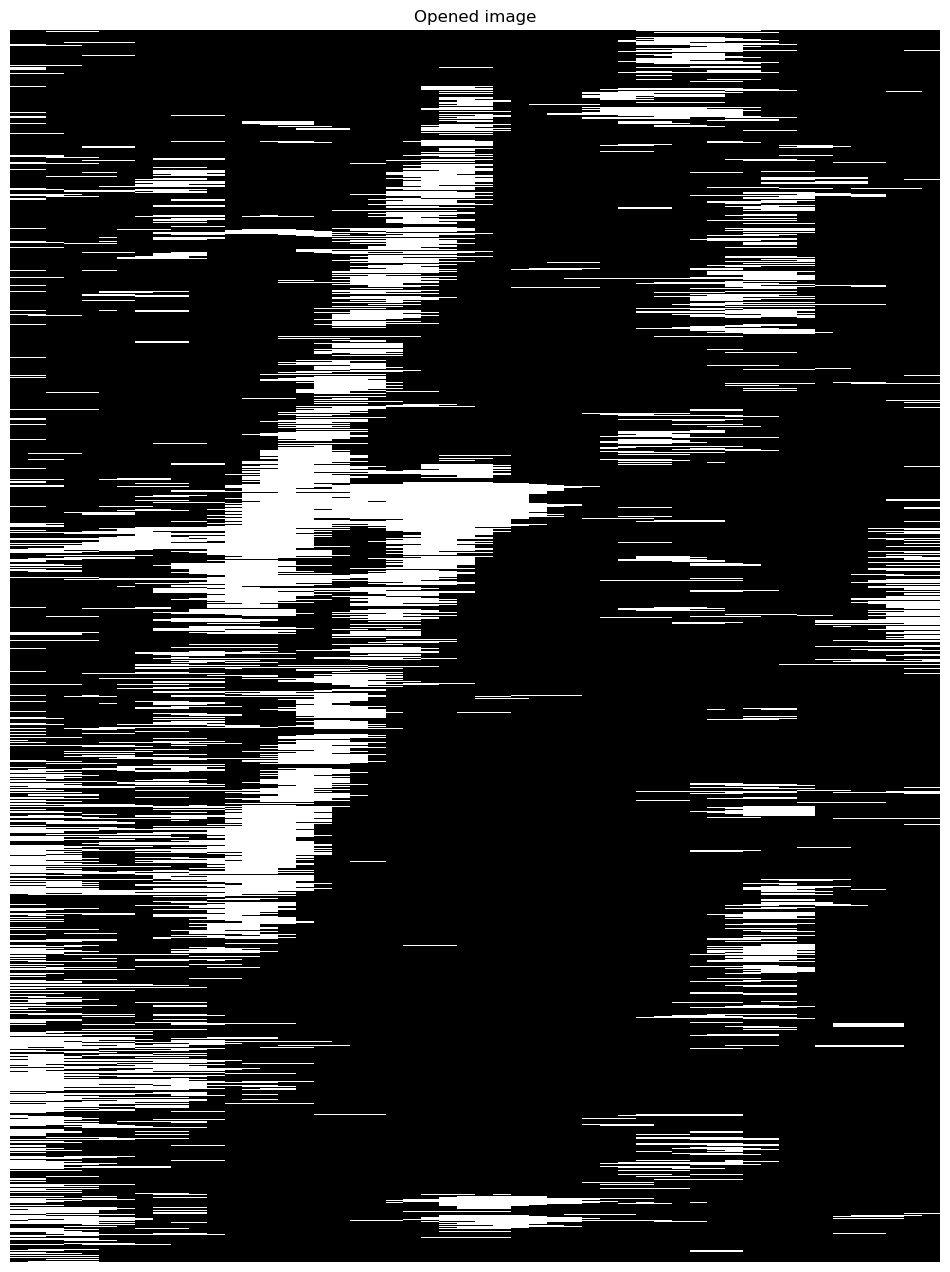

Discarded cluster 0 with R2=0.11595912256102459 (<0.6)


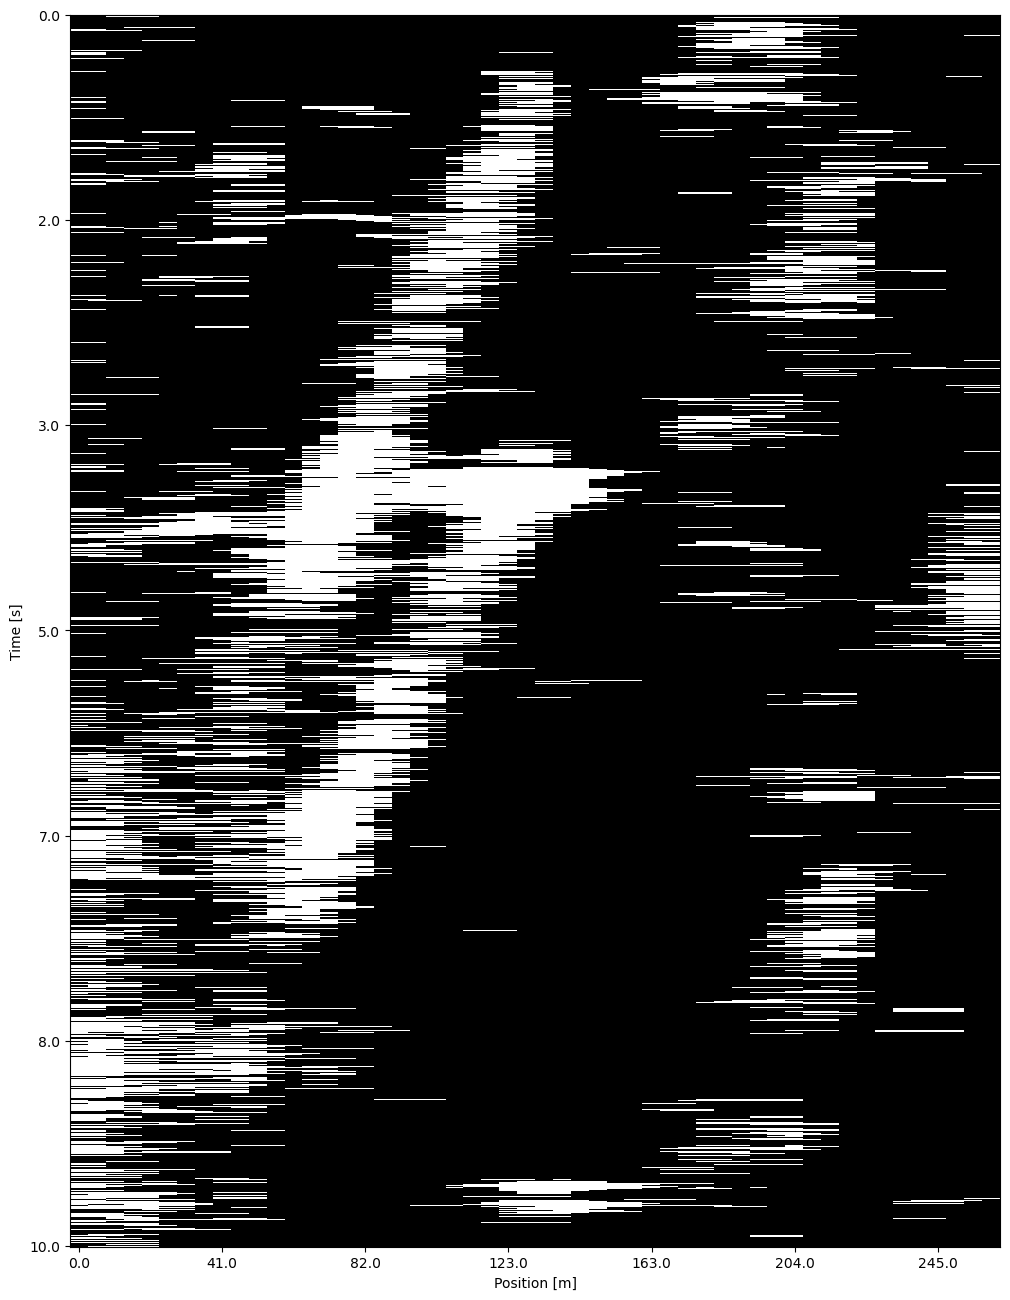

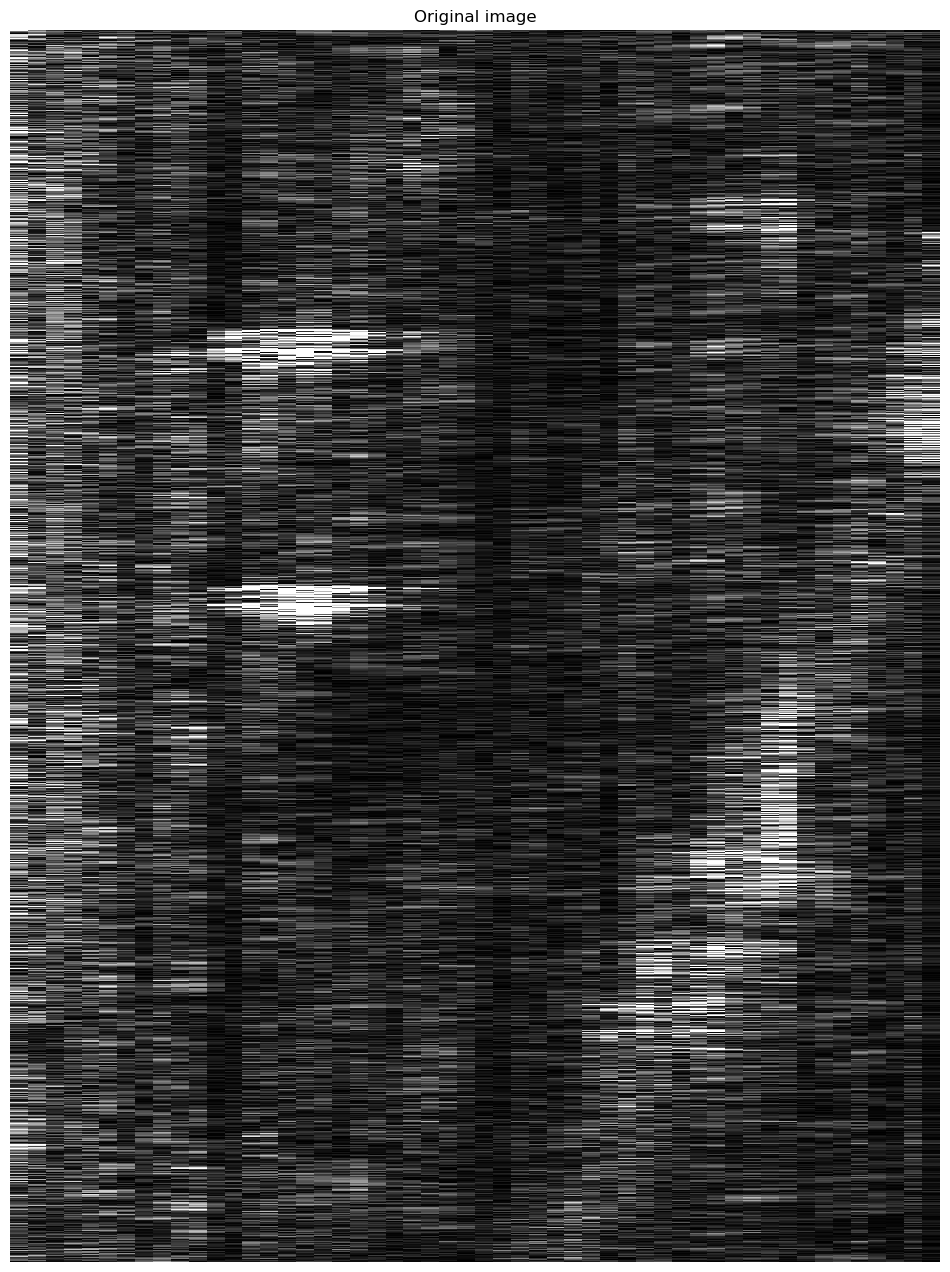

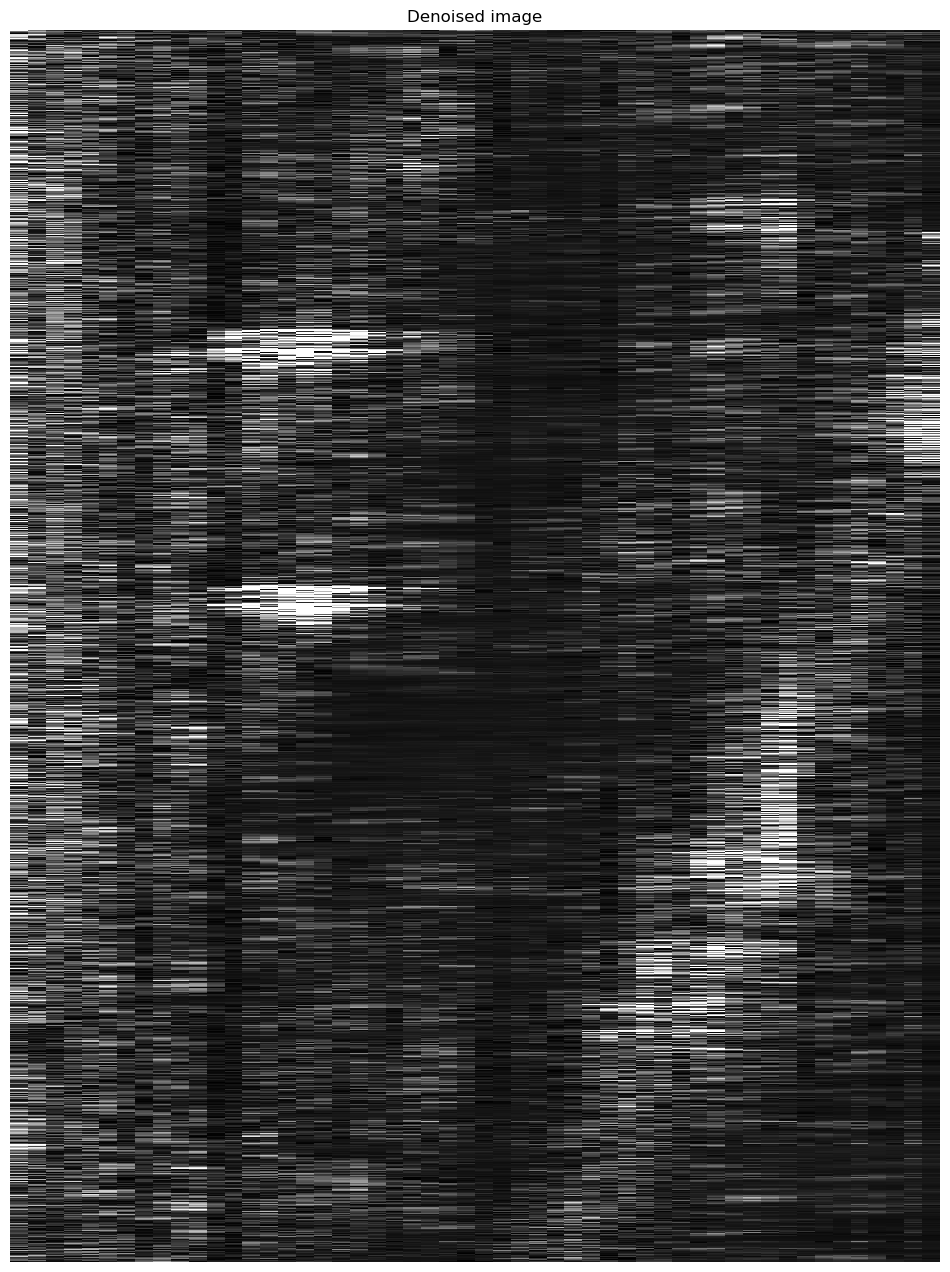

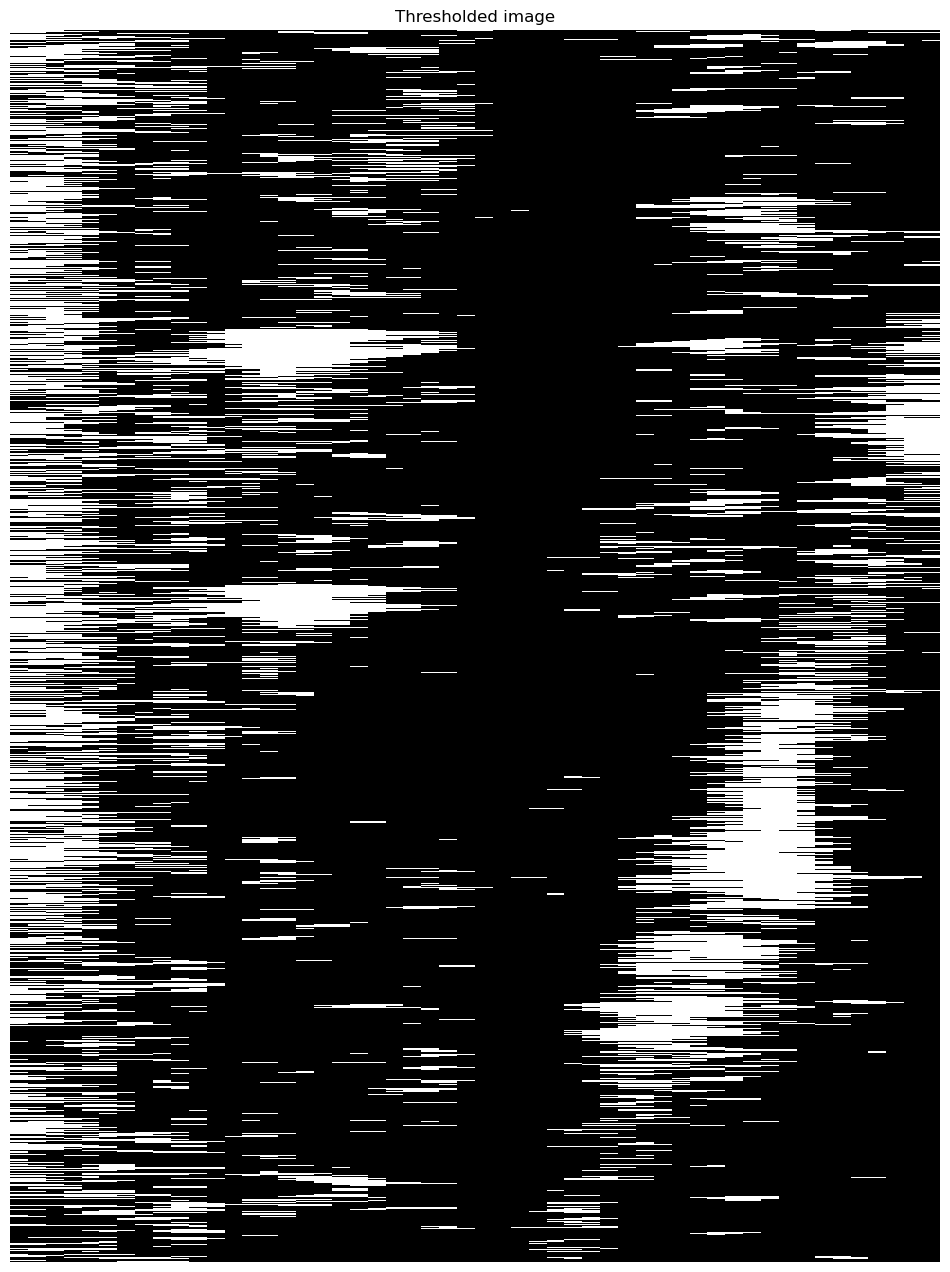

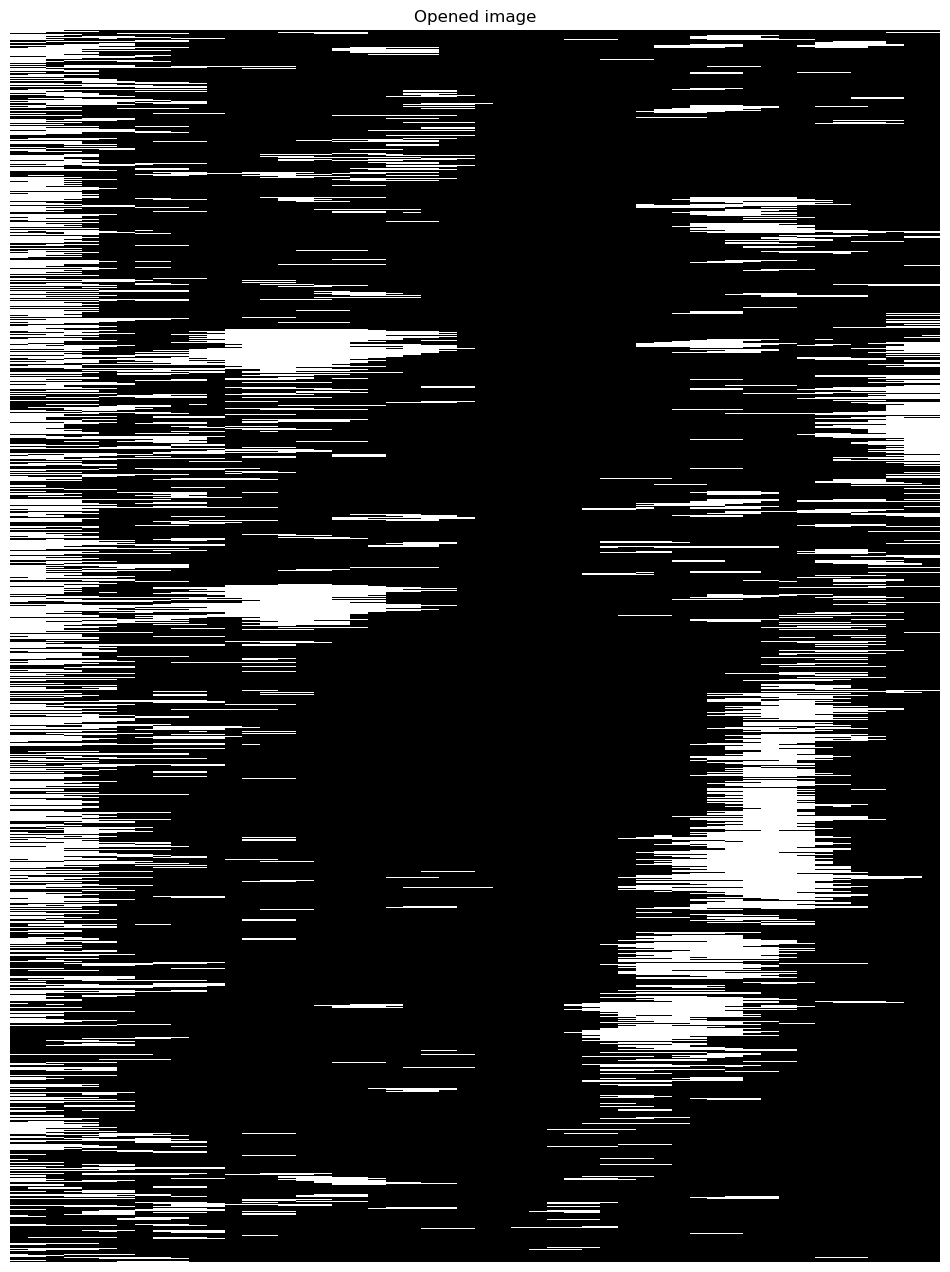

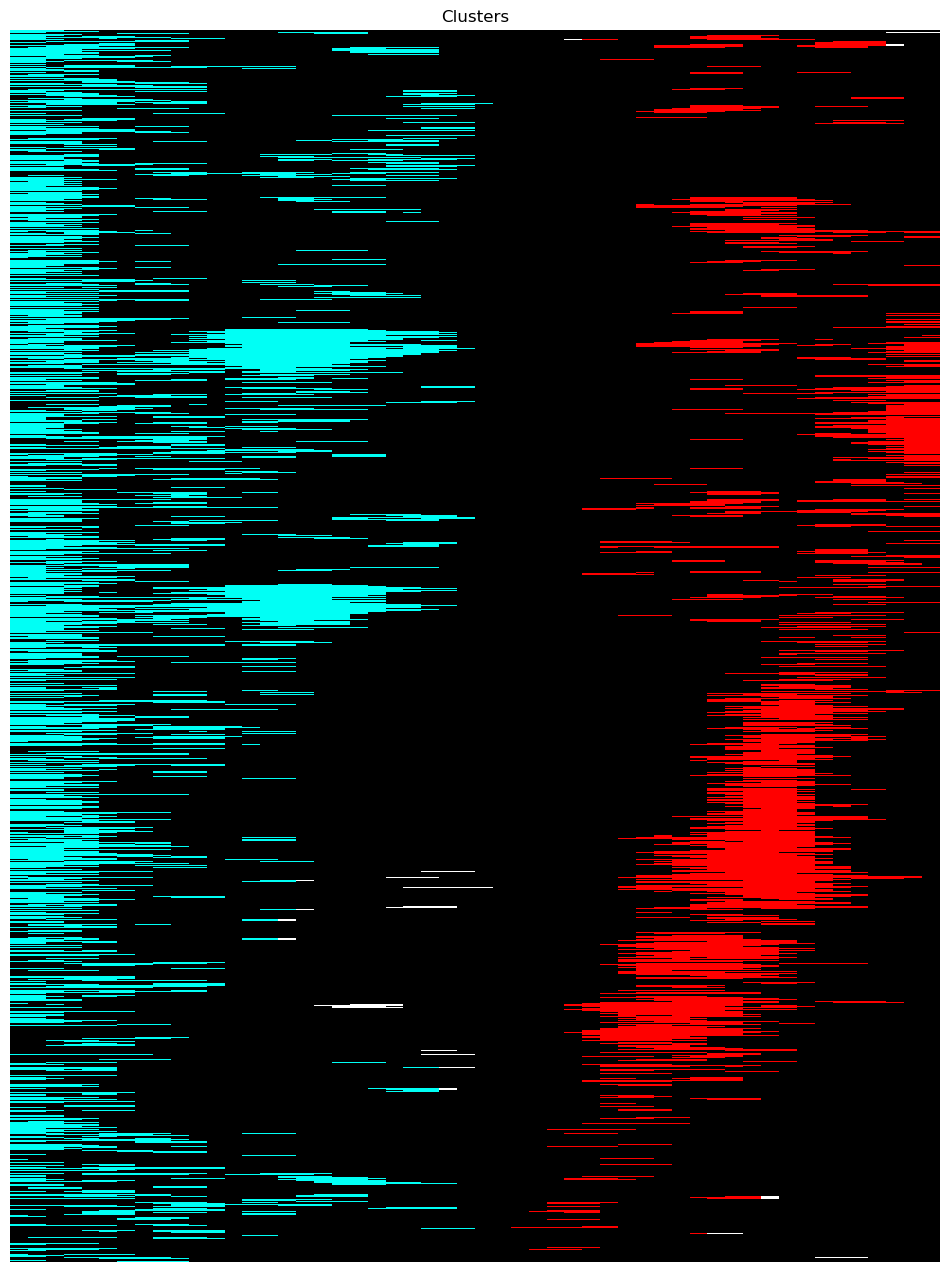

Discarded cluster 0 with R2=0.02639498941624918 (<0.6)
Discarded cluster 1 with R2=0.25331851708422504 (<0.6)


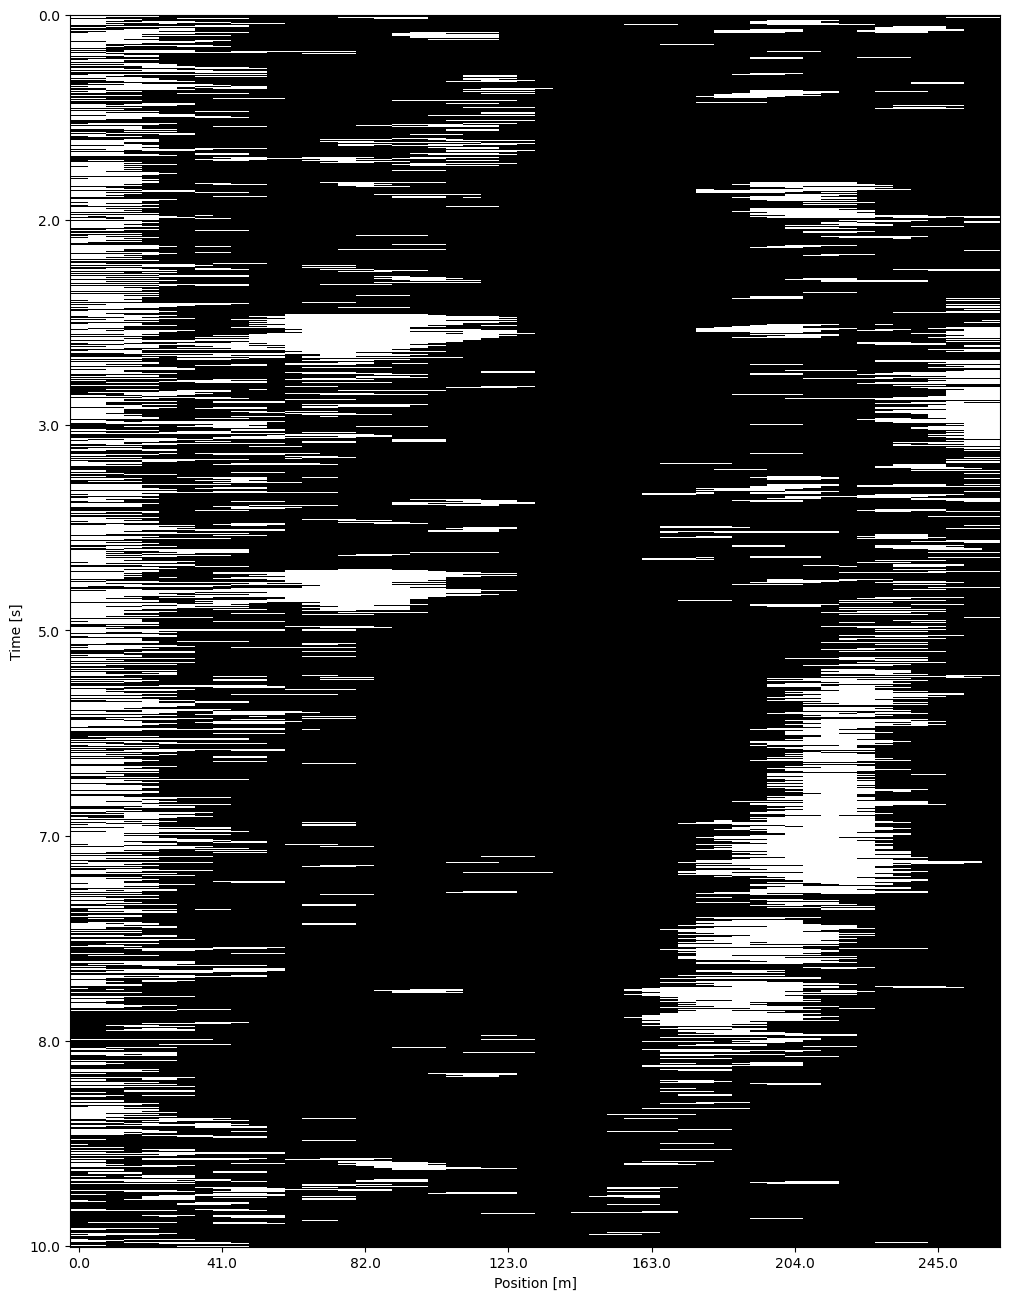

In [16]:
for data in load_all_files():
    detect_velocities(data)